<div style="display: flex; flex-direction: column; align-items: center; max-width: 100%; padding: 20px 0; margin: auto;">
    <img src="https://media.licdn.com/dms/image/v2/D4D3DAQFGx0XnuUvugA/image-scale_191_1128/image-scale_191_1128/0/1662458005755/nova_ims_information_management_school_cover?e=2147483647&v=beta&t=J3Q4LlZi36_4UAFhj2019QdtfXLn0kQwaX25jgaBhOQ" 
         alt="Logo" 
         style="width: 100%; max-width: 800px; height: auto; max-height: 150px; object-fit: cover; border: 3px solid hsla(120, 71.40%, 43.90%, 0.30); border-radius: 5px;">
    <div style="text-align: center; padding: 10px 0; max-width: 800px;">
        <h5 style="margin: 10px 0;">This analysis is conducted as part of the <b><i>Neural and Evolutionary Learning</i></b> course, a component of the Master's program in Data Science and Advanced Analytics at the <b><u>Nova Information Management School</u></b>.</h5>
    </div>
    <h1 style="color: hsla(120, 71.40%, 43.90%, 0.30); margin: 10px 0;"><b>Predict the Crude Protein Weight</b></h1>
</div>

<div style="text-align: center; margin: 20px 0;">
    <h3 style="margin-bottom: 15px;"><u>Group 22</u></h3>
    <table style="margin: 0 auto; border-collapse: collapse; width: 80%; max-width: 500px;">
        <thead>
            <tr>
                <th style="border-bottom: 1px solid #ddd; padding: 8px;">Student Name</th>
                <th style="border-bottom: 1px solid #ddd; padding: 8px;">Student ID</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td style="border-bottom: 1px solid #ddd; padding: 8px;">Catarina Nunes</td>
                <td style="border-bottom: 1px solid #ddd; padding: 8px;">20230083</td>
            </tr>
            <tr>
                <td style="border-bottom: 1px solid #ddd; padding: 8px;">Sofia Jacinto</td>
                <td style="border-bottom: 1px solid #ddd; padding: 8px;">20240598</td>
            </tr>
            <tr>
                <td style="padding: 8px;">José Cavaco</td>
                <td style="padding: 8px;"> 20240513</td>
            </tr>
        </tbody>
    </table>
</div>

<a id="idx"></a>
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: center; margin-top: 20px; margin-bottom: 20px;">
    <h1 style="color: white; margin: 0;">Index</h1>
</div>

1. [Preprocessing the data](#preprocessing)
2. [Choosing the method and parameters](#method-selection)
3. [Estimating the predictive error](#error-estimation)
4. [Inducing the final model](#model-induction)
5. [Testing the final model](#final-testing)

#### Metadata

|Feature |Definition|
|----|-----|
|wing_tag |Chicken unique ID|
|weight |The chicken total weight|
|hot_carcass_weight |The weight of the carcass immediately after slaughter|
|carcass_weight_with_head_and_legs |The weight of the carcass including the head and legs|
|cold_carcass_weight| The weight of the carcass after cooling|
|breast_weight |The weight of the breast meat of the chicken|
|thigh_weight |The weight of the thigh meat of the chicken|
|spleen |The weight of the chicken’s spleen|
|liver |The weight of the chicken’s liver|
|heart |The weight of the chicken’s heart|
|intestine |The weight of the chicken’s intestine|
|empty_muscular_stomach| Indicates the presence or absence of the empty muscular stomach of the chicken|
|glandular_stomach |The weight of the chicken’s glandular stomach|
|crude_protein| The weight of crude protein in the carcass|
|ether_extract |The weight of ether extract, which measures the total fat in the carcass|

#### Imports & Settings

In [1]:
#pip install -r requirements.txt
# pip install neat-python

In [2]:
# Standard library imports
import os
import gc
import pickle
import datetime
import random
import warnings
from collections import Counter
from itertools import product

# Third-party numerical/scientific computing
import numpy as np
import pandas as pd
import scikit_posthocs as sp
from scipy.stats import wilcoxon, friedmanchisquare

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm
from IPython.display import display, HTML

# Machine Learning
from sklearn.datasets import fetch_openml
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer

# Deep Learning (PyTorch)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam

#NEAT
import sys
import torch
import neat
import visualize
import json
import shutil
import ast
from neat import nn, Config, DefaultGenome, DefaultReproduction, DefaultSpeciesSet, DefaultStagnation
import visualize

# Custom/local imports
from slim.main_gp import gp
from slim_gsgp.main_gsgp import gsgp
from slim_gsgp.main_slim import slim
from slim_gsgp.datasets.data_loader import *
from slim.evaluators.fitness_functions import rmse
from slim.utils.utils import train_test_split

import time

# Suppress warnings
warnings.filterwarnings('ignore')

C:\Users\catar\AppData\Local\Temp\ipykernel_22048\1765553042.py:59: DeprecationWarning: The `gsgp_slim` package is deprecated. Please use the `slim_gsgp` package instead: https://pypi.org/project/slim_gsgp/
  from slim.main_gp import gp


In [3]:
from nested_cv import nested_cv_gp_slim_gsgp

In [4]:
os.environ["PATH"] += os.pathsep + "C:\\Program Files\\Graphviz\\bin"

In [5]:
seed = 42
np.random.seed(seed)
random.seed(seed)

In [6]:
train_color = 'blue'
test_color = 'orange'

In [7]:
#! ls

#### Helpfull Functions

In [8]:
def plot_boxplots(df_clients, columns):
    """
    Plot multiple boxplots horizontally with scrolling enabled.
    """
    n_cols = len(columns)
    
    fig = make_subplots(
        rows=1,
        cols=n_cols,
        shared_yaxes=False,
        horizontal_spacing=0.05,  # space between boxplots
        subplot_titles=[col.replace("_", " ").title() for col in columns]
    )

    for idx, column in enumerate(columns, start=1):
        fig.add_trace(
            go.Box(
                y=df_clients[column],
                name=column.replace("_", " ").title(),
                boxpoints='outliers',  # only show outliers
                whiskerwidth=0.2,
                marker_color='mediumseagreen',
                line_color='seagreen',
                fillcolor='rgba(60,179,113,0.3)',
                marker_size=4
            ),
            row=1,
            col=idx
        )

    fig.update_layout(
        title='Outliers Analysis',
        title_font_size=24,
        plot_bgcolor='white',
        height=600,
        width=300 * n_cols,  # make width proportional to number of boxplots
        showlegend=False
    )

    fig.update_yaxes(zeroline=False)

    fig.show()

### <a id="preprocessing"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: center; margin-top: 20px; margin-bottom: 20px;">
    <h3 style="color: white; margin: 0;">Preprocessing the data</h3>
</div>

[Back to Index](#idx)

#### Data Loading

In [9]:
df = pd.read_excel(r"data\sustavianfeed.xlsx")

In [10]:
df.head()

,WING TAG,WEIGHT,HOT CARCASS WEIGHT,CARCASS WEIGHT WITH HEAD AND LEGS,COLD CARCASS WEIGHT,BREAST WEIGHT (2),THIGH WEIGHT (2),SPLEEN,LIVER,HEART,INTESTINE,EMPTY MUSCULAR STOMACH,GLANDULAR STOMACH,CRUDE PROTEIN,ETHER EXTRACT
0,G403,2223.3,1429.6,1725.6,1394.0,214.0,489.4,3.716,38.636,9.305,123.171,/,13.170,86.105469,0.38
1,G439,2201.9,1450.2,1769.8,1405.4,236.0,538.7,3.494,34.725,10.084,71.800,45.273,9.781,86.143472,1.66
2,G454,2159.9,1398.4,1724.9,1461.7,241.8,512.1,4.023,31.932,10.635,61.380,/,6.217,86.416898,0.98
3,G465,2198.7,1473.9,1800.4,1425.1,227.7,549.9,3.087,32.326,11.927,64.879,35.861,8.358,85.959935,1.10
4,G428,2003.2,1291.2,1581.6,1260.1,224.7,473.2,3.723,30.105,9.855,68.562,36.526,7.572,81.693637,6.34


lets rename the columns according to the metadata:

In [11]:
# column name mapping
column_mapping = {
    'WING TAG': 'wing_tag',
    'WEIGHT': 'weight',
    'HOT CARCASS WEIGHT': 'hot_carcass_weight',
    'CARCASS WEIGHT WITH HEAD AND LEGS': 'carcass_weight_with_head_and_legs',
    'COLD CARCASS WEIGHT': 'cold_carcass_weight',
    'BREAST WEIGHT (2)': 'breast_weight',
    'THIGH WEIGHT (2)': 'thigh_weight',
    'SPLEEN': 'spleen',
    'LIVER': 'liver',
    'HEART': 'heart',
    'INTESTINE': 'intestine',
    'EMPTY MUSCULAR STOMACH': 'empty_muscular_stomach',
    'GLANDULAR STOMACH': 'glandular_stomach',
    'CRUDE PROTEIN': 'crude_protein',
    'ETHER EXTRACT': 'ether_extract'
}

df = df.rename(columns=column_mapping)

#### Descriptive Summary

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
weight,96.0,2339.682292,200.943424,1968.400000,2201.775000,2299.500000,2473.800000,2890.500000
hot_carcass_weight,96.0,1521.955208,144.126939,1284.900000,1425.775000,1493.050000,1608.400000,1929.400000
carcass_weight_with_head_and_legs,96.0,1833.378125,154.000550,1554.400000,1723.800000,1809.400000,1922.725000,2262.800000
cold_carcass_weight,96.0,1481.479167,142.830115,1252.600000,1380.825000,1452.800000,1573.700000,1891.700000
breast_weight,96.0,234.116667,37.818405,177.100000,218.775000,231.550000,243.275000,533.200000
thigh_weight,96.0,542.205208,60.994468,177.800000,508.225000,538.100000,573.850000,690.600000
spleen,96.0,4.219917,0.998836,2.464000,3.534250,4.048000,4.817000,7.758000
liver,96.0,36.781427,5.438894,25.916000,33.053000,35.936000,40.485000,53.133000
heart,96.0,12.059240,1.932239,8.561000,10.584250,11.679000,13.449750,17.194000
intestine,96.0,69.149156,11.727467,44.133000,62.274250,68.019500,75.103000,123.171000


In [13]:
df.describe(include='O').T

,count,unique,top,freq
wing_tag,96,96,G403,1
empty_muscular_stomach,96,91,/,5


In [14]:
df.isna().sum()

wing_tag                             0
weight                               0
hot_carcass_weight                   0
carcass_weight_with_head_and_legs    0
cold_carcass_weight                  0
breast_weight                        0
thigh_weight                         0
spleen                               0
liver                                0
heart                                0
intestine                            0
empty_muscular_stomach               0
glandular_stomach                    0
crude_protein                        0
ether_extract                        0
dtype: int64

- no missing values
- `wing_tag` uniquely represents each chicken so can be placed as index.

In [15]:
df.set_index('wing_tag', inplace = True)

In [16]:
df.duplicated().sum()

0

#### Data Types

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96 entries, G403 to V428
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   weight                             96 non-null     float64
 1   hot_carcass_weight                 96 non-null     float64
 2   carcass_weight_with_head_and_legs  96 non-null     float64
 3   cold_carcass_weight                96 non-null     float64
 4   breast_weight                      96 non-null     float64
 5   thigh_weight                       96 non-null     float64
 6   spleen                             96 non-null     float64
 7   liver                              96 non-null     float64
 8   heart                              96 non-null     float64
 9   intestine                          96 non-null     float64
 10  empty_muscular_stomach             96 non-null     object 
 11  glandular_stomach                  96 non-null     float64
 

In [18]:
df['empty_muscular_stomach'].unique()

array(['/', 45.273, 35.861, 36.526, 40.993, 40.949, 45.323, 42.091,
       49.148, 46.807, 31.103, 49.057, 39.621, 43.128, 53.485, 38.836,
       44.487, 47.665, 50.006, 43.695, 59.547, 61.306, 61.702, 60.063,
       45.428, 53.456, 43.586, 49.648, 63.571, 47.523, 63.86, 64.538,
       42.852, 50.119, 32.665, 35.164, 46.656, 44.855, 44.962, 51.851,
       45.507, 50.136, 43.821, 66.616, 29.712, 40.936, 52.518, 35.408,
       51.944, 41.483, 56.23, 55.663, 42.66, 32.12, 43.964, 75.767,
       45.327, 42.129, 47.964, 44.811, 32.599, 32.947, 38.155, 48.009,
       56.347, 59.583, 51.322, 58.708, 41.917, 40.425, 51.903, 56.698,
       40.7, 45.321, 55.671, 68.602, 44.006, 54.71, 45.636, 34.692,
       48.933, 45.045, 48.02, 42.632, 45.366, 52.457, 49.281, 54.021,
       42.173, 49.7, 46.816], dtype=object)

The metadata for the column `empty_muscular_stomach` specifies that it should be a binary flag, '_Indicates the presence or absence of the empty muscular stomach of the chicken_'. However, the data contains a '/' that represents 'yes' for an empty stomach, and other values that indicate that the stomach is not empty, such as percentages or grams. We will evaluate whether it is more valuable to maintain this column as a float or a binary flag, based on its correlation with the target variable. Ultimately, we plan to adhere to the guidance provided in the metadata, but lets see:

In [19]:
df['empty_muscular_stomach_bin'] = np.where(
    df['empty_muscular_stomach'] == '/', 1, 0
).astype(int)

In [20]:
df['empty_muscular_stomach_float'] = df['empty_muscular_stomach'].replace('/', 0).astype(float)

#### Outliers

In [21]:
plot_boxplots(df, df.columns)

Given the presence of outliers and the small size of the dataset, the best approach is to incorporate the Robust Scaler into the model's pipeline.

#### Correlations

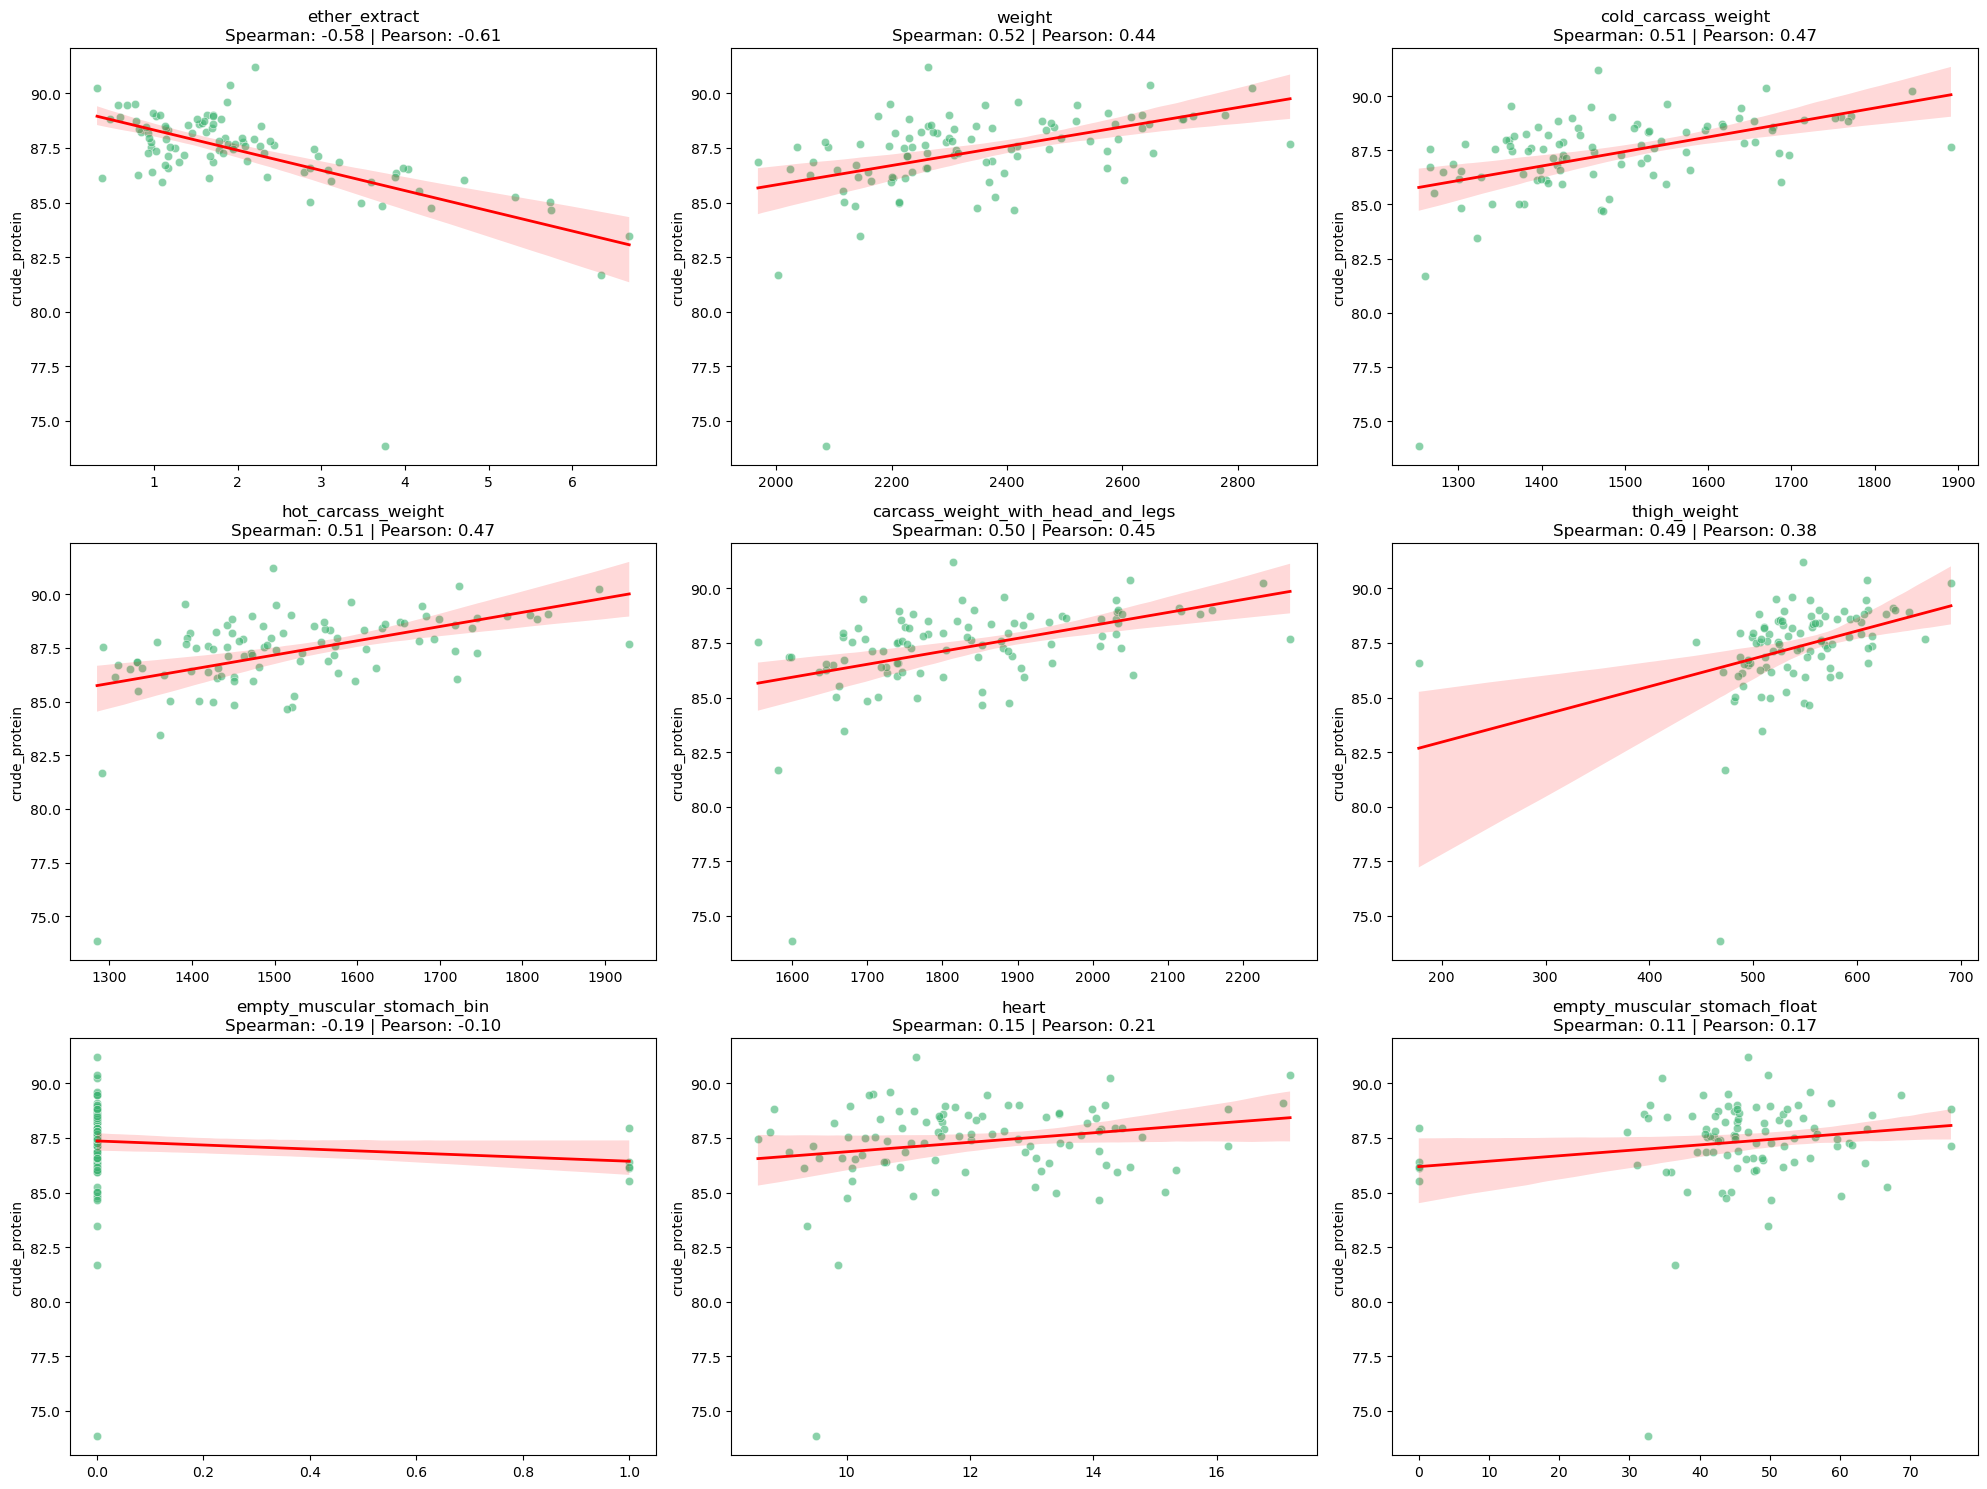

Correlations with crude_protein:


,spearman,pearson
feature,,
ether_extract,-0.582762,-0.612023
weight,0.519340,0.435335
cold_carcass_weight,0.509838,0.467681
hot_carcass_weight,0.508193,0.466773
carcass_weight_with_head_and_legs,0.498589,0.446827
thigh_weight,0.485786,0.379469
empty_muscular_stomach_bin,-0.190323,-0.101427
heart,0.153040,0.205162
liver,0.145050,0.123440


In [22]:
#code adapted from previous work

# correlations with crude_protein
target = 'crude_protein'
numeric_cols = df.select_dtypes(include=['number']).columns
features = [col for col in numeric_cols if col != target] 

# both correlation types
corr_data = df[features + [target]]  # Note: target needs to be in a list
spearman_corr = corr_data.corr(method='spearman')[target]
pearson_corr = corr_data.corr(method='pearson')[target]

# Combine into a DataFrame for easier analysis
corr_df = pd.DataFrame({
    'feature': features,
    'spearman': spearman_corr[features],
    'pearson': pearson_corr[features]
}).sort_values(by='spearman', key=abs, ascending=False)

# Set threshold (adjust as needed)
threshold = 0.15
significant_features = corr_df[(abs(corr_df['spearman']) >= threshold) | 
                             (abs(corr_df['pearson']) >= threshold)]

# Plot settings
num_features = len(significant_features)
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows))
if num_features > 0:  # Only proceed if there are significant features
    if num_rows == 1:
        axes = axes.reshape(1, -1)  # Ensure axes is always 2D

    # Plot each significant feature against target
    for i, (_, row) in enumerate(significant_features.iterrows()):
        ax = axes[i//num_cols, i%num_cols]
        feature = row['feature']
        
        # Scatterplot
        sns.scatterplot(x=df[feature], y=df[target], ax=ax, color='mediumseagreen', alpha=0.6)
        
        # Regression line if possible
        if df[feature].nunique() > 1:
            try:
                sns.regplot(x=df[feature], y=df[target], ax=ax, 
                            scatter=False, color='red', line_kws={'linewidth':2})
            except:
                pass
        
        # Add correlation info to title
        ax.set_title(f"{feature}\nSpearman: {row['spearman']:.2f} | Pearson: {row['pearson']:.2f}")
        ax.set_xlabel('')
        ax.set_ylabel('crude_protein')

    # Hide empty subplots
    for j in range(i+1, num_rows*num_cols):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()

    # Show correlation table
    corr_df = corr_df.set_index('feature')
    print("Correlations with crude_protein:")
    display(corr_df.style.background_gradient(cmap='BuGn', vmin=-1, vmax=1))
else:
    print(f"No features found with correlation >= {threshold}")

When  picking features for modeling, it's crucial to give a special focus on those that have the strongest correlation with the target variable, since they tend to boost predictive performance the most.

In this scenario, features like ether_extract, weight, cold_carcass_weight, hot_carcass_weight, carcass_weight_with_head_and_legs, and thigh_weight stand out with the highest correlation to the target, making them key candidates for inclusion. 

But just because a feature has a high correlation doesn’t mean thy are useless, features that might seem less significant on their own—like heart, liver, or breast_weight—can still bring value when paired with others, especially in non-linear models or when considering interaction effects. So, while the strongest features lay a solid groundwork, it’s wise not to overlook the weaker ones too quickly without doing some additional testing in the modeling process.

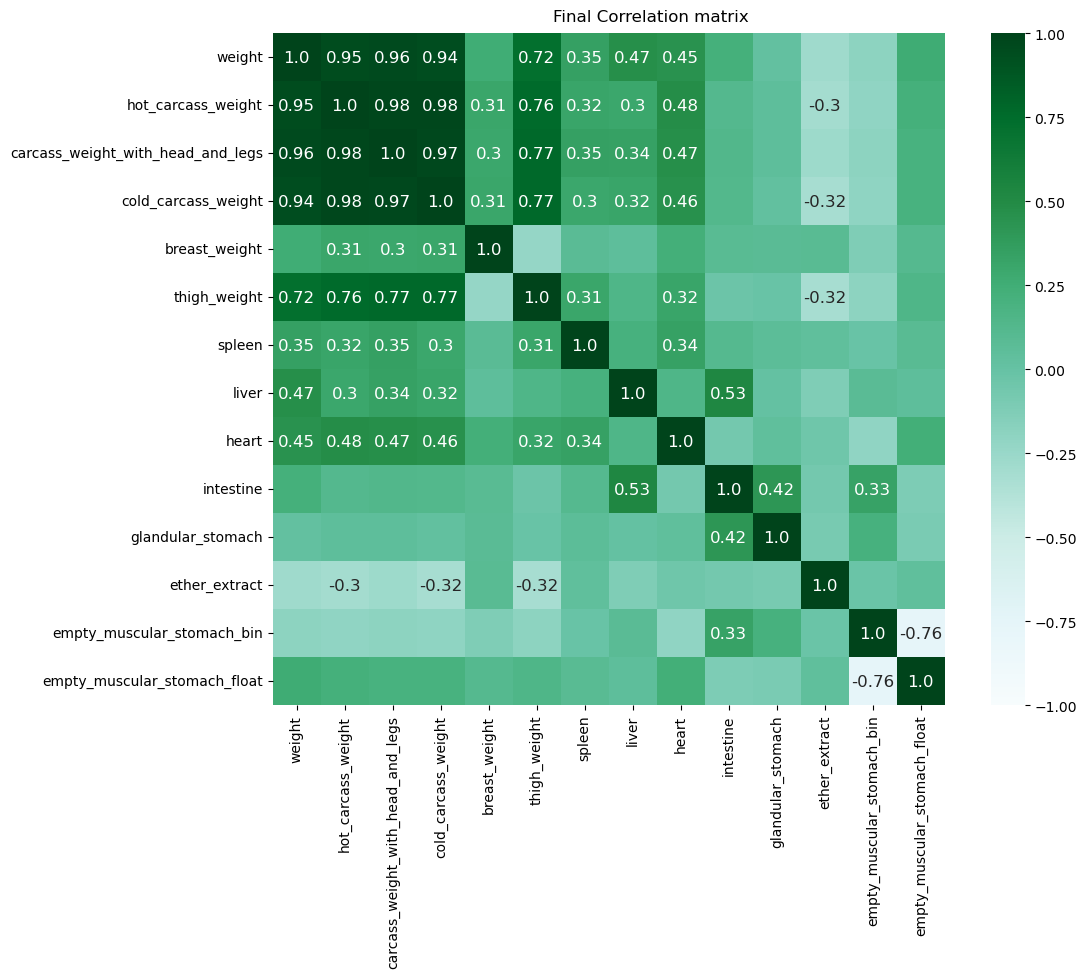

In [23]:
corr = df[features].corr().round(2)
fig = plt.figure(figsize=(12, 8))

# annotation matrix - values above |0.3| will appear in the plot
mask_annot = np.absolute(corr.values) >= 0.3
annot = np.where(mask_annot, corr.values, np.full(corr.shape, ''))
sns.heatmap(data = corr, annot = annot, cmap = 'BuGn', fmt = 's', vmin = -1, vmax = 1, center = 0, square = True, linewidths = 0, annot_kws = {'size': 12})

fig.subplots_adjust(top = 0.95)
fig.suptitle('Final Correlation matrix');

The correlation matrix reveals some strong linear relationships among various variables, which points to possible redundancy in the dataset:

- For example, weight, hot_carcass_weight, carcass_weight_with_head_and_legs, and cold_carcass_weight are all highly correlated with each other, with values ranging from 0.94 to 0.98, very high. This indicates that including all four in a model or analysis could lead to multicollinearity issues.

- So, to simplify, we might want to keep just one representative variable—like hot_carcass_weight—and leave the others out.

We are going to keep `empty_muscular_stomach_bin` since it has a better correlation witht the target.

In [24]:
df['empty_muscular_stomach'] = df['empty_muscular_stomach_bin'] 

In [25]:
df = df.drop(columns=['empty_muscular_stomach_float', 'empty_muscular_stomach_bin'])

`IMPORTANT:`the project description spcifically says "predict the crude protein weight using the remaining features in the dataset, excluding the animal ID." so we corrected the `empty_muscular_stomach` but we will not perform feature selection at this stage, basically we ll have this initial approach were we will test the models with all the features. If futher instructions state otherwise we will follow the analysis above.

In [26]:
scaler = RobustScaler()
scaled_values = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_values, columns=df.columns, index=df.index)

# Create interactive scatter plot
fig = go.Figure()

# Plot all features in light grey
for col in scaled_df.columns:
    if col != 'crude_protein':
        fig.add_trace(go.Scatter(
            x=scaled_df.index,
            y=scaled_df[col],
            mode='markers',
            marker=dict(color='lightgrey', size=6),
            name=col,
            text=[f'{col}: {val:.2f}' for val in scaled_df[col]],
            hoverinfo='text'
        ))

# Plot 'crude_protein' in green
fig.add_trace(go.Scatter(
    x=scaled_df.index,
    y=scaled_df['crude_protein'],
    mode='markers',
    marker=dict(color='green', size=7),
    name='crude_protein',
    text=[f'crude_protein: {val:.2f}' for val in scaled_df['crude_protein']],
    hoverinfo='text'
))

# Layout with scrollable x-axis
fig.update_layout(
    title='Robust Scaled Feature Values Across Index (Highlighting Crude Protein)',
    xaxis=dict(title='Index', rangeslider=dict(visible=True)),
    yaxis=dict(title='Scaled Value'),
    height=600,
    showlegend=False
)

fig.show()

We have two extreme cases that may potentially affect the results: V439 and V419. Cases like the G428 and B463 have a crude protein lower than the rest, but we can see that the variables like the ether_extract can accompany this variation. 

### <a id="method-selection"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: center; margin-top: 20px; margin-bottom: 20px;">
    <h3 style="color: white; margin: 0;">Choosing the method and parameters for each model</h3>
</div>

[Back to Index](#idx)

- [1. Nested cross-validation vs. Monte Carlo cross-validation](#method) 
- [2. Genetic Programming (GP)](#gp) - Delivery 1 (Done)
- [3. Geometric Semantic Geometric Programming (GSGP)](#gsgp) - Delivery 2 (Done)
- [4. Semantic Learning algorithm with Inflate and deflate Mutations (SLIM)](#slim) - Delivery 3 (Done)
- [5. Neural Network (NN)](#nn) - Delivery 4 (Done)
- [6. NeuroEvolution of Augmenting Topologies (NEAT)](#neat) - Delivery 5 (Done)

#### <a id="method"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: left; margin-top: 20px; margin-bottom: 20px;">
    <h4 style="color: white; margin: 0;">1. Nested cross-validation vs. Monte Carlo cross-validatio</h4>
</div>

[Back to Index](#idx)

In this project, we opted for **nested cross-validation (nested CV)** as our dataset partitioning strategy for both model selection (hyperparameter tuning) and performance evaluation.

This decision was based on the following considerations:

1. **Final Comparative Evaluation Across Algorithms**  
   At the end of the project, _"the same partitions should be used across all the algorithms to be studied"_, we will compare Genetic Programming (GP) and Geometric Semantic Genetic Programming (GSGP) and other machine learning algorithms.  
   To ensure a **fair and unbiased comparison**, the **same dataset partitions** must be used across all algorithms (are all evaluated under the same conditions basically) - Nested CV provides a systematic and reproducible way to maintain this consistency.

2. **Separation of Concerns: Tuning vs. Evaluation**  
   Nested CV explicitly separates the hyperparameter optimization (inner loop) from the model evaluation (outer loop).  
   This avoids **information leakage** and reduces the risk of **overfitting during model selection**, which is particularly relevant for algorithms like GP that are prone to overfitting and premature convergence.
   "the advantage of doing several iterations in cross-validation is that it allows us to obtain an error estimate that is not dependent on a single data splitting and a particular choice of the training data"_ (Vanneschi & Silva, Sec. 5.3, p.130). Nested CV extends this robustness by adding an inner loop for model selection, which further reduces the risk of biased or optimistic performance estimation.

3. **Avoiding Pitfalls of Monte Carlo CV in This Context**
   Although Monte Carlo cross-validation (or repeated random subsampling) can be viewd as an alternative (Vanneschi & Silva, p.130-131), it comes with a notable limitation: _"some observations may never be selected for the test set, while others will be selected more than once"_. In this project, where a **comparative and reproducible evaluation across multiple algorithms is required**, this irregularity makes Monte Carlo CV less appropriate than nested CV.  Using a **K-Fold outer loop** (e.g., `K=10`) ensures that every instance in the dataset is used for testing exactly once, and for training K-1 times, and combined with an **inner K-Fold** (e.g., `K=5`) for tuning, this strategy enables robust **statistical comparisons** (e.g., Wilcoxon tests, Friedman + Nemenyi post-hoc), which are essential to draw valid conclusions about performance differences between models.

   The  different CV strategies may be appropriate for different phases: _"it may make sense to use 5-fold or 10-fold cross-validation for choosing the method and parameters (...) and then use Monte Carlo (...) for a thorough estimation of the error"_ (p.131).  
   However, since our pipeline includes both tuning and evaluation as part of the **same CV process**, and comparison across methods is the final goal, we apply nested CV consistently for both.

4. Despite the relatively small size of our dataset (96 instances), we argue that nested cross-validation remains a justified choice. As pointed out by Vanneschi & Silva (Section 5.3), the reliability of performance estimation is a crucial concern when data is scarce. Nested CV is particularly effective in avoiding overfitting during hyperparameter tuning, which becomes even more critical under these circumstances.

The training and test sets generated in each fold still preserve enough data to fit and evaluate meaningful models. Moreover, since the dataset is small, the computational overhead introduced by nested CV is negligible.

In summary, while some may consider using Monte Carlo cross-validation to reduce computational cost or avoid small folds, the benefits of using nested cross-validation — particularly in terms of fair model selection and unbiased generalization error estimation — outweigh the drawbacks, especially when working with limited data.


In [27]:
target = 'crude_protein'
X = df.drop(columns=[target])
y = df[target]

In [28]:
k_outer = 5
k_inner = 3
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
outer_cv = KFold(n_splits=k_outer, shuffle=True, random_state=seed)
inner_cv = KFold(n_splits=k_inner, shuffle=True, random_state=seed)

total_instances = X.shape[0]
outer_test_size = total_instances // k_outer
outer_train_size = total_instances - outer_test_size
inner_val_size = outer_train_size // k_inner
inner_train_size = outer_train_size - inner_val_size

print(f'Total Instances:\t{total_instances}\n--')
print(f'Outer Train set:\t{outer_train_size}')
print(f'Test set:\t\t{outer_test_size}\n--')
print(f'Inner Train set:\t{inner_train_size}')
print(f'Validation set:\t\t{inner_val_size}\n')

Total Instances:	96
--
Outer Train set:	77
Test set:		19
--
Inner Train set:	52
Validation set:		25



- Dataset size: 96 samples -> GP can overfit easily on small data if trees get too big or the population too complex

In [29]:
# ===================== Nested CV Generator =====================
def nested_cv_generator(X, y, k_outer=10, k_inner=3, random_state=None):
    """ https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/"""
    outer_cv = KFold(n_splits=k_outer, shuffle=True, random_state=random_state)
    for outer_train_idx, outer_test_idx in outer_cv.split(X):
        X_outer_train = X.iloc[outer_train_idx].reset_index(drop=True)
        y_outer_train = y.iloc[outer_train_idx].reset_index(drop=True)
        X_test = X.iloc[outer_test_idx].reset_index(drop=True)
        y_test = y.iloc[outer_test_idx].reset_index(drop=True)

        inner_cv = KFold(n_splits=k_inner, shuffle=True, random_state=random_state)
        inner_splits = list(inner_cv.split(X_outer_train))

        yield {
            'X_outer_train': X_outer_train,
            'y_outer_train': y_outer_train,
            'X_test': X_test,
            'y_test': y_test,
            'inner_splits': inner_splits,
        }

In [30]:
# ========== Safe Inverse Transform ========== #
def safe_inverse_transform(scaler, y):
    if y.ndim == 1:
        y = y.reshape(-1, 1)
    return scaler.inverse_transform(y).flatten()

#### <a id="gp"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: left; margin-top: 20px; margin-bottom: 20px;">
    <h4 style="color: white; margin: 0;">2. Genetic Programming (GP)</h4>
</div>

[Back to Index](#idx)

| **Parameter**        | **Test Values**                                | **Why ??**                                                                                             |
| -------------------- | ----------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------- |
| `init_depth`         | `[3, 4]`                                              | Smaller initial trees (shallow depth) reduce the risk of overfitting early on. With 96 entries, you want simplicity and better generalization.  |
| `max_depth`          | `[10]`                                             | Limits the model's complexity. Deep trees overfit easily on small datasets. Capping depth avoids bloated or overly specific programs.           |
| `tree_constants`     | `[random.uniform(0, 1) for _ in range(9)] + [-1.]`    | Constants allow models to fine-tune predictions. Using a limited, balanced range prevents excessive reliance on constants (avoids "bloat").     |
| `p_constants`        | `[0.1, 0.5]`                                          | High constant probability makes the tree more about constants than structure. This is dangerous for small data — prefer 10–20% range.           |
| `tree_functions`     | `['add', 'subtract', 'multiply', 'divide']` | Basic arithmetic gives expressive power. `protected_divide` avoids runtime errors. Don’t add too many functions — it increases search space.    |
| `pop_size`           | `[20, 30, 50]`                                        | Small datasets don’t need huge populations. Lower sizes = faster runs and still enough diversity. 20–50 is a good starting point.               |
| `p_xo`               | `[0.7, 0.9]`                                          | Crossover (recombination) promotes diversity and generalization. On small data, too much crossover (close to 1.0) might disrupt good solutions. |
| `initializer`        | `"grow", "rhh"`                                       | `grow` creates variable-sized trees. `rhh` mixes it with `full`, adding diversity. `full` alone — it tends to create deep, overfit trees. |
| `elitism`            | `[True]`                                              | Keep the best solution in each generation. With few samples, losing the best-performing individual can seriously hurt performance.              |
| `n_iter`             | `30`                                                  | Reasonable trade-off between computation and convergence. Too many iterations with small data can lead to overfitting.                          |


In [31]:
TREE_CONSTANTS = [random.uniform(0, 1) for _ in range(9)] + [-1.]
param_grid = {
    'initializer': ['grow', 'rhh'],
    'sspace.p_constants': [0.1, 0.5], 
    'sspace.max_init_depth': [3, 4],
    'sspace.max_depth': [10],
    'sspace.tree_constants': [TREE_CONSTANTS],
    'pop_size': [30, 50],
    'xo_prob': [0.7, 0.9],
    'generations': [30],
}

# Seeds to test
seeds = [42, 123, 456]  # You can change these to any seeds you prefer

# Store results from all seeds
all_scores = []
all_best_models = []
all_results = []
all_validation = []

for seed in seeds:
    print(f"\n=== Running with seed: {seed} ===\n")
    
    # Set random seeds for reproducibility
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Run the experiment
    scores, best_models, df_results, val_results = nested_cv_gp_slim_gsgp(
        X=X, y=y,
        param_grid=param_grid,
        gp_class=gp,
        k_outer=5, k_inner=3,
        seed=seed
    )
    
    # Store results
    all_scores.append(scores)
    all_best_models.append(best_models)
    all_results.append(df_results)
    all_validation.append(val_results)


=== Running with seed: 42 ===


========== OUTER FOLD 1/5 ==========


Grid Search:   0%|          | 0/32 [00:00<?, ?it/s]

Grid Search:   3%|▎         | 1/32 [00:00<00:15,  2.02it/s]

  Config 1/32 | Inner Mean RMSE: 1.8603


Grid Search:   6%|▋         | 2/32 [00:01<00:16,  1.77it/s]

  Config 2/32 | Inner Mean RMSE: 1.9002


Grid Search:   9%|▉         | 3/32 [00:01<00:19,  1.45it/s]

  Config 3/32 | Inner Mean RMSE: 1.6543


Grid Search:  12%|█▎        | 4/32 [00:02<00:16,  1.69it/s]

  Config 4/32 | Inner Mean RMSE: 1.9240


Grid Search:  16%|█▌        | 5/32 [00:02<00:15,  1.70it/s]

  Config 5/32 | Inner Mean RMSE: 2.3164


Grid Search:  19%|█▉        | 6/32 [00:03<00:12,  2.02it/s]

  Config 6/32 | Inner Mean RMSE: 1.9600


Grid Search:  22%|██▏       | 7/32 [00:04<00:19,  1.28it/s]

  Config 7/32 | Inner Mean RMSE: 1.9821


Grid Search:  25%|██▌       | 8/32 [00:05<00:17,  1.39it/s]

  Config 8/32 | Inner Mean RMSE: 1.8741


Grid Search:  28%|██▊       | 9/32 [00:05<00:14,  1.61it/s]

  Config 9/32 | Inner Mean RMSE: 1.8833


Grid Search:  31%|███▏      | 10/32 [00:05<00:11,  1.93it/s]

  Config 10/32 | Inner Mean RMSE: 1.9641


Grid Search:  34%|███▍      | 11/32 [00:06<00:12,  1.74it/s]

  Config 11/32 | Inner Mean RMSE: 1.6543


Grid Search:  38%|███▊      | 12/32 [00:07<00:10,  1.89it/s]

  Config 12/32 | Inner Mean RMSE: 1.8572


Grid Search:  41%|████      | 13/32 [00:07<00:09,  1.98it/s]

  Config 13/32 | Inner Mean RMSE: 1.8379


Grid Search:  44%|████▍     | 14/32 [00:07<00:07,  2.27it/s]

  Config 14/32 | Inner Mean RMSE: 1.9468


Grid Search:  47%|████▋     | 15/32 [00:08<00:08,  1.95it/s]

  Config 15/32 | Inner Mean RMSE: 1.8021


Grid Search:  50%|█████     | 16/32 [00:08<00:07,  2.00it/s]

  Config 16/32 | Inner Mean RMSE: 2.2070


Grid Search:  53%|█████▎    | 17/32 [00:09<00:06,  2.15it/s]

  Config 17/32 | Inner Mean RMSE: 2.0864


Grid Search:  56%|█████▋    | 18/32 [00:09<00:05,  2.46it/s]

  Config 18/32 | Inner Mean RMSE: 1.9380


Grid Search:  59%|█████▉    | 19/32 [00:10<00:07,  1.65it/s]

  Config 19/32 | Inner Mean RMSE: 2.7775


Grid Search:  62%|██████▎   | 20/32 [00:11<00:06,  1.72it/s]

  Config 20/32 | Inner Mean RMSE: 2.0365


Grid Search:  66%|██████▌   | 21/32 [00:11<00:05,  1.88it/s]

  Config 21/32 | Inner Mean RMSE: 1.8281


Grid Search:  69%|██████▉   | 22/32 [00:11<00:04,  2.07it/s]

  Config 22/32 | Inner Mean RMSE: 1.9162


Grid Search:  72%|███████▏  | 23/32 [00:12<00:05,  1.63it/s]

  Config 23/32 | Inner Mean RMSE: 2.1900


Grid Search:  75%|███████▌  | 24/32 [00:13<00:05,  1.46it/s]

  Config 24/32 | Inner Mean RMSE: 1.7471


Grid Search:  78%|███████▊  | 25/32 [00:14<00:04,  1.69it/s]

  Config 25/32 | Inner Mean RMSE: 1.5752


Grid Search:  81%|████████▏ | 26/32 [00:14<00:03,  1.99it/s]

  Config 26/32 | Inner Mean RMSE: 1.9157


Grid Search:  84%|████████▍ | 27/32 [00:15<00:02,  1.76it/s]

  Config 27/32 | Inner Mean RMSE: 1.8288


Grid Search:  88%|████████▊ | 28/32 [00:15<00:02,  1.84it/s]

  Config 28/32 | Inner Mean RMSE: 1.8741


Grid Search:  91%|█████████ | 29/32 [00:16<00:01,  1.99it/s]

  Config 29/32 | Inner Mean RMSE: 1.7942


Grid Search:  94%|█████████▍| 30/32 [00:16<00:01,  1.79it/s]

  Config 30/32 | Inner Mean RMSE: 1.9329


Grid Search:  97%|█████████▋| 31/32 [00:17<00:00,  1.41it/s]

  Config 31/32 | Inner Mean RMSE: 1.9842


Grid Search: 100%|██████████| 32/32 [00:18<00:00,  1.75it/s]

  Config 32/32 | Inner Mean RMSE: 1.9584

✅ Best config for outer fold 1:
{'initializer': 'rhh', 'sspace': {'p_constants': 0.5, 'max_init_depth': 3, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0]}, 'pop_size': 30, 'generations': 30, 'seed': 42, 'max_depth': 10, 'xo_prob': 0.7}
Best inner RMSE: 1.5752

Statistical test on inner fold scores:
Friedman test statistic: 25.0774, p-value: 0.7642
No significant differences found between configs.



[Outer Fold 1] Test RMSE: 1.7715

========== OUTER FOLD 2/5 ==========


Grid Search:   3%|▎         | 1/32 [00:00<00:14,  2.14it/s]

  Config 1/32 | Inner Mean RMSE: 2.4449


Grid Search:   6%|▋         | 2/32 [00:00<00:10,  2.82it/s]

  Config 2/32 | Inner Mean RMSE: 2.1495


Grid Search:   9%|▉         | 3/32 [00:01<00:15,  1.82it/s]

  Config 3/32 | Inner Mean RMSE: 2.7868


Grid Search:  12%|█▎        | 4/32 [00:02<00:17,  1.63it/s]

  Config 4/32 | Inner Mean RMSE: 4.5620


Grid Search:  16%|█▌        | 5/32 [00:02<00:17,  1.51it/s]

  Config 5/32 | Inner Mean RMSE: 20.7927


Grid Search:  19%|█▉        | 6/32 [00:03<00:17,  1.52it/s]

  Config 6/32 | Inner Mean RMSE: 3.6853


Grid Search:  22%|██▏       | 7/32 [00:05<00:24,  1.00it/s]

  Config 7/32 | Inner Mean RMSE: 2.3638


Grid Search:  25%|██▌       | 8/32 [00:07<00:29,  1.21s/it]

  Config 8/32 | Inner Mean RMSE: 2.7274


Grid Search:  28%|██▊       | 9/32 [00:07<00:23,  1.00s/it]

  Config 9/32 | Inner Mean RMSE: 1.9642


Grid Search:  31%|███▏      | 10/32 [00:07<00:17,  1.27it/s]

  Config 10/32 | Inner Mean RMSE: 2.0309


Grid Search:  34%|███▍      | 11/32 [00:08<00:15,  1.37it/s]

  Config 11/32 | Inner Mean RMSE: 1.5639


Grid Search:  38%|███▊      | 12/32 [00:09<00:13,  1.43it/s]

  Config 12/32 | Inner Mean RMSE: 1.8370


Grid Search:  44%|████▍     | 14/32 [00:09<00:08,  2.02it/s]

  Config 13/32 | Inner Mean RMSE: 2.3751
Error in config 13: Expected 2D array, got scalar array instead:
array=-0.09704440832138062.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.


Grid Search:  47%|████▋     | 15/32 [00:10<00:09,  1.79it/s]

  Config 15/32 | Inner Mean RMSE: 8.3293


Grid Search:  50%|█████     | 16/32 [00:10<00:08,  1.81it/s]

  Config 16/32 | Inner Mean RMSE: 2.1452


Grid Search:  53%|█████▎    | 17/32 [00:11<00:07,  1.94it/s]

  Config 17/32 | Inner Mean RMSE: 5.1416


Grid Search:  56%|█████▋    | 18/32 [00:11<00:06,  2.29it/s]

  Config 18/32 | Inner Mean RMSE: 2.1538


Grid Search:  59%|█████▉    | 19/32 [00:12<00:07,  1.63it/s]

  Config 19/32 | Inner Mean RMSE: 2.9573


Grid Search:  62%|██████▎   | 20/32 [00:13<00:06,  1.78it/s]

  Config 20/32 | Inner Mean RMSE: 4.6060


Grid Search:  66%|██████▌   | 21/32 [00:13<00:06,  1.82it/s]

  Config 21/32 | Inner Mean RMSE: 2.0593


Grid Search:  69%|██████▉   | 22/32 [00:13<00:04,  2.14it/s]

  Config 22/32 | Inner Mean RMSE: 2.7208


Grid Search:  72%|███████▏  | 23/32 [00:14<00:05,  1.59it/s]

  Config 23/32 | Inner Mean RMSE: 2.0500


Grid Search:  75%|███████▌  | 24/32 [00:15<00:05,  1.39it/s]

  Config 24/32 | Inner Mean RMSE: 3.2252


Grid Search:  78%|███████▊  | 25/32 [00:16<00:04,  1.61it/s]

  Config 25/32 | Inner Mean RMSE: 2.2846


Grid Search:  81%|████████▏ | 26/32 [00:16<00:03,  1.89it/s]

  Config 26/32 | Inner Mean RMSE: 1.9767


Grid Search:  84%|████████▍ | 27/32 [00:17<00:03,  1.45it/s]

  Config 27/32 | Inner Mean RMSE: 1.7251


Grid Search:  88%|████████▊ | 28/32 [00:18<00:02,  1.58it/s]

  Config 28/32 | Inner Mean RMSE: 105.6324


Grid Search:  91%|█████████ | 29/32 [00:18<00:01,  1.56it/s]

  Config 29/32 | Inner Mean RMSE: 1.9732


Grid Search:  94%|█████████▍| 30/32 [00:19<00:01,  1.82it/s]

  Config 30/32 | Inner Mean RMSE: 2.1771


Grid Search:  97%|█████████▋| 31/32 [00:20<00:00,  1.50it/s]

  Config 31/32 | Inner Mean RMSE: 5.6477


Grid Search: 100%|██████████| 32/32 [00:20<00:00,  1.54it/s]

  Config 32/32 | Inner Mean RMSE: 2.8153

✅ Best config for outer fold 2:
{'initializer': 'grow', 'sspace': {'p_constants': 0.5, 'max_init_depth': 3, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0]}, 'pop_size': 50, 'generations': 30, 'seed': 42, 'max_depth': 10, 'xo_prob': 0.7}
Best inner RMSE: 1.5639

Statistical test on inner fold scores:
Friedman test statistic: 24.7582, p-value: 0.7367
No significant differences found between configs.



[Outer Fold 2] Test RMSE: 1.3470

========== OUTER FOLD 3/5 ==========


Grid Search:   3%|▎         | 1/32 [00:00<00:22,  1.39it/s]

  Config 1/32 | Inner Mean RMSE: 1.5275


Grid Search:   6%|▋         | 2/32 [00:01<00:14,  2.03it/s]

  Config 2/32 | Inner Mean RMSE: 1.4602


Grid Search:   9%|▉         | 3/32 [00:01<00:18,  1.58it/s]

  Config 3/32 | Inner Mean RMSE: 1.4165


Grid Search:  12%|█▎        | 4/32 [00:02<00:18,  1.50it/s]

  Config 4/32 | Inner Mean RMSE: 1.2539


Grid Search:  16%|█▌        | 5/32 [00:03<00:24,  1.08it/s]

  Config 5/32 | Inner Mean RMSE: 1.8917


Grid Search:  19%|█▉        | 6/32 [00:04<00:20,  1.24it/s]

  Config 6/32 | Inner Mean RMSE: 1.4432


Grid Search:  22%|██▏       | 7/32 [00:07<00:34,  1.37s/it]

  Config 7/32 | Inner Mean RMSE: 6.6620


Grid Search:  25%|██▌       | 8/32 [00:09<00:39,  1.64s/it]

  Config 8/32 | Inner Mean RMSE: 1.6251


Grid Search:  28%|██▊       | 9/32 [00:10<00:31,  1.37s/it]

  Config 9/32 | Inner Mean RMSE: 1.5057


Grid Search:  31%|███▏      | 10/32 [00:10<00:24,  1.11s/it]

  Config 10/32 | Inner Mean RMSE: 1.3665


Grid Search:  34%|███▍      | 11/32 [00:11<00:25,  1.20s/it]

  Config 11/32 | Inner Mean RMSE: 1.3426


Grid Search:  38%|███▊      | 12/32 [00:12<00:21,  1.08s/it]

  Config 12/32 | Inner Mean RMSE: 1.3878


Grid Search:  41%|████      | 13/32 [00:13<00:20,  1.08s/it]

  Config 13/32 | Inner Mean RMSE: 1.1492


Grid Search:  44%|████▍     | 14/32 [00:14<00:17,  1.00it/s]

  Config 14/32 | Inner Mean RMSE: 1.4272


Grid Search:  47%|████▋     | 15/32 [00:16<00:20,  1.20s/it]

  Config 15/32 | Inner Mean RMSE: 1.1574


Grid Search:  50%|█████     | 16/32 [00:17<00:18,  1.16s/it]

  Config 16/32 | Inner Mean RMSE: 1.4017


Grid Search:  53%|█████▎    | 17/32 [00:18<00:17,  1.15s/it]

  Config 17/32 | Inner Mean RMSE: 1.5673


Grid Search:  56%|█████▋    | 18/32 [00:19<00:14,  1.01s/it]

  Config 18/32 | Inner Mean RMSE: 1.3182


Grid Search:  59%|█████▉    | 19/32 [00:22<00:22,  1.70s/it]

  Config 19/32 | Inner Mean RMSE: 1.1345


Grid Search:  62%|██████▎   | 20/32 [00:24<00:19,  1.65s/it]

  Config 20/32 | Inner Mean RMSE: 1.7336


Grid Search:  66%|██████▌   | 21/32 [00:25<00:16,  1.51s/it]

  Config 21/32 | Inner Mean RMSE: 1.4062


Grid Search:  69%|██████▉   | 22/32 [00:25<00:12,  1.25s/it]

  Config 22/32 | Inner Mean RMSE: 1.2800


Grid Search:  72%|███████▏  | 23/32 [00:27<00:12,  1.39s/it]

  Config 23/32 | Inner Mean RMSE: 1.3829


Grid Search:  75%|███████▌  | 24/32 [00:28<00:10,  1.37s/it]

  Config 24/32 | Inner Mean RMSE: 1.3742


Grid Search:  78%|███████▊  | 25/32 [00:29<00:08,  1.26s/it]

  Config 25/32 | Inner Mean RMSE: 1.3418


Grid Search:  81%|████████▏ | 26/32 [00:30<00:06,  1.07s/it]

  Config 26/32 | Inner Mean RMSE: 1.6519


Grid Search:  84%|████████▍ | 27/32 [00:32<00:07,  1.45s/it]

  Config 27/32 | Inner Mean RMSE: 1.1806


Grid Search:  88%|████████▊ | 28/32 [00:34<00:05,  1.37s/it]

  Config 28/32 | Inner Mean RMSE: 1.4268


Grid Search:  91%|█████████ | 29/32 [00:35<00:03,  1.24s/it]

  Config 29/32 | Inner Mean RMSE: 1.3657


Grid Search:  94%|█████████▍| 30/32 [00:35<00:02,  1.12s/it]

  Config 30/32 | Inner Mean RMSE: 1.3530


Grid Search:  97%|█████████▋| 31/32 [00:37<00:01,  1.16s/it]

  Config 31/32 | Inner Mean RMSE: 1.1679


Grid Search: 100%|██████████| 32/32 [00:38<00:00,  1.20s/it]

  Config 32/32 | Inner Mean RMSE: 1.2953

✅ Best config for outer fold 3:
{'initializer': 'rhh', 'sspace': {'p_constants': 0.1, 'max_init_depth': 3, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0]}, 'pop_size': 50, 'generations': 30, 'seed': 42, 'max_depth': 10, 'xo_prob': 0.7}
Best inner RMSE: 1.1345

Statistical test on inner fold scores:
Friedman test statistic: 39.5486, p-value: 0.1395
No significant differences found between configs.



[Outer Fold 3] Test RMSE: 2.9472

========== OUTER FOLD 4/5 ==========


Grid Search:   3%|▎         | 1/32 [00:00<00:29,  1.04it/s]

  Config 1/32 | Inner Mean RMSE: 1.9025


Grid Search:   6%|▋         | 2/32 [00:01<00:22,  1.32it/s]

  Config 2/32 | Inner Mean RMSE: 1.8661


Grid Search:   9%|▉         | 3/32 [00:03<00:43,  1.51s/it]

  Config 3/32 | Inner Mean RMSE: 2.7425


Grid Search:  12%|█▎        | 4/32 [00:05<00:39,  1.42s/it]

  Config 4/32 | Inner Mean RMSE: 2.6416


Grid Search:  16%|█▌        | 5/32 [00:06<00:34,  1.28s/it]

  Config 5/32 | Inner Mean RMSE: 1.9946


Grid Search:  19%|█▉        | 6/32 [00:06<00:27,  1.04s/it]

  Config 6/32 | Inner Mean RMSE: 52.0197


Grid Search:  22%|██▏       | 7/32 [00:09<00:41,  1.68s/it]

Error in config 6: Expected 2D array, got scalar array instead:
array=-0.15570831298828125.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.


Grid Search:  25%|██▌       | 8/32 [00:11<00:36,  1.52s/it]

  Config 8/32 | Inner Mean RMSE: 1.8448


Grid Search:  28%|██▊       | 9/32 [00:11<00:30,  1.32s/it]

  Config 9/32 | Inner Mean RMSE: 1.7806


Grid Search:  31%|███▏      | 10/32 [00:12<00:24,  1.09s/it]

  Config 10/32 | Inner Mean RMSE: 2.1789


Grid Search:  34%|███▍      | 11/32 [00:13<00:25,  1.21s/it]

  Config 11/32 | Inner Mean RMSE: 1.7512


Grid Search:  38%|███▊      | 12/32 [00:14<00:23,  1.15s/it]

  Config 12/32 | Inner Mean RMSE: 1.8843


Grid Search:  41%|████      | 13/32 [00:16<00:21,  1.13s/it]

  Config 13/32 | Inner Mean RMSE: 1.7212


Grid Search:  44%|████▍     | 14/32 [00:16<00:18,  1.00s/it]

  Config 14/32 | Inner Mean RMSE: 1.8811


Grid Search:  47%|████▋     | 15/32 [00:19<00:23,  1.41s/it]

  Config 15/32 | Inner Mean RMSE: 1.6653


Grid Search:  50%|█████     | 16/32 [00:20<00:20,  1.29s/it]

  Config 16/32 | Inner Mean RMSE: 2.1378


Grid Search:  53%|█████▎    | 17/32 [00:21<00:18,  1.23s/it]

  Config 17/32 | Inner Mean RMSE: 1.6213


Grid Search:  56%|█████▋    | 18/32 [00:21<00:14,  1.04s/it]

  Config 18/32 | Inner Mean RMSE: 1.8660


Grid Search:  59%|█████▉    | 19/32 [00:24<00:19,  1.48s/it]

  Config 19/32 | Inner Mean RMSE: 3.6887


Grid Search:  62%|██████▎   | 20/32 [00:25<00:15,  1.32s/it]

  Config 20/32 | Inner Mean RMSE: 2.1806


Grid Search:  66%|██████▌   | 21/32 [00:26<00:14,  1.28s/it]

  Config 21/32 | Inner Mean RMSE: 1.9786


Grid Search:  69%|██████▉   | 22/32 [00:27<00:11,  1.15s/it]

  Config 22/32 | Inner Mean RMSE: 1.9605


Grid Search:  72%|███████▏  | 23/32 [00:29<00:13,  1.44s/it]

  Config 23/32 | Inner Mean RMSE: 3.2369


Grid Search:  75%|███████▌  | 24/32 [00:30<00:11,  1.45s/it]

  Config 24/32 | Inner Mean RMSE: 1.9079


Grid Search:  78%|███████▊  | 25/32 [00:31<00:09,  1.33s/it]

  Config 25/32 | Inner Mean RMSE: 2.2457


Grid Search:  81%|████████▏ | 26/32 [00:32<00:06,  1.12s/it]

  Config 26/32 | Inner Mean RMSE: 1.7762


Grid Search:  84%|████████▍ | 27/32 [00:34<00:06,  1.28s/it]

  Config 27/32 | Inner Mean RMSE: 2.0540


Grid Search:  88%|████████▊ | 28/32 [00:35<00:04,  1.20s/it]

  Config 28/32 | Inner Mean RMSE: 1.9496


Grid Search:  91%|█████████ | 29/32 [00:36<00:03,  1.20s/it]

  Config 29/32 | Inner Mean RMSE: 2.0327


Grid Search:  94%|█████████▍| 30/32 [00:37<00:02,  1.03s/it]

  Config 30/32 | Inner Mean RMSE: 2.0695


Grid Search:  97%|█████████▋| 31/32 [00:38<00:01,  1.17s/it]

  Config 31/32 | Inner Mean RMSE: 2.1329


Grid Search: 100%|██████████| 32/32 [00:39<00:00,  1.23s/it]

  Config 32/32 | Inner Mean RMSE: 2.1762

✅ Best config for outer fold 4:
{'initializer': 'rhh', 'sspace': {'p_constants': 0.1, 'max_init_depth': 3, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0]}, 'pop_size': 30, 'generations': 30, 'seed': 42, 'max_depth': 10, 'xo_prob': 0.7}
Best inner RMSE: 1.6213

Statistical test on inner fold scores:
Friedman test statistic: 33.9502, p-value: 0.2828
No significant differences found between configs.



[Outer Fold 4] Test RMSE: 1.4551

========== OUTER FOLD 5/5 ==========


Grid Search:   3%|▎         | 1/32 [00:00<00:24,  1.26it/s]

  Config 1/32 | Inner Mean RMSE: 2.7003


Grid Search:   6%|▋         | 2/32 [00:01<00:23,  1.29it/s]

  Config 2/32 | Inner Mean RMSE: 2.3417


Grid Search:   9%|▉         | 3/32 [00:03<00:35,  1.22s/it]

  Config 3/32 | Inner Mean RMSE: 1.9921


Grid Search:  12%|█▎        | 4/32 [00:04<00:37,  1.33s/it]

  Config 4/32 | Inner Mean RMSE: 2.1500


Grid Search:  16%|█▌        | 5/32 [00:05<00:33,  1.22s/it]

  Config 5/32 | Inner Mean RMSE: 2.1230


Grid Search:  19%|█▉        | 6/32 [00:06<00:30,  1.17s/it]

  Config 6/32 | Inner Mean RMSE: 2.1590


Grid Search:  22%|██▏       | 7/32 [00:08<00:35,  1.43s/it]

  Config 7/32 | Inner Mean RMSE: 1.7292


Grid Search:  25%|██▌       | 8/32 [00:10<00:37,  1.58s/it]

  Config 8/32 | Inner Mean RMSE: 1.5881


Grid Search:  28%|██▊       | 9/32 [00:11<00:32,  1.43s/it]

  Config 9/32 | Inner Mean RMSE: 1.9583


Grid Search:  31%|███▏      | 10/32 [00:12<00:26,  1.19s/it]

  Config 10/32 | Inner Mean RMSE: 2.0107


Grid Search:  34%|███▍      | 11/32 [00:13<00:26,  1.25s/it]

  Config 11/32 | Inner Mean RMSE: 1.8527


Grid Search:  38%|███▊      | 12/32 [00:15<00:26,  1.30s/it]

  Config 12/32 | Inner Mean RMSE: 1.8939


Grid Search:  41%|████      | 13/32 [00:16<00:22,  1.16s/it]

  Config 13/32 | Inner Mean RMSE: 2.1035


Grid Search:  44%|████▍     | 14/32 [00:16<00:18,  1.02s/it]

  Config 14/32 | Inner Mean RMSE: 2.1424


Grid Search:  47%|████▋     | 15/32 [00:18<00:20,  1.22s/it]

  Config 15/32 | Inner Mean RMSE: 1.9438


Grid Search:  50%|█████     | 16/32 [00:19<00:18,  1.17s/it]

  Config 16/32 | Inner Mean RMSE: 1.9603


Grid Search:  53%|█████▎    | 17/32 [00:20<00:16,  1.11s/it]

  Config 17/32 | Inner Mean RMSE: 1.7089


Grid Search:  56%|█████▋    | 18/32 [00:21<00:13,  1.03it/s]

  Config 18/32 | Inner Mean RMSE: 1.9991


Grid Search:  59%|█████▉    | 19/32 [00:24<00:20,  1.55s/it]

  Config 19/32 | Inner Mean RMSE: 1.8493


Grid Search:  62%|██████▎   | 20/32 [00:25<00:16,  1.38s/it]

  Config 20/32 | Inner Mean RMSE: 2.3363


Grid Search:  66%|██████▌   | 21/32 [00:26<00:16,  1.48s/it]

  Config 21/32 | Inner Mean RMSE: 2.7977


Grid Search:  69%|██████▉   | 22/32 [00:27<00:12,  1.26s/it]

  Config 22/32 | Inner Mean RMSE: 2.0556


Grid Search:  72%|███████▏  | 23/32 [00:30<00:14,  1.62s/it]

  Config 23/32 | Inner Mean RMSE: 1.9596


Grid Search:  75%|███████▌  | 24/32 [00:31<00:13,  1.63s/it]

  Config 24/32 | Inner Mean RMSE: 2.4689


Grid Search:  78%|███████▊  | 25/32 [00:32<00:10,  1.44s/it]

  Config 25/32 | Inner Mean RMSE: 1.7792


Grid Search:  81%|████████▏ | 26/32 [00:33<00:07,  1.20s/it]

  Config 26/32 | Inner Mean RMSE: 2.1828


Grid Search:  84%|████████▍ | 27/32 [00:35<00:07,  1.42s/it]

  Config 27/32 | Inner Mean RMSE: 2.2725


Grid Search:  88%|████████▊ | 28/32 [00:36<00:05,  1.28s/it]

  Config 28/32 | Inner Mean RMSE: 2.0826


Grid Search:  91%|█████████ | 29/32 [00:37<00:03,  1.24s/it]

  Config 29/32 | Inner Mean RMSE: 2.0315


Grid Search:  94%|█████████▍| 30/32 [00:38<00:02,  1.13s/it]

  Config 30/32 | Inner Mean RMSE: 2.1617


Grid Search:  97%|█████████▋| 31/32 [00:40<00:01,  1.53s/it]

  Config 31/32 | Inner Mean RMSE: 1.9357


Grid Search: 100%|██████████| 32/32 [00:42<00:00,  1.32s/it]

  Config 32/32 | Inner Mean RMSE: 2.2474

✅ Best config for outer fold 5:
{'initializer': 'grow', 'sspace': {'p_constants': 0.1, 'max_init_depth': 4, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0]}, 'pop_size': 50, 'generations': 30, 'seed': 42, 'max_depth': 10, 'xo_prob': 0.9}
Best inner RMSE: 1.5881

Statistical test on inner fold scores:
Friedman test statistic: 37.2712, p-value: 0.2028
No significant differences found between configs.



[Outer Fold 5] Test RMSE: 0.8870

=== Running with seed: 123 ===


========== OUTER FOLD 1/5 ==========


Grid Search:   3%|▎         | 1/32 [00:00<00:26,  1.17it/s]

  Config 1/32 | Inner Mean RMSE: 1.5922


Grid Search:   6%|▋         | 2/32 [00:01<00:24,  1.25it/s]

  Config 2/32 | Inner Mean RMSE: 1.6724


Grid Search:   9%|▉         | 3/32 [00:04<00:47,  1.63s/it]

  Config 3/32 | Inner Mean RMSE: 1.2057


Grid Search:  12%|█▎        | 4/32 [00:05<00:41,  1.47s/it]

  Config 4/32 | Inner Mean RMSE: 1.7295


Grid Search:  16%|█▌        | 5/32 [00:06<00:33,  1.22s/it]

  Config 5/32 | Inner Mean RMSE: 1.2146


Grid Search:  19%|█▉        | 6/32 [00:07<00:28,  1.09s/it]

  Config 6/32 | Inner Mean RMSE: 1.2404


Grid Search:  22%|██▏       | 7/32 [00:08<00:32,  1.31s/it]

  Config 7/32 | Inner Mean RMSE: 1.1549


Grid Search:  25%|██▌       | 8/32 [00:09<00:29,  1.24s/it]

  Config 8/32 | Inner Mean RMSE: 1.2981


Grid Search:  28%|██▊       | 9/32 [00:10<00:26,  1.15s/it]

  Config 9/32 | Inner Mean RMSE: 1.1833


Grid Search:  31%|███▏      | 10/32 [00:11<00:21,  1.02it/s]

  Config 10/32 | Inner Mean RMSE: 1.1839


Grid Search:  34%|███▍      | 11/32 [00:13<00:24,  1.18s/it]

  Config 11/32 | Inner Mean RMSE: 1.3651


Grid Search:  38%|███▊      | 12/32 [00:14<00:22,  1.10s/it]

  Config 12/32 | Inner Mean RMSE: 1.2379


Grid Search:  41%|████      | 13/32 [00:15<00:20,  1.07s/it]

  Config 13/32 | Inner Mean RMSE: 1.4954


Grid Search:  44%|████▍     | 14/32 [00:15<00:17,  1.05it/s]

  Config 14/32 | Inner Mean RMSE: 1.2547


Grid Search:  47%|████▋     | 15/32 [00:17<00:18,  1.08s/it]

  Config 15/32 | Inner Mean RMSE: 1.2652


Grid Search:  50%|█████     | 16/32 [00:18<00:18,  1.16s/it]

  Config 16/32 | Inner Mean RMSE: 1.2470


Grid Search:  53%|█████▎    | 17/32 [00:19<00:15,  1.06s/it]

  Config 17/32 | Inner Mean RMSE: 1.2446


Grid Search:  56%|█████▋    | 18/32 [00:19<00:12,  1.10it/s]

  Config 18/32 | Inner Mean RMSE: 1.2760


Grid Search:  59%|█████▉    | 19/32 [00:21<00:16,  1.25s/it]

  Config 19/32 | Inner Mean RMSE: 1.1427


Grid Search:  62%|██████▎   | 20/32 [00:22<00:13,  1.15s/it]

  Config 20/32 | Inner Mean RMSE: 1.1810


Grid Search:  66%|██████▌   | 21/32 [00:23<00:11,  1.08s/it]

  Config 21/32 | Inner Mean RMSE: 1.0335


Grid Search:  69%|██████▉   | 22/32 [00:24<00:09,  1.03it/s]

  Config 22/32 | Inner Mean RMSE: 1.2101


Grid Search:  72%|███████▏  | 23/32 [00:25<00:09,  1.06s/it]

  Config 23/32 | Inner Mean RMSE: 1.2546


Grid Search:  75%|███████▌  | 24/32 [00:26<00:08,  1.02s/it]

  Config 24/32 | Inner Mean RMSE: 1.3447


Grid Search:  78%|███████▊  | 25/32 [00:27<00:06,  1.04it/s]

  Config 25/32 | Inner Mean RMSE: 1.1659


Grid Search:  81%|████████▏ | 26/32 [00:28<00:05,  1.14it/s]

  Config 26/32 | Inner Mean RMSE: 1.2656


Grid Search:  84%|████████▍ | 27/32 [00:29<00:05,  1.17s/it]

  Config 27/32 | Inner Mean RMSE: 1.7274


Grid Search:  88%|████████▊ | 28/32 [00:31<00:04,  1.16s/it]

  Config 28/32 | Inner Mean RMSE: 1.2705


Grid Search:  91%|█████████ | 29/32 [00:32<00:03,  1.18s/it]

  Config 29/32 | Inner Mean RMSE: 1.1241


Grid Search:  94%|█████████▍| 30/32 [00:33<00:02,  1.11s/it]

  Config 30/32 | Inner Mean RMSE: 1.2950


Grid Search:  97%|█████████▋| 31/32 [00:34<00:01,  1.26s/it]

  Config 31/32 | Inner Mean RMSE: 1.2015


Grid Search: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it]

  Config 32/32 | Inner Mean RMSE: 1.2612

✅ Best config for outer fold 1:
{'initializer': 'rhh', 'sspace': {'p_constants': 0.1, 'max_init_depth': 4, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0]}, 'pop_size': 30, 'generations': 30, 'seed': 123, 'max_depth': 10, 'xo_prob': 0.7}
Best inner RMSE: 1.0335

Statistical test on inner fold scores:
Friedman test statistic: 32.1410, p-value: 0.4099
No significant differences found between configs.



[Outer Fold 1] Test RMSE: 3.0527

========== OUTER FOLD 2/5 ==========


Grid Search:   3%|▎         | 1/32 [00:00<00:23,  1.30it/s]

  Config 1/32 | Inner Mean RMSE: 2.2790


Grid Search:   6%|▋         | 2/32 [00:01<00:21,  1.40it/s]

  Config 2/32 | Inner Mean RMSE: 2.4191


Grid Search:   9%|▉         | 3/32 [00:03<00:41,  1.43s/it]

  Config 3/32 | Inner Mean RMSE: 1.7263


Grid Search:  12%|█▎        | 4/32 [00:06<00:52,  1.87s/it]

  Config 4/32 | Inner Mean RMSE: 1.9717


Grid Search:  16%|█▌        | 5/32 [00:07<00:40,  1.49s/it]

  Config 5/32 | Inner Mean RMSE: 1.7559


Grid Search:  19%|█▉        | 6/32 [00:07<00:31,  1.22s/it]

  Config 6/32 | Inner Mean RMSE: 2.1650


Grid Search:  22%|██▏       | 7/32 [00:09<00:35,  1.43s/it]

  Config 7/32 | Inner Mean RMSE: 1.7344


Grid Search:  25%|██▌       | 8/32 [00:10<00:31,  1.30s/it]

  Config 8/32 | Inner Mean RMSE: 1.8725


Grid Search:  28%|██▊       | 9/32 [00:11<00:29,  1.26s/it]

  Config 9/32 | Inner Mean RMSE: 1.6265


Grid Search:  31%|███▏      | 10/32 [00:12<00:24,  1.10s/it]

  Config 10/32 | Inner Mean RMSE: 1.8392


Grid Search:  34%|███▍      | 11/32 [00:14<00:27,  1.30s/it]

  Config 11/32 | Inner Mean RMSE: 1.9441


Grid Search:  38%|███▊      | 12/32 [00:15<00:24,  1.21s/it]

  Config 12/32 | Inner Mean RMSE: 1.5772


Grid Search:  41%|████      | 13/32 [00:16<00:21,  1.13s/it]

  Config 13/32 | Inner Mean RMSE: 1.9202


Grid Search:  44%|████▍     | 14/32 [00:17<00:18,  1.02s/it]

  Config 14/32 | Inner Mean RMSE: 1.7471


Grid Search:  47%|████▋     | 15/32 [00:18<00:21,  1.27s/it]

  Config 15/32 | Inner Mean RMSE: 1.6344


Grid Search:  50%|█████     | 16/32 [00:20<00:22,  1.39s/it]

  Config 16/32 | Inner Mean RMSE: 1.6891


Grid Search:  53%|█████▎    | 17/32 [00:21<00:18,  1.25s/it]

  Config 17/32 | Inner Mean RMSE: 1.7001


Grid Search:  56%|█████▋    | 18/32 [00:22<00:14,  1.07s/it]

  Config 18/32 | Inner Mean RMSE: 1.7383


Grid Search:  59%|█████▉    | 19/32 [00:24<00:17,  1.32s/it]

  Config 19/32 | Inner Mean RMSE: 1.8750


Grid Search:  62%|██████▎   | 20/32 [00:25<00:15,  1.29s/it]

  Config 20/32 | Inner Mean RMSE: 2.0596


Grid Search:  66%|██████▌   | 21/32 [00:26<00:13,  1.22s/it]

  Config 21/32 | Inner Mean RMSE: 1.6010


Grid Search:  69%|██████▉   | 22/32 [00:27<00:10,  1.06s/it]

  Config 22/32 | Inner Mean RMSE: 1.8599


Grid Search:  72%|███████▏  | 23/32 [00:29<00:12,  1.38s/it]

  Config 23/32 | Inner Mean RMSE: 2.0661


Grid Search:  75%|███████▌  | 24/32 [00:30<00:10,  1.29s/it]

  Config 24/32 | Inner Mean RMSE: 2.1696


Grid Search:  78%|███████▊  | 25/32 [00:31<00:08,  1.16s/it]

  Config 25/32 | Inner Mean RMSE: 2.0329


Grid Search:  81%|████████▏ | 26/32 [00:31<00:05,  1.00it/s]

  Config 26/32 | Inner Mean RMSE: 1.8004


Grid Search:  84%|████████▍ | 27/32 [00:33<00:05,  1.17s/it]

  Config 27/32 | Inner Mean RMSE: 1.6083


Grid Search:  88%|████████▊ | 28/32 [00:34<00:04,  1.14s/it]

  Config 28/32 | Inner Mean RMSE: 1.7524


Grid Search:  91%|█████████ | 29/32 [00:35<00:03,  1.09s/it]

  Config 29/32 | Inner Mean RMSE: 1.7977


Grid Search:  94%|█████████▍| 30/32 [00:36<00:01,  1.02it/s]

  Config 30/32 | Inner Mean RMSE: 2.3022


Grid Search:  97%|█████████▋| 31/32 [00:38<00:01,  1.31s/it]

  Config 31/32 | Inner Mean RMSE: 1.6818


Grid Search: 100%|██████████| 32/32 [00:39<00:00,  1.22s/it]

  Config 32/32 | Inner Mean RMSE: 1.8950

✅ Best config for outer fold 2:
{'initializer': 'grow', 'sspace': {'p_constants': 0.5, 'max_init_depth': 3, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0]}, 'pop_size': 50, 'generations': 30, 'seed': 123, 'max_depth': 10, 'xo_prob': 0.9}
Best inner RMSE: 1.5772

Statistical test on inner fold scores:
Friedman test statistic: 34.7218, p-value: 0.2950
No significant differences found between configs.



[Outer Fold 2] Test RMSE: 0.9787

========== OUTER FOLD 3/5 ==========


Grid Search:   3%|▎         | 1/32 [00:01<00:44,  1.44s/it]

  Config 1/32 | Inner Mean RMSE: 2.4249


Grid Search:   6%|▋         | 2/32 [00:02<00:28,  1.07it/s]

  Config 2/32 | Inner Mean RMSE: 1.8140


Grid Search:   9%|▉         | 3/32 [00:04<00:42,  1.48s/it]

  Config 3/32 | Inner Mean RMSE: 1.6938


Grid Search:  12%|█▎        | 4/32 [00:06<00:47,  1.69s/it]

  Config 4/32 | Inner Mean RMSE: 2.2741


Grid Search:  16%|█▌        | 5/32 [00:07<00:38,  1.41s/it]

  Config 5/32 | Inner Mean RMSE: 1.9399


Grid Search:  19%|█▉        | 6/32 [00:07<00:31,  1.20s/it]

  Config 6/32 | Inner Mean RMSE: 2.0272


Grid Search:  22%|██▏       | 7/32 [00:09<00:35,  1.41s/it]

  Config 7/32 | Inner Mean RMSE: 2.4643


Grid Search:  25%|██▌       | 8/32 [00:10<00:30,  1.28s/it]

  Config 8/32 | Inner Mean RMSE: 2.3481


Grid Search:  28%|██▊       | 9/32 [00:11<00:26,  1.14s/it]

  Config 9/32 | Inner Mean RMSE: 1.7699


Grid Search:  31%|███▏      | 10/32 [00:12<00:21,  1.01it/s]

  Config 10/32 | Inner Mean RMSE: 1.9758


Grid Search:  34%|███▍      | 11/32 [00:14<00:27,  1.31s/it]

  Config 11/32 | Inner Mean RMSE: 1.6590


Grid Search:  38%|███▊      | 12/32 [00:15<00:24,  1.24s/it]

  Config 12/32 | Inner Mean RMSE: 1.8581


Grid Search:  41%|████      | 13/32 [00:16<00:22,  1.20s/it]

  Config 13/32 | Inner Mean RMSE: 7.2929


Grid Search:  44%|████▍     | 14/32 [00:17<00:19,  1.07s/it]

  Config 14/32 | Inner Mean RMSE: 1.7929


Grid Search:  47%|████▋     | 15/32 [00:19<00:24,  1.42s/it]

  Config 15/32 | Inner Mean RMSE: 9.0478


Grid Search:  50%|█████     | 16/32 [00:20<00:20,  1.31s/it]

  Config 16/32 | Inner Mean RMSE: 2.0292


Grid Search:  53%|█████▎    | 17/32 [00:21<00:18,  1.22s/it]

  Config 17/32 | Inner Mean RMSE: 1.9051


Grid Search:  56%|█████▋    | 18/32 [00:22<00:15,  1.10s/it]

  Config 18/32 | Inner Mean RMSE: 1.9298


Grid Search:  59%|█████▉    | 19/32 [00:23<00:16,  1.26s/it]

  Config 19/32 | Inner Mean RMSE: 1.9355


Grid Search:  62%|██████▎   | 20/32 [00:24<00:13,  1.16s/it]

  Config 20/32 | Inner Mean RMSE: 1.9289


Grid Search:  66%|██████▌   | 21/32 [00:26<00:12,  1.15s/it]

  Config 21/32 | Inner Mean RMSE: 2.6259


Grid Search:  69%|██████▉   | 22/32 [00:26<00:09,  1.01it/s]

  Config 22/32 | Inner Mean RMSE: 2.4491


Grid Search:  72%|███████▏  | 23/32 [00:28<00:11,  1.33s/it]

  Config 23/32 | Inner Mean RMSE: 2.0884


Grid Search:  75%|███████▌  | 24/32 [00:30<00:10,  1.37s/it]

  Config 24/32 | Inner Mean RMSE: 1.7411


Grid Search:  78%|███████▊  | 25/32 [00:31<00:09,  1.33s/it]

  Config 25/32 | Inner Mean RMSE: 2.2371


Grid Search:  81%|████████▏ | 26/32 [00:32<00:06,  1.12s/it]

  Config 26/32 | Inner Mean RMSE: 1.8090


Grid Search:  84%|████████▍ | 27/32 [00:33<00:06,  1.36s/it]

  Config 27/32 | Inner Mean RMSE: 1.7203


Grid Search:  88%|████████▊ | 28/32 [00:35<00:05,  1.38s/it]

  Config 28/32 | Inner Mean RMSE: 2.2946


Grid Search:  91%|█████████ | 29/32 [00:36<00:04,  1.36s/it]

  Config 29/32 | Inner Mean RMSE: 1.5899


Grid Search:  94%|█████████▍| 30/32 [00:37<00:02,  1.23s/it]

  Config 30/32 | Inner Mean RMSE: 1.7972


Grid Search:  97%|█████████▋| 31/32 [00:40<00:01,  1.58s/it]

  Config 31/32 | Inner Mean RMSE: 3.0574


Grid Search: 100%|██████████| 32/32 [00:40<00:00,  1.28s/it]

  Config 32/32 | Inner Mean RMSE: 1.8877

✅ Best config for outer fold 3:
{'initializer': 'rhh', 'sspace': {'p_constants': 0.5, 'max_init_depth': 4, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0]}, 'pop_size': 30, 'generations': 30, 'seed': 123, 'max_depth': 10, 'xo_prob': 0.7}
Best inner RMSE: 1.5899

Statistical test on inner fold scores:
Friedman test statistic: 26.2378, p-value: 0.7099
No significant differences found between configs.



[Outer Fold 3] Test RMSE: 1.3429

========== OUTER FOLD 4/5 ==========


Grid Search:   3%|▎         | 1/32 [00:01<00:34,  1.10s/it]

  Config 1/32 | Inner Mean RMSE: 2.1231


Grid Search:   6%|▋         | 2/32 [00:01<00:23,  1.25it/s]

  Config 2/32 | Inner Mean RMSE: 2.3653


Grid Search:   9%|▉         | 3/32 [00:04<00:45,  1.56s/it]

  Config 3/32 | Inner Mean RMSE: 1.7560


Grid Search:  12%|█▎        | 4/32 [00:06<00:48,  1.73s/it]

  Config 4/32 | Inner Mean RMSE: 1.6375


Grid Search:  16%|█▌        | 5/32 [00:07<00:38,  1.42s/it]

  Config 5/32 | Inner Mean RMSE: 1.9689


Grid Search:  19%|█▉        | 6/32 [00:07<00:30,  1.19s/it]

  Config 6/32 | Inner Mean RMSE: 1.8905


Grid Search:  22%|██▏       | 7/32 [00:09<00:36,  1.47s/it]

  Config 7/32 | Inner Mean RMSE: 1.6998


Grid Search:  25%|██▌       | 8/32 [00:10<00:30,  1.29s/it]

  Config 8/32 | Inner Mean RMSE: 1.7923


Grid Search:  28%|██▊       | 9/32 [00:11<00:27,  1.19s/it]

  Config 9/32 | Inner Mean RMSE: 1.8820


Grid Search:  31%|███▏      | 10/32 [00:12<00:21,  1.01it/s]

  Config 10/32 | Inner Mean RMSE: 1.8994


Grid Search:  34%|███▍      | 11/32 [00:13<00:24,  1.16s/it]

  Config 11/32 | Inner Mean RMSE: 1.9310


Grid Search:  38%|███▊      | 12/32 [00:14<00:22,  1.13s/it]

  Config 12/32 | Inner Mean RMSE: 1.7814


Grid Search:  41%|████      | 13/32 [00:15<00:19,  1.01s/it]

  Config 13/32 | Inner Mean RMSE: 1.7900


Grid Search:  44%|████▍     | 14/32 [00:16<00:16,  1.12it/s]

  Config 14/32 | Inner Mean RMSE: 1.8553


Grid Search:  47%|████▋     | 15/32 [00:17<00:18,  1.10s/it]

  Config 15/32 | Inner Mean RMSE: 1.5540


Grid Search:  50%|█████     | 16/32 [00:19<00:18,  1.15s/it]

  Config 16/32 | Inner Mean RMSE: 1.6174


Grid Search:  53%|█████▎    | 17/32 [00:20<00:16,  1.10s/it]

  Config 17/32 | Inner Mean RMSE: 1.6609


Grid Search:  56%|█████▋    | 18/32 [00:20<00:14,  1.01s/it]

  Config 18/32 | Inner Mean RMSE: 2.3490


Grid Search:  59%|█████▉    | 19/32 [00:22<00:15,  1.17s/it]

  Config 19/32 | Inner Mean RMSE: 2.0546


Grid Search:  62%|██████▎   | 20/32 [00:23<00:13,  1.10s/it]

  Config 20/32 | Inner Mean RMSE: 2.2630


Grid Search:  66%|██████▌   | 21/32 [00:24<00:11,  1.07s/it]

  Config 21/32 | Inner Mean RMSE: 2.2521


Grid Search:  69%|██████▉   | 22/32 [00:25<00:10,  1.07s/it]

  Config 22/32 | Inner Mean RMSE: 1.7821


Grid Search:  72%|███████▏  | 23/32 [00:27<00:13,  1.45s/it]

  Config 23/32 | Inner Mean RMSE: 3.0840


Grid Search:  75%|███████▌  | 24/32 [00:28<00:10,  1.35s/it]

  Config 24/32 | Inner Mean RMSE: 2.6186


Grid Search:  78%|███████▊  | 25/32 [00:29<00:08,  1.24s/it]

  Config 25/32 | Inner Mean RMSE: 1.6177


Grid Search:  81%|████████▏ | 26/32 [00:30<00:06,  1.10s/it]

  Config 26/32 | Inner Mean RMSE: 1.8062


Grid Search:  84%|████████▍ | 27/32 [00:32<00:06,  1.24s/it]

  Config 27/32 | Inner Mean RMSE: 1.9011


Grid Search:  88%|████████▊ | 28/32 [00:33<00:04,  1.18s/it]

  Config 28/32 | Inner Mean RMSE: 2.1527


Grid Search:  91%|█████████ | 29/32 [00:34<00:03,  1.09s/it]

  Config 29/32 | Inner Mean RMSE: 2.1468


Grid Search:  94%|█████████▍| 30/32 [00:35<00:02,  1.21s/it]

  Config 30/32 | Inner Mean RMSE: 2.2496


Grid Search:  97%|█████████▋| 31/32 [00:37<00:01,  1.31s/it]

  Config 31/32 | Inner Mean RMSE: 2.1556


Grid Search: 100%|██████████| 32/32 [00:38<00:00,  1.20s/it]

  Config 32/32 | Inner Mean RMSE: 1.5479

✅ Best config for outer fold 4:
{'initializer': 'rhh', 'sspace': {'p_constants': 0.5, 'max_init_depth': 4, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0]}, 'pop_size': 50, 'generations': 30, 'seed': 123, 'max_depth': 10, 'xo_prob': 0.9}
Best inner RMSE: 1.5479

Statistical test on inner fold scores:
Friedman test statistic: 35.4584, p-value: 0.2660
No significant differences found between configs.



[Outer Fold 4] Test RMSE: 1.1211

========== OUTER FOLD 5/5 ==========


Grid Search:   3%|▎         | 1/32 [00:00<00:27,  1.14it/s]

  Config 1/32 | Inner Mean RMSE: 2.6126


Grid Search:   6%|▋         | 2/32 [00:01<00:20,  1.49it/s]

  Config 2/32 | Inner Mean RMSE: 2.2511


Grid Search:   9%|▉         | 3/32 [00:05<01:01,  2.11s/it]

  Config 3/32 | Inner Mean RMSE: 1.9030


Grid Search:  12%|█▎        | 4/32 [00:06<00:52,  1.87s/it]

  Config 4/32 | Inner Mean RMSE: 1.7107


Grid Search:  16%|█▌        | 5/32 [00:07<00:40,  1.49s/it]

  Config 5/32 | Inner Mean RMSE: 1.6724


Grid Search:  19%|█▉        | 6/32 [00:08<00:30,  1.18s/it]

  Config 6/32 | Inner Mean RMSE: 1.6351


Grid Search:  22%|██▏       | 7/32 [00:09<00:33,  1.32s/it]

  Config 7/32 | Inner Mean RMSE: 1.6849


Grid Search:  25%|██▌       | 8/32 [00:10<00:29,  1.23s/it]

  Config 8/32 | Inner Mean RMSE: 1.5753


Grid Search:  28%|██▊       | 9/32 [00:11<00:25,  1.11s/it]

  Config 9/32 | Inner Mean RMSE: 1.9768


Grid Search:  31%|███▏      | 10/32 [00:12<00:20,  1.06it/s]

  Config 10/32 | Inner Mean RMSE: 2.1299


Grid Search:  34%|███▍      | 11/32 [00:13<00:22,  1.08s/it]

  Config 11/32 | Inner Mean RMSE: 1.5205


Grid Search:  38%|███▊      | 12/32 [00:14<00:20,  1.01s/it]

  Config 12/32 | Inner Mean RMSE: 1.4930


Grid Search:  41%|████      | 13/32 [00:15<00:17,  1.10it/s]

  Config 13/32 | Inner Mean RMSE: 2.5862


Grid Search:  44%|████▍     | 14/32 [00:15<00:15,  1.20it/s]

  Config 14/32 | Inner Mean RMSE: 1.8977


Grid Search:  47%|████▋     | 15/32 [00:17<00:16,  1.01it/s]

  Config 15/32 | Inner Mean RMSE: 1.4864


Grid Search:  50%|█████     | 16/32 [00:18<00:16,  1.01s/it]

  Config 16/32 | Inner Mean RMSE: 1.8582


Grid Search:  53%|█████▎    | 17/32 [00:19<00:15,  1.01s/it]

  Config 17/32 | Inner Mean RMSE: 1.8510


Grid Search:  56%|█████▋    | 18/32 [00:20<00:13,  1.03it/s]

  Config 18/32 | Inner Mean RMSE: 41.8252


Grid Search:  59%|█████▉    | 19/32 [00:21<00:14,  1.09s/it]

  Config 19/32 | Inner Mean RMSE: 4.5261


Grid Search:  62%|██████▎   | 20/32 [00:22<00:12,  1.04s/it]

  Config 20/32 | Inner Mean RMSE: 2.1564


Grid Search:  66%|██████▌   | 21/32 [00:23<00:10,  1.05it/s]

  Config 21/32 | Inner Mean RMSE: 1.7762


Grid Search:  69%|██████▉   | 22/32 [00:23<00:08,  1.18it/s]

  Config 22/32 | Inner Mean RMSE: 2.0167


Grid Search:  72%|███████▏  | 23/32 [00:25<00:09,  1.10s/it]

  Config 23/32 | Inner Mean RMSE: 1.7741


Grid Search:  75%|███████▌  | 24/32 [00:26<00:08,  1.10s/it]

  Config 24/32 | Inner Mean RMSE: 1.6144


Grid Search:  78%|███████▊  | 25/32 [00:27<00:07,  1.10s/it]

  Config 25/32 | Inner Mean RMSE: 1.5845


Grid Search:  81%|████████▏ | 26/32 [00:28<00:05,  1.01it/s]

  Config 26/32 | Inner Mean RMSE: 1.8563


Grid Search:  84%|████████▍ | 27/32 [00:30<00:06,  1.34s/it]

  Config 27/32 | Inner Mean RMSE: 2.1163


Grid Search:  88%|████████▊ | 28/32 [00:31<00:04,  1.23s/it]

  Config 28/32 | Inner Mean RMSE: 2.1703


Grid Search:  91%|█████████ | 29/32 [00:32<00:03,  1.17s/it]

  Config 29/32 | Inner Mean RMSE: 1.6807


Grid Search:  94%|█████████▍| 30/32 [00:33<00:02,  1.02s/it]

  Config 30/32 | Inner Mean RMSE: 1.7936


Grid Search:  97%|█████████▋| 31/32 [00:34<00:01,  1.25s/it]

  Config 31/32 | Inner Mean RMSE: 1.7512


Grid Search: 100%|██████████| 32/32 [00:36<00:00,  1.13s/it]

  Config 32/32 | Inner Mean RMSE: 1.9263

✅ Best config for outer fold 5:
{'initializer': 'grow', 'sspace': {'p_constants': 0.5, 'max_init_depth': 4, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0]}, 'pop_size': 50, 'generations': 30, 'seed': 123, 'max_depth': 10, 'xo_prob': 0.7}
Best inner RMSE: 1.4864

Statistical test on inner fold scores:
Friedman test statistic: 36.7681, p-value: 0.2192
No significant differences found between configs.



[Outer Fold 5] Test RMSE: 1.5778

=== Running with seed: 456 ===


========== OUTER FOLD 1/5 ==========


Grid Search:   3%|▎         | 1/32 [00:00<00:24,  1.25it/s]

  Config 1/32 | Inner Mean RMSE: 1.1493


Grid Search:   6%|▋         | 2/32 [00:01<00:21,  1.40it/s]

  Config 2/32 | Inner Mean RMSE: 1.4125


Grid Search:   9%|▉         | 3/32 [00:03<00:34,  1.20s/it]

  Config 3/32 | Inner Mean RMSE: 1.3804


Grid Search:  12%|█▎        | 4/32 [00:04<00:34,  1.23s/it]

  Config 4/32 | Inner Mean RMSE: 1.0318


Grid Search:  16%|█▌        | 5/32 [00:05<00:28,  1.06s/it]

  Config 5/32 | Inner Mean RMSE: 0.9793


Grid Search:  19%|█▉        | 6/32 [00:05<00:23,  1.10it/s]

  Config 6/32 | Inner Mean RMSE: 1.2216


Grid Search:  22%|██▏       | 7/32 [00:07<00:30,  1.21s/it]

  Config 7/32 | Inner Mean RMSE: 1.1750


Grid Search:  25%|██▌       | 8/32 [00:08<00:26,  1.12s/it]

  Config 8/32 | Inner Mean RMSE: 1.0343


Grid Search:  28%|██▊       | 9/32 [00:09<00:24,  1.06s/it]

  Config 9/32 | Inner Mean RMSE: 1.0370


Grid Search:  31%|███▏      | 10/32 [00:10<00:20,  1.10it/s]

  Config 10/32 | Inner Mean RMSE: 0.9609


Grid Search:  34%|███▍      | 11/32 [00:11<00:23,  1.11s/it]

  Config 11/32 | Inner Mean RMSE: 0.9385


Grid Search:  38%|███▊      | 12/32 [00:12<00:21,  1.05s/it]

  Config 12/32 | Inner Mean RMSE: 3.0615


Grid Search:  41%|████      | 13/32 [00:13<00:18,  1.02it/s]

  Config 13/32 | Inner Mean RMSE: 0.9700


Grid Search:  44%|████▍     | 14/32 [00:13<00:15,  1.18it/s]

  Config 14/32 | Inner Mean RMSE: 1.0353


Grid Search:  47%|████▋     | 15/32 [00:15<00:19,  1.13s/it]

  Config 15/32 | Inner Mean RMSE: 1.3033


Grid Search:  50%|█████     | 16/32 [00:16<00:17,  1.09s/it]

  Config 16/32 | Inner Mean RMSE: 0.9766


Grid Search:  53%|█████▎    | 17/32 [00:17<00:16,  1.08s/it]

  Config 17/32 | Inner Mean RMSE: 1.3645


Grid Search:  56%|█████▋    | 18/32 [00:18<00:13,  1.05it/s]

  Config 18/32 | Inner Mean RMSE: 1.1404


Grid Search:  59%|█████▉    | 19/32 [00:20<00:15,  1.23s/it]

  Config 19/32 | Inner Mean RMSE: 1.1885


Grid Search:  62%|██████▎   | 20/32 [00:21<00:15,  1.25s/it]

  Config 20/32 | Inner Mean RMSE: 1.1164


Grid Search:  66%|██████▌   | 21/32 [00:22<00:13,  1.20s/it]

  Config 21/32 | Inner Mean RMSE: 1.0665


Grid Search:  69%|██████▉   | 22/32 [00:23<00:11,  1.15s/it]

  Config 22/32 | Inner Mean RMSE: 0.9962


Grid Search:  72%|███████▏  | 23/32 [00:25<00:10,  1.22s/it]

  Config 23/32 | Inner Mean RMSE: 1.2610


Grid Search:  75%|███████▌  | 24/32 [00:26<00:09,  1.15s/it]

  Config 24/32 | Inner Mean RMSE: 1.2026


Grid Search:  78%|███████▊  | 25/32 [00:27<00:07,  1.08s/it]

  Config 25/32 | Inner Mean RMSE: 1.1676


Grid Search:  81%|████████▏ | 26/32 [00:27<00:05,  1.06it/s]

  Config 26/32 | Inner Mean RMSE: 1.1884


Grid Search:  84%|████████▍ | 27/32 [00:28<00:05,  1.03s/it]

  Config 27/32 | Inner Mean RMSE: 1.0177


Grid Search:  88%|████████▊ | 28/32 [00:29<00:04,  1.00s/it]

  Config 28/32 | Inner Mean RMSE: 0.9932


Grid Search:  91%|█████████ | 29/32 [00:30<00:02,  1.02it/s]

  Config 29/32 | Inner Mean RMSE: 0.9919


Grid Search:  94%|█████████▍| 30/32 [00:31<00:01,  1.15it/s]

  Config 30/32 | Inner Mean RMSE: 1.1139


Grid Search:  97%|█████████▋| 31/32 [00:34<00:01,  1.45s/it]

  Config 31/32 | Inner Mean RMSE: 0.9756


Grid Search: 100%|██████████| 32/32 [00:35<00:00,  1.10s/it]

  Config 32/32 | Inner Mean RMSE: 0.9605

✅ Best config for outer fold 1:
{'initializer': 'grow', 'sspace': {'p_constants': 0.5, 'max_init_depth': 3, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0]}, 'pop_size': 50, 'generations': 30, 'seed': 456, 'max_depth': 10, 'xo_prob': 0.7}
Best inner RMSE: 0.9385

Statistical test on inner fold scores:
Friedman test statistic: 41.3970, p-value: 0.1005
No significant differences found between configs.



[Outer Fold 1] Test RMSE: 2.8684

========== OUTER FOLD 2/5 ==========


Grid Search:   3%|▎         | 1/32 [00:01<00:36,  1.19s/it]

  Config 1/32 | Inner Mean RMSE: 15.3893


Grid Search:   6%|▋         | 2/32 [00:01<00:24,  1.21it/s]

  Config 2/32 | Inner Mean RMSE: 2.0325


Grid Search:   9%|▉         | 3/32 [00:03<00:33,  1.14s/it]

  Config 3/32 | Inner Mean RMSE: 1.9529


Grid Search:  12%|█▎        | 4/32 [00:06<00:51,  1.83s/it]

  Config 4/32 | Inner Mean RMSE: 2.1838


Grid Search:  16%|█▌        | 5/32 [00:06<00:39,  1.46s/it]

  Config 5/32 | Inner Mean RMSE: 3.5719


Grid Search:  19%|█▉        | 6/32 [00:07<00:31,  1.21s/it]

  Config 6/32 | Inner Mean RMSE: 1.8311


Grid Search:  22%|██▏       | 7/32 [00:09<00:34,  1.37s/it]

  Config 7/32 | Inner Mean RMSE: 1.9526


Grid Search:  25%|██▌       | 8/32 [00:10<00:30,  1.27s/it]

  Config 8/32 | Inner Mean RMSE: 2.2401


Grid Search:  28%|██▊       | 9/32 [00:11<00:26,  1.13s/it]

  Config 9/32 | Inner Mean RMSE: 1.6993


Grid Search:  31%|███▏      | 10/32 [00:11<00:21,  1.01it/s]

  Config 10/32 | Inner Mean RMSE: 1.8066


Grid Search:  34%|███▍      | 11/32 [00:13<00:24,  1.17s/it]

  Config 11/32 | Inner Mean RMSE: 1.6904


Grid Search:  38%|███▊      | 12/32 [00:14<00:22,  1.14s/it]

  Config 12/32 | Inner Mean RMSE: 1.7246


Grid Search:  41%|████      | 13/32 [00:15<00:21,  1.11s/it]

  Config 13/32 | Inner Mean RMSE: 1.8996


Grid Search:  44%|████▍     | 14/32 [00:16<00:17,  1.06it/s]

  Config 14/32 | Inner Mean RMSE: 1.7420


Grid Search:  47%|████▋     | 15/32 [00:18<00:21,  1.24s/it]

  Config 15/32 | Inner Mean RMSE: 2.3463


Grid Search:  50%|█████     | 16/32 [00:19<00:18,  1.14s/it]

  Config 16/32 | Inner Mean RMSE: 1.8451


Grid Search:  53%|█████▎    | 17/32 [00:20<00:17,  1.14s/it]

  Config 17/32 | Inner Mean RMSE: 1.9437


Grid Search:  56%|█████▋    | 18/32 [00:20<00:13,  1.02it/s]

  Config 18/32 | Inner Mean RMSE: 1.9265


Grid Search:  59%|█████▉    | 19/32 [00:22<00:15,  1.19s/it]

  Config 19/32 | Inner Mean RMSE: 1.7958


Grid Search:  62%|██████▎   | 20/32 [00:23<00:14,  1.18s/it]

  Config 20/32 | Inner Mean RMSE: 1.8758


Grid Search:  66%|██████▌   | 21/32 [00:24<00:12,  1.13s/it]

  Config 21/32 | Inner Mean RMSE: 1.8808


Grid Search:  69%|██████▉   | 22/32 [00:25<00:09,  1.03it/s]

  Config 22/32 | Inner Mean RMSE: 1.8813


Grid Search:  72%|███████▏  | 23/32 [00:26<00:10,  1.21s/it]

  Config 23/32 | Inner Mean RMSE: 1.8506


Grid Search:  75%|███████▌  | 24/32 [00:27<00:08,  1.10s/it]

  Config 24/32 | Inner Mean RMSE: 1.6821


Grid Search:  78%|███████▊  | 25/32 [00:28<00:07,  1.02s/it]

  Config 25/32 | Inner Mean RMSE: 1.8231


Grid Search:  81%|████████▏ | 26/32 [00:29<00:05,  1.13it/s]

  Config 26/32 | Inner Mean RMSE: 1.7450


Grid Search:  84%|████████▍ | 27/32 [00:30<00:05,  1.02s/it]

  Config 27/32 | Inner Mean RMSE: 1.7898


Grid Search:  88%|████████▊ | 28/32 [00:31<00:04,  1.06s/it]

  Config 28/32 | Inner Mean RMSE: 2.6918


Grid Search:  91%|█████████ | 29/32 [00:32<00:02,  1.02it/s]

  Config 29/32 | Inner Mean RMSE: 1.9398


Grid Search:  94%|█████████▍| 30/32 [00:33<00:01,  1.19it/s]

  Config 30/32 | Inner Mean RMSE: 1.8429


Grid Search:  97%|█████████▋| 31/32 [00:34<00:01,  1.04s/it]

  Config 31/32 | Inner Mean RMSE: 2.4364


Grid Search: 100%|██████████| 32/32 [00:35<00:00,  1.11s/it]

  Config 32/32 | Inner Mean RMSE: 1.8048

✅ Best config for outer fold 2:
{'initializer': 'rhh', 'sspace': {'p_constants': 0.1, 'max_init_depth': 4, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0]}, 'pop_size': 50, 'generations': 30, 'seed': 456, 'max_depth': 10, 'xo_prob': 0.9}
Best inner RMSE: 1.6821

Statistical test on inner fold scores:
Friedman test statistic: 25.6519, p-value: 0.7378
No significant differences found between configs.



[Outer Fold 2] Test RMSE: 0.9501

========== OUTER FOLD 3/5 ==========


Grid Search:   3%|▎         | 1/32 [00:00<00:28,  1.09it/s]

  Config 1/32 | Inner Mean RMSE: 2.0839


Grid Search:   6%|▋         | 2/32 [00:01<00:20,  1.46it/s]

  Config 2/32 | Inner Mean RMSE: 1.6095


Grid Search:   9%|▉         | 3/32 [00:03<00:39,  1.35s/it]

  Config 3/32 | Inner Mean RMSE: 1.6177


Grid Search:  12%|█▎        | 4/32 [00:04<00:36,  1.30s/it]

  Config 4/32 | Inner Mean RMSE: 1.7113


Grid Search:  16%|█▌        | 5/32 [00:05<00:31,  1.18s/it]

  Config 5/32 | Inner Mean RMSE: 1.7964


Grid Search:  19%|█▉        | 6/32 [00:06<00:27,  1.05s/it]

  Config 6/32 | Inner Mean RMSE: 1.6072


Grid Search:  22%|██▏       | 7/32 [00:08<00:35,  1.43s/it]

  Config 7/32 | Inner Mean RMSE: 2.0039


Grid Search:  25%|██▌       | 8/32 [00:09<00:31,  1.29s/it]

  Config 8/32 | Inner Mean RMSE: 2.0811


Grid Search:  28%|██▊       | 9/32 [00:10<00:27,  1.18s/it]

  Config 9/32 | Inner Mean RMSE: 1.4336


Grid Search:  31%|███▏      | 10/32 [00:11<00:22,  1.00s/it]

  Config 10/32 | Inner Mean RMSE: 1.3939


Grid Search:  34%|███▍      | 11/32 [00:13<00:25,  1.21s/it]

  Config 11/32 | Inner Mean RMSE: 1.5785


Grid Search:  38%|███▊      | 12/32 [00:14<00:24,  1.22s/it]

  Config 12/32 | Inner Mean RMSE: 1.4272


Grid Search:  41%|████      | 13/32 [00:15<00:21,  1.15s/it]

  Config 13/32 | Inner Mean RMSE: 1.7032


Grid Search:  44%|████▍     | 14/32 [00:15<00:17,  1.04it/s]

  Config 14/32 | Inner Mean RMSE: 1.6642


Grid Search:  47%|████▋     | 15/32 [00:17<00:22,  1.34s/it]

  Config 15/32 | Inner Mean RMSE: 1.6640


Grid Search:  50%|█████     | 16/32 [00:19<00:20,  1.29s/it]

  Config 16/32 | Inner Mean RMSE: 1.4479


Grid Search:  53%|█████▎    | 17/32 [00:20<00:19,  1.32s/it]

  Config 17/32 | Inner Mean RMSE: 1.6064


Grid Search:  56%|█████▋    | 18/32 [00:21<00:15,  1.13s/it]

  Config 18/32 | Inner Mean RMSE: 1.6239


Grid Search:  59%|█████▉    | 19/32 [00:22<00:14,  1.12s/it]

  Config 19/32 | Inner Mean RMSE: 1.8782


Grid Search:  62%|██████▎   | 20/32 [00:22<00:11,  1.02it/s]

  Config 20/32 | Inner Mean RMSE: 1.7000


Grid Search:  66%|██████▌   | 21/32 [00:23<00:09,  1.13it/s]

  Config 21/32 | Inner Mean RMSE: 1.8635


Grid Search:  69%|██████▉   | 22/32 [00:24<00:07,  1.34it/s]

  Config 22/32 | Inner Mean RMSE: 1.7509


Grid Search:  72%|███████▏  | 23/32 [00:24<00:07,  1.26it/s]

  Config 23/32 | Inner Mean RMSE: 1.6952


Grid Search:  75%|███████▌  | 24/32 [00:25<00:05,  1.39it/s]

  Config 24/32 | Inner Mean RMSE: 1.9453


Grid Search:  78%|███████▊  | 25/32 [00:25<00:04,  1.57it/s]

  Config 25/32 | Inner Mean RMSE: 1.4738


Grid Search:  81%|████████▏ | 26/32 [00:26<00:03,  1.79it/s]

  Config 26/32 | Inner Mean RMSE: 1.5142


Grid Search:  84%|████████▍ | 27/32 [00:27<00:02,  1.67it/s]

  Config 27/32 | Inner Mean RMSE: 1.9207


Grid Search:  88%|████████▊ | 28/32 [00:27<00:02,  1.68it/s]

  Config 28/32 | Inner Mean RMSE: 1.5693


Grid Search:  91%|█████████ | 29/32 [00:28<00:01,  1.82it/s]

  Config 29/32 | Inner Mean RMSE: 1.6388


Grid Search:  94%|█████████▍| 30/32 [00:28<00:00,  2.07it/s]

  Config 30/32 | Inner Mean RMSE: 2.0001


Grid Search:  97%|█████████▋| 31/32 [00:29<00:00,  1.57it/s]

  Config 31/32 | Inner Mean RMSE: 1.4551


Grid Search: 100%|██████████| 32/32 [00:29<00:00,  1.07it/s]

  Config 32/32 | Inner Mean RMSE: 1.4844

✅ Best config for outer fold 3:
{'initializer': 'grow', 'sspace': {'p_constants': 0.5, 'max_init_depth': 3, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0]}, 'pop_size': 30, 'generations': 30, 'seed': 456, 'max_depth': 10, 'xo_prob': 0.9}
Best inner RMSE: 1.3939

Statistical test on inner fold scores:
Friedman test statistic: 41.6670, p-value: 0.0956
No significant differences found between configs.



[Outer Fold 3] Test RMSE: 1.5046

========== OUTER FOLD 4/5 ==========


Grid Search:   3%|▎         | 1/32 [00:00<00:15,  2.01it/s]

  Config 1/32 | Inner Mean RMSE: 1.7899


Grid Search:   6%|▋         | 2/32 [00:00<00:12,  2.42it/s]

  Config 2/32 | Inner Mean RMSE: 2.0384


Grid Search:   9%|▉         | 3/32 [00:01<00:21,  1.35it/s]

  Config 3/32 | Inner Mean RMSE: 2.1589


Grid Search:  12%|█▎        | 4/32 [00:02<00:21,  1.28it/s]

  Config 4/32 | Inner Mean RMSE: 2.0571


Grid Search:  16%|█▌        | 5/32 [00:03<00:18,  1.47it/s]

  Config 5/32 | Inner Mean RMSE: 1.8958


Grid Search:  19%|█▉        | 6/32 [00:03<00:15,  1.73it/s]

  Config 6/32 | Inner Mean RMSE: 1.8900


Grid Search:  22%|██▏       | 7/32 [00:04<00:16,  1.52it/s]

  Config 7/32 | Inner Mean RMSE: 1.9459


Grid Search:  25%|██▌       | 8/32 [00:05<00:14,  1.60it/s]

  Config 8/32 | Inner Mean RMSE: 1.7910


Grid Search:  28%|██▊       | 9/32 [00:05<00:13,  1.73it/s]

  Config 9/32 | Inner Mean RMSE: 1.6548


Grid Search:  31%|███▏      | 10/32 [00:05<00:11,  1.97it/s]

  Config 10/32 | Inner Mean RMSE: 1.6289


Grid Search:  34%|███▍      | 11/32 [00:06<00:12,  1.68it/s]

  Config 11/32 | Inner Mean RMSE: 1.6270


Grid Search:  38%|███▊      | 12/32 [00:07<00:11,  1.73it/s]

  Config 12/32 | Inner Mean RMSE: 1.8325


Grid Search:  41%|████      | 13/32 [00:07<00:10,  1.77it/s]

  Config 13/32 | Inner Mean RMSE: 1.8080


Grid Search:  44%|████▍     | 14/32 [00:08<00:09,  1.99it/s]

  Config 14/32 | Inner Mean RMSE: 2.0702


Grid Search:  47%|████▋     | 15/32 [00:08<00:09,  1.76it/s]

  Config 15/32 | Inner Mean RMSE: 1.8040


Grid Search:  50%|█████     | 16/32 [00:09<00:09,  1.77it/s]

  Config 16/32 | Inner Mean RMSE: 1.7319


Grid Search:  53%|█████▎    | 17/32 [00:10<00:08,  1.71it/s]

  Config 17/32 | Inner Mean RMSE: 4.0347


Grid Search:  56%|█████▋    | 18/32 [00:10<00:07,  1.97it/s]

  Config 18/32 | Inner Mean RMSE: 2.6355


Grid Search:  59%|█████▉    | 19/32 [00:11<00:08,  1.53it/s]

  Config 19/32 | Inner Mean RMSE: 1.9823


Grid Search:  62%|██████▎   | 20/32 [00:12<00:08,  1.42it/s]

  Config 20/32 | Inner Mean RMSE: 2.5800


Grid Search:  66%|██████▌   | 21/32 [00:12<00:07,  1.48it/s]

  Config 21/32 | Inner Mean RMSE: 1.9187


Grid Search:  69%|██████▉   | 22/32 [00:13<00:06,  1.66it/s]

  Config 22/32 | Inner Mean RMSE: 2.1594


Grid Search:  72%|███████▏  | 23/32 [00:14<00:06,  1.41it/s]

  Config 23/32 | Inner Mean RMSE: 2.1709


Grid Search:  75%|███████▌  | 24/32 [00:14<00:05,  1.54it/s]

  Config 24/32 | Inner Mean RMSE: 2.0117


Grid Search:  78%|███████▊  | 25/32 [00:15<00:04,  1.63it/s]

  Config 25/32 | Inner Mean RMSE: 1.8427


Grid Search:  81%|████████▏ | 26/32 [00:15<00:03,  1.90it/s]

  Config 26/32 | Inner Mean RMSE: 4.6201


Grid Search:  84%|████████▍ | 27/32 [00:16<00:03,  1.66it/s]

  Config 27/32 | Inner Mean RMSE: 17.2220


Grid Search:  88%|████████▊ | 28/32 [00:16<00:02,  1.77it/s]

  Config 28/32 | Inner Mean RMSE: 1.9620


Grid Search:  91%|█████████ | 29/32 [00:17<00:01,  1.82it/s]

  Config 29/32 | Inner Mean RMSE: 2.1922


Grid Search:  94%|█████████▍| 30/32 [00:17<00:00,  2.13it/s]

  Config 30/32 | Inner Mean RMSE: 1.8603


Grid Search:  97%|█████████▋| 31/32 [00:18<00:00,  1.63it/s]

  Config 31/32 | Inner Mean RMSE: 1.5574


Grid Search: 100%|██████████| 32/32 [00:19<00:00,  1.68it/s]

  Config 32/32 | Inner Mean RMSE: 1.8519

✅ Best config for outer fold 4:
{'initializer': 'rhh', 'sspace': {'p_constants': 0.5, 'max_init_depth': 4, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0]}, 'pop_size': 50, 'generations': 30, 'seed': 456, 'max_depth': 10, 'xo_prob': 0.7}
Best inner RMSE: 1.5574

Statistical test on inner fold scores:
Friedman test statistic: 34.9475, p-value: 0.2859
No significant differences found between configs.



[Outer Fold 4] Test RMSE: 0.8581

========== OUTER FOLD 5/5 ==========


Grid Search:   3%|▎         | 1/32 [00:00<00:10,  2.86it/s]

  Config 1/32 | Inner Mean RMSE: 1.6201


Grid Search:   6%|▋         | 2/32 [00:00<00:09,  3.17it/s]

  Config 2/32 | Inner Mean RMSE: 1.7641


Grid Search:   9%|▉         | 3/32 [00:01<00:16,  1.76it/s]

  Config 3/32 | Inner Mean RMSE: 1.6354


Grid Search:  12%|█▎        | 4/32 [00:01<00:14,  1.91it/s]

  Config 4/32 | Inner Mean RMSE: 1.9147


Grid Search:  16%|█▌        | 5/32 [00:02<00:13,  1.95it/s]

  Config 5/32 | Inner Mean RMSE: 1.6179


Grid Search:  19%|█▉        | 6/32 [00:02<00:11,  2.24it/s]

  Config 6/32 | Inner Mean RMSE: 2.0232


Grid Search:  22%|██▏       | 7/32 [00:03<00:15,  1.58it/s]

  Config 7/32 | Inner Mean RMSE: 1.5232


Grid Search:  25%|██▌       | 8/32 [00:04<00:14,  1.69it/s]

  Config 8/32 | Inner Mean RMSE: 1.8014


Grid Search:  28%|██▊       | 9/32 [00:04<00:12,  1.90it/s]

  Config 9/32 | Inner Mean RMSE: 1.5612


Grid Search:  31%|███▏      | 10/32 [00:04<00:10,  2.20it/s]

  Config 10/32 | Inner Mean RMSE: 1.5887


Grid Search:  34%|███▍      | 11/32 [00:05<00:11,  1.75it/s]

  Config 11/32 | Inner Mean RMSE: 1.4530


Grid Search:  38%|███▊      | 12/32 [00:06<00:12,  1.65it/s]

  Config 12/32 | Inner Mean RMSE: 1.5672


Grid Search:  41%|████      | 13/32 [00:06<00:10,  1.84it/s]

  Config 13/32 | Inner Mean RMSE: 1.7010


Grid Search:  44%|████▍     | 14/32 [00:07<00:08,  2.16it/s]

  Config 14/32 | Inner Mean RMSE: 1.9754


Grid Search:  47%|████▋     | 15/32 [00:08<00:10,  1.64it/s]

  Config 15/32 | Inner Mean RMSE: 1.6111


Grid Search:  50%|█████     | 16/32 [00:08<00:09,  1.76it/s]

  Config 16/32 | Inner Mean RMSE: 1.6381


Grid Search:  53%|█████▎    | 17/32 [00:09<00:08,  1.78it/s]

  Config 17/32 | Inner Mean RMSE: 2.1020


Grid Search:  56%|█████▋    | 18/32 [00:09<00:07,  1.96it/s]

  Config 18/32 | Inner Mean RMSE: 1.9176


Grid Search:  59%|█████▉    | 19/32 [00:10<00:07,  1.73it/s]

  Config 19/32 | Inner Mean RMSE: 1.6621


Grid Search:  62%|██████▎   | 20/32 [00:10<00:06,  1.89it/s]

  Config 20/32 | Inner Mean RMSE: 1.8643


Grid Search:  66%|██████▌   | 21/32 [00:11<00:05,  1.95it/s]

  Config 21/32 | Inner Mean RMSE: 2.1004


Grid Search:  69%|██████▉   | 22/32 [00:11<00:04,  2.22it/s]

  Config 22/32 | Inner Mean RMSE: 1.9536


Grid Search:  72%|███████▏  | 23/32 [00:12<00:04,  1.81it/s]

  Config 23/32 | Inner Mean RMSE: 3.4226


Grid Search:  75%|███████▌  | 24/32 [00:12<00:04,  1.92it/s]

  Config 24/32 | Inner Mean RMSE: 1.9576


Grid Search:  78%|███████▊  | 25/32 [00:13<00:03,  2.08it/s]

  Config 25/32 | Inner Mean RMSE: 1.7755


Grid Search:  81%|████████▏ | 26/32 [00:13<00:02,  2.41it/s]

  Config 26/32 | Inner Mean RMSE: 1.7298


Grid Search:  84%|████████▍ | 27/32 [00:14<00:02,  1.89it/s]

  Config 27/32 | Inner Mean RMSE: 1.9649


Grid Search:  88%|████████▊ | 28/32 [00:14<00:02,  1.97it/s]

  Config 28/32 | Inner Mean RMSE: 1.6135


Grid Search:  91%|█████████ | 29/32 [00:14<00:01,  2.12it/s]

  Config 29/32 | Inner Mean RMSE: 1.4733


Grid Search:  94%|█████████▍| 30/32 [00:15<00:00,  2.44it/s]

  Config 30/32 | Inner Mean RMSE: 1.7523


Grid Search:  97%|█████████▋| 31/32 [00:16<00:00,  1.78it/s]

  Config 31/32 | Inner Mean RMSE: 1.5723


Grid Search: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]

  Config 32/32 | Inner Mean RMSE: 1.7112

✅ Best config for outer fold 5:
{'initializer': 'grow', 'sspace': {'p_constants': 0.5, 'max_init_depth': 3, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0]}, 'pop_size': 50, 'generations': 30, 'seed': 456, 'max_depth': 10, 'xo_prob': 0.7}
Best inner RMSE: 1.4530

Statistical test on inner fold scores:
Friedman test statistic: 33.7222, p-value: 0.3371
No significant differences found between configs.



[Outer Fold 5] Test RMSE: 0.9146


Running the full CV 3 times with different seeds to mitigate randomness from GP (e.g., in init, selection, mutation), and get statistically more reliable average performance (like doing 30 folds total) -> common trick in evolutionary algorithms due to their stochastic nature.

In [33]:
def dict_to_hashable(d):
    def make_hashable(value):
        if isinstance(value, dict):
            return tuple(sorted((k, make_hashable(v)) for k, v in value.items()))
        elif isinstance(value, list):
            return tuple(make_hashable(x) for x in value)
        elif isinstance(value, set):
            return tuple(sorted(make_hashable(x) for x in value))
        else:
            return value
    
    return tuple(sorted((k, make_hashable(v)) for k, v in d.items()))

# Now process the results
mean_scores = np.mean([scores for scores in all_scores], axis=0)
std_scores = np.std([scores for scores in all_scores], axis=0)

try:
    all_configs_hashed = [dict_to_hashable(config) for seed_models in all_best_models for config in seed_models]
    config_counts = Counter(all_configs_hashed)
    
    if config_counts:
        most_common_config_hash = config_counts.most_common(1)[0][0]
        best_config = dict((k, dict(v) if isinstance(v, tuple) else v) 
                        for k, v in most_common_config_hash)
        
        print("\n=== Final Results ===")
        print(f"Mean RMSE across seeds: {np.mean(mean_scores):.4f} ± {np.mean(std_scores):.4f}")
        print("\nBest configuration found in most runs:")
        for k, v in best_config.items():
            if isinstance(v, dict):
                print(f"  {k}:")
                for sub_k, sub_v in v.items():
                    print(f"    {sub_k}: {sub_v}")
            else:
                print(f"  {k}: {v}")
    else:
        print("No valid configurations found in all_best_models")
except Exception as e:
    print(f"Error processing configurations: {str(e)}")


=== Final Results ===
Mean RMSE across seeds: 1.5718 ± 0.4062

Best configuration found in most runs:
  generations: 30
  initializer: grow
  max_depth: 10
  pop_size: 50
  seed: 456
  sspace:
    max_init_depth: 3
    p_constants: 0.5
    tree_constants: (0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0)
  xo_prob: 0.7


> Running GP with Best Config  

In [58]:
# ========== Config from Best Run ==========
best_config = {
    'initializer': 'grow',
    'prob_const': 0.5,
    'init_depth': 3,
    'max_depth': 10,
    'tree_constants': [
        0.6394267984578837, 0.025010755222666936, 0.27502931836911926,
        0.22321073814882275, 0.7364712141640124, 0.6766994874229113,
        0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0
    ],
    'pop_size': 50,
    'xo_prob': 0.7,
    'generations': 30,
    'seed': 456
}

In [59]:
def evaluate_gp_with_best_config(X, y, best_config, gp_class, k_outer=5, seed=42, verbose=True):
    
    outer_cv = KFold(n_splits=k_outer, shuffle=True, random_state=seed)
    outer_scores = []
    models = []

    os.makedirs("./log/GP/", exist_ok=True)
    
    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X)):
        print(f"\n=== Outer Fold {fold_idx+1}/{k_outer} ===")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Scaling
        x_scaler = RobustScaler()
        y_scaler = RobustScaler()
        X_train_scaled = x_scaler.fit_transform(X_train)
        y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
        X_test_scaled = x_scaler.transform(X_test)
        y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

        model = gp_class(
            X_train=X_train_tensor, y_train=y_train_tensor,
            X_test=X_test_tensor, y_test=y_test_tensor,
            dataset_name="🐓 Chicken 🐓",
            fitness_function='rmse',
            minimization=True,
            initializer=best_config['initializer'],
            tree_constants=best_config['tree_constants'],
            tree_functions=['add', 'subtract', 'multiply', 'divide'],
            prob_const=best_config['prob_const'],
            init_depth=best_config['init_depth'],
            max_depth=best_config['max_depth'],
            pop_size=best_config['pop_size'],
            p_xo=best_config['xo_prob'],
            elitism=True,
            n_elites=1,
            tournament_size=2,
            n_iter=best_config['generations'],
            test_elite=True,
            log_level=2,
            log_path=f"./log/GP/fold_{fold_idx+1}.csv",
            verbose=1 if verbose else 0,
            n_jobs=1,
            seed=best_config['seed']
        )

        models.append(model)

        with torch.no_grad():
            y_pred_scaled = model.predict(X_test_tensor).numpy()
            y_pred_rescaled = safe_inverse_transform(y_scaler, y_pred_scaled)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred_rescaled))
        print(f'Predicted Values: {y_pred_rescaled}')
        print(f'Real Values: {y_test.values}')
        print(f"Fold {fold_idx+1} RMSE: {rmse:.4f}")
        outer_scores.append(rmse)

    print(f"\n✅ Final RMSE across {k_outer} folds: {np.mean(outer_scores):.4f} ± {np.std(outer_scores):.4f}")
    return outer_scores, models

In [60]:
outer_scores, models = evaluate_gp_with_best_config(X, y, best_config, gp_class=gp, k_outer=5)


=== Outer Fold 1/5 ===
Verbose Reporter
-----------------------------------------------------------------------------------------------------------------------------------------
|         Dataset         |  Generation  |     Train Fitness     |       Test Fitness       |        Timing          |      Nodes       |
-----------------------------------------------------------------------------------------------------------------------------------------
|     🐓 Chicken 🐓         |       0      |   0.8606956005096436  |   0.7390228509902954     |   0.007006645202636719 |      5           |
|     🐓 Chicken 🐓         |       1      |   0.8606956005096436  |   0.7390228509902954     |   0.005002498626708984 |      5           |
|     🐓 Chicken 🐓         |       2      |   0.8606956005096436  |   0.7390228509902954     |   0.006498813629150391 |      5           |
|     🐓 Chicken 🐓         |       3      |   0.8606956005096436  |   0.7390228509902954     |   0.004998922348022461 |      5      

In [39]:
for fold_idx, model in enumerate(models, start=1):
    print(f"\n=== Tree Representation (Fold {fold_idx}) ===")
    if hasattr(model, 'print_tree_representation'):
        model.print_tree_representation()  # Direct print if available
    else:
        # Fallback for unsupported methods
        print("No tree printing method found. Try manual inspection:")
        print("Model attributes:", [attr for attr in dir(model) if not attr.startswith('_')])


=== Tree Representation (Fold 1) ===
subtract(
  divide(
    x1
    divide(
      constant_0.8921795677048454
      divide(
        x1
        divide(
          x1
          constant_0.4219218196852704
        )
      )
    )
  )
  multiply(
    constant_0.6394267984578837
    x12
  )
)

=== Tree Representation (Fold 2) ===
subtract(
  multiply(
    multiply(
      constant_0.08693883262941615
      divide(
        constant_0.6394267984578837
        constant_0.22321073814882275
      )
    )
    divide(
      x0
      add(
        constant_0.08693883262941615
        subtract(
          x1
          constant__1.0
        )
      )
    )
  )
  multiply(
    constant_0.08693883262941615
    divide(
      constant_0.6394267984578837
      constant_0.22321073814882275
    )
  )
)

=== Tree Representation (Fold 3) ===
subtract(
  add(
    multiply(
      constant_0.08693883262941615
      add(
        x2
        constant_0.6766994874229113
      )
    )
    multiply(
      constant_0.6394

In [40]:
LOG_DIR = "log/GP/"
folds = [pd.read_csv(f"{LOG_DIR}fold_{i}.csv", header=None) for i in range(1, 6)]

In [41]:
COLUMN_NAMES = [
    "Algorithm",      # 0
    "Instance_ID",    # 1
    "Dataset",        # 2
    "Seed",           # 3
    "Generation",     # 4
    "Fitness",        # 5 (Train RMSE)
    "Running_time",   # 6
    "Population_nodes", # 7
    "Test_fitness",   # 8 (Test RMSE)
    "Elite_nodes",    # 9 (Tree size)
    "Niche_entropy",  # 10
    "SD_pop_fit",     # 11 (Fitness diversity)
    "Log_level"       # 12
]

# Load all folds with column names
folds = []
for i in range(1, 6):
    df = pd.read_csv(f"log/GP/fold_{i}.csv", header=None)
    df.columns = COLUMN_NAMES  # Assign column names
    folds.append(df)

In [42]:
folds[0].head()
#folds[0]['Niche_entropy'].unique() --- always 0

,Algorithm,Instance_ID,Dataset,Seed,Generation,Fitness,Running_time,Population_nodes,Test_fitness,Elite_nodes,Niche_entropy,SD_pop_fit,Log_level
0,StandardGP,6810a7f5-445c-11f0-bbbd-cc5ef8d750ac,🐓 Chicken 🐓,456,0,0.860696,0.006000,184.0,0.739023,5,0.0,7.259564,2
1,StandardGP,6810a7f5-445c-11f0-bbbd-cc5ef8d750ac,🐓 Chicken 🐓,456,1,0.860696,0.006007,208.0,0.739023,5,0.0,7.505854,2
2,StandardGP,6810a7f5-445c-11f0-bbbd-cc5ef8d750ac,🐓 Chicken 🐓,456,2,0.860696,0.005001,224.0,0.739023,5,0.0,7.502975,2
3,StandardGP,6810a7f5-445c-11f0-bbbd-cc5ef8d750ac,🐓 Chicken 🐓,456,3,0.860696,0.006521,230.0,0.739023,5,0.0,1.190438,2
4,StandardGP,6810a7f5-445c-11f0-bbbd-cc5ef8d750ac,🐓 Chicken 🐓,456,4,0.860696,0.006000,262.0,0.739023,5,0.0,0.451782,2


In [43]:
NUMERIC_COLS = ["Generation", "Fitness", "Running_time", "Population_nodes", 
                "Test_fitness", "Elite_nodes", "Niche_entropy", "SD_pop_fit"]
numeric_folds = [df[NUMERIC_COLS] for df in folds]

In [44]:
numeric_folds[0].head()

,Generation,Fitness,Running_time,Population_nodes,Test_fitness,Elite_nodes,Niche_entropy,SD_pop_fit
0,0,0.860696,0.006000,184.0,0.739023,5,0.0,7.259564
1,1,0.860696,0.006007,208.0,0.739023,5,0.0,7.505854
2,2,0.860696,0.005001,224.0,0.739023,5,0.0,7.502975
3,3,0.860696,0.006521,230.0,0.739023,5,0.0,1.190438
4,4,0.860696,0.006000,262.0,0.739023,5,0.0,0.451782


In [45]:
all_data = np.stack([df.values for df in numeric_folds])

#  mean and std across folds
mean = np.mean(all_data, axis=0)  
std = np.std(all_data, axis=0)
mean_df = pd.DataFrame(mean, columns=NUMERIC_COLS)
std_df = pd.DataFrame(std, columns=NUMERIC_COLS)

In [46]:
fig = go.Figure()

# Train Fitness (mean ± std)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Fitness"],
    mode='lines',
    name='Train RMSE (mean)',
    line=dict(color='blue', width=2)
))
# Add std as a shaded region (light blue)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Fitness"] + std_df["Fitness"],
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    fillcolor='rgba(0, 100, 255, 0.2)',
    fill='tonexty'
))
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Fitness"] - std_df["Fitness"],
    mode='lines',
    line=dict(width=0),
    name='±1 std (Train)',
    fillcolor='rgba(0, 100, 255, 0.2)'
))

# Test Fitness (mean ± std)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Test_fitness"],
    mode='lines',
    name='Test RMSE (mean)',
    line=dict(color='red', width=2)
))
# Add std as a shaded region (light red)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Test_fitness"] + std_df["Test_fitness"],
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    fillcolor='rgba(255, 50, 50, 0.2)',
    fill='tonexty'
))
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Test_fitness"] - std_df["Test_fitness"],
    mode='lines',
    line=dict(width=0),
    name='±1 std (Test)',
    fillcolor='rgba(255, 50, 50, 0.2)'
))

fig.update_layout(
    title=f'GP Fitness Evolution (Chicken Datset, 5-fold mean ± std)',
    xaxis_title='Generation',
    yaxis_title='RMSE',
    hovermode='x unified',
    height=400,
    width=800
)
fig.show()

In [47]:
fig = go.Figure()

# Mean Size (Elite_nodes)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Elite_nodes"],
    mode='lines',
    name='Size (mean)',
    line=dict(color='green', width=2)
))

# Std as shaded region (light green)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Elite_nodes"] + std_df["Elite_nodes"],
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    fillcolor='rgba(50, 200, 50, 0.2)',
    fill='tonexty'
))
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Elite_nodes"] - std_df["Elite_nodes"],
    mode='lines',
    line=dict(width=0),
    name='±1 std',
    fillcolor='rgba(50, 200, 50, 0.2)'
))

fig.update_layout(
    title=f'GP - Size Evolution (Chicken Dataset, 5-fold mean ± std)',
    xaxis_title='Generation',
    yaxis_title='Number of Nodes',
    yaxis_range=[0, None],  # Start y-axis at 0
    height=400,
    width=800,
    margin=dict(t=50),
    hovermode='x unified'
)
fig.show()

In [48]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Niche_entropy"],
    mode='lines',
    name='Niche Entropy (mean)',
    line=dict(color='purple', width=2)
))
# Add std as dashed lines (dark purple)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Niche_entropy"] + std_df["Niche_entropy"],
    mode='lines',
    line=dict(color='purple', width=1, dash='dash'),
    name='+1 std',
    opacity=0.6
))
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Niche_entropy"] - std_df["Niche_entropy"],
    mode='lines',
    line=dict(color='purple', width=1, dash='dash'),
    name='-1 std',
    opacity=0.6
))

fig.update_layout(
    title=f'GP - Niche Entropy (Chicken Dataset, 5-fold mean)',
    xaxis_title='Generation',
    yaxis_title='Entropy',
    yaxis_range=[0, None],
    height=400,
    width=800,
    margin=dict(t=50)
)
fig.show()

Although the best-performing configuration was found after the tuning, we ended up testing it again this time with the verbose parameter so we can analyze the generations across folds more in depth - we used the **5-fold outer cross-validation** to get am unbiased estimate of how well the model would perform on completely unseen data (as we explained before) -> Again, this helps avoid the trap of getting overly optimistic results from a single lucky train-test split.

---

**Per fold Analysis: Overfitting, Bloat and Premature Convergence**

- **Outer Fold 1**

This fold showed some interesting early behavior. The algorithm converged too quickly, locking into a solution by the **first generation**. This kind of **"stagnation"** suggests that the population lost diversity early and was not exploring better regions of the solution space. However, the model increased complexity, reaching **9 nodes by generation 14**, in an attempt to escape this local optimum—and it succeeded. But by **generation 20**, it tried again without improving test fitness, only benefiting training fitness.  

This last attempt (after generation 20) also hinted at **overfitting**, as training error continued to decrease while test error increased slightly. Both errors eventually settled around **0.70–0.80**, indicating that the model found a reasonably generalizable solution.  

As for **bloat**, tree sizes remained small and consistent early on, growing from **5 to 9 nodes**, but later expanded to **13 nodes** in later generations → This is not ideal


- **Outer Fold 2**

Fold 2 started with stagnation for 8 generations, it held at a train RMSE of 0.861 and a test RMSE of 0.418—mediocre but stable. At generation 9, the model suddenly spiked to 19 nodes, which worsened test performance (RMSE jumped to 0.751) despite a slightly better train RMSE (0.814). This suggests the algorithm overfit the training data with added complexity, harming generalization. Worse, it never recovered, both metrics locked in place for all remaining generations, trapping the population in a poor local optima. The final test RMSE of 0.751 (matching the Fold 2 RMSE of 1.5251 on raw predictions) confirms this failure to generalize. Unlike Fold 1, where complexity grew strategically, here the 5→19 node leap was purely destructive—bloating the model without payoff. So, premature convergence doomed early diversity, and the "escape" attempt (gen 9) just dug a deeper hole.


- **Outer Fold 3**

Fold 3 performed significantly worse than previous folds, starting with a terrible generalization gap (train RMSE: 0.569, test RMSE: 1.489) that never improved over 24 generations. The model remained stuck at 5 nodes with identical fitness values, showing zero exploration—likely trapped in a bad local optima. At generation 24, a minor complexity increase to 9 nodes slightly reduced train error (0.564) but further degraded test performance (RMSE: 1.508), confirming the model was just overfitting. The only notable change came at generation 29, where the model expanded to 17 nodes, finally reducing both train (0.532) and test RMSE (1.468)—but this was too little, too late. The final test RMSE of 1.468 (aligning with the Fold 3 RMSE of 2.8324 on raw predictions) is high, indicating the algorithm failed to generalize. Unlike Folds 1–2, this run showed no recovery phase—just prolonged stagnation with a last-minute bloat increase that barely helped. The consistently large gap between train and test errors suggests either insufficient model capacity or a fundamental mismatch between the algorithm and the problem’s complexity.

- **Outer Fold 4**

Fold 4 displayed complete stagnation—unchanged train (~0.837) and test RMSE (~0.562) across all 30 generations, with the model frozen at 5 nodes. Unlike previous folds, there was zero attempt to escape: no complexity increases, no fitness improvements, just 30 generations of identical values. The test RMSE (0.562) is better than Folds 2–3, but the total lack of evolution suggests the algorithm either:

- Prematurely converged to a shallow local optima (no diversity left to explore)
- Had overly restrictive parameters 

The train-test gap (~0.837 vs. 0.562) implies the model was consistently underfitting—unable to reduce error on either set. This is arguably worse than Fold 3’s late adjustment: here, the algorithm didn’t even try. The timing column shows negligible overhead (no costly evaluations), confirming broken exploration.

- **Outer Fold 5**

This fold finally delivered the kind of performance we hoped for, showing improvement without the stagnation or overfitting that plagued other folds. Starting with a decent test RMSE of 0.479, it made steady progress - by generation 6, it had reduced test error to 0.403, latter stabilizing at 0.397. Unlike other runs where complexity increased without benefit, here the model settled at just 7 nodes, proving efficient learning was possible. The key difference was the algorithm's ability to actually improve solutions rather than get stuck - train and test errors decreased together, avoiding the divergence we saw in Folds 2-4. 

As for **bloat**, there wasn’t any. The tree sizes stayed small and consistent, growing from 5 to 7 nodes early on and holding steady -> That’s a good sign the model was penalizing complexity.

This success suggests the method has potential when it avoids premature convergence. Fold 5 proves the approach can work, but highlights how sensitive it is to getting the evolutionary dynamics right.

#### <a id="gsgp"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: left; margin-top: 20px; margin-bottom: 20px;">
    <h4 style="color: white; margin: 0;">3. Geometric Semantic Geometric Programming (GSGP)</h4>
</div>

[Back to Index](#idx)

| **Parameter**        | **Test Values**                                | **Why ??**                                                                                             |
| -------------------- | ----------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------- |
| `init_depth`         | `[3, 5]`                                              | Smaller initial trees (shallow depth) reduce the risk of overfitting early on. With 96 entries, you want simplicity and better generalization.  |
| `tree_constants`     | `[random.uniform(0, 1) for _ in range(9)] + [-1.]`    | Constants allow models to fine-tune predictions. Using a limited, balanced range prevents excessive reliance on constants (avoids "bloat").     |
| `p_constants`        | `[0.1, 0.5]`                                          | High constant probability makes the tree more about constants than structure. This is dangerous for small data — prefer 10–20% range.           |
| `tree_functions`     | `['add', 'subtract', 'multiply', 'divide']` | Basic arithmetic gives expressive power. `protected_divide` avoids runtime errors. Don’t add too many functions — it increases search space.    |
| `pop_size`           | `[20, 30, 50]`                                        | Small datasets don’t need huge populations. Lower sizes = faster runs and still enough diversity. 20–50 is a good starting point.               |
| `p_xo`               | `[0.7, 0.9]`                                          | Crossover (recombination) promotes diversity and generalization. On small data, too much crossover (close to 1.0) might disrupt good solutions. |
| `initializer`        | `"grow", "rhh"`                                       | `grow` creates variable-sized trees. `rhh` mixes it with `full`, adding diversity. `full` alone — it tends to create deep, overfit trees. |
| `elitism`            | `[True]`                                              | Keep the best solution in each generation. With few samples, losing the best-performing individual can seriously hurt performance.              |
| `n_iter`             | `[10, 15]`                                                  | Has to be lower than in regular GP, given that there is no maximum depth GSGP tends to bloat very quickly                        |
| `reconstruct`             | `True`                                                  | GSGP requires this parameter to store the trees' structure to construct the new generation                        |

In [31]:
TREE_CONSTANTS = [random.uniform(0, 1) for _ in range(9)] + [-1.]

param_grid = {
    'initializer': ['grow', 'rhh'],
    'sspace.p_constants': [0.1, 0.5], 
    'sspace.max_init_depth': [3, 5],
    'sspace.tree_constants': [TREE_CONSTANTS],
    'pop_size': [30, 50],
    'xo_prob': [0.7, 0.9],
    'generations': [10],
    'ms_lower': [0],
    'ms_upper': [1],
    'reconstruct': [True]
}

# Seeds to test
seeds = [42, 123, 456]  # You can change these to any seeds you prefer

# Store results from all seeds
all_scores = []
all_best_models = []
all_results = []
all_validation = []

for seed in seeds:
    print(f"\n=== Running with seed: {seed} ===\n")
    
    # Set random seeds for reproducibility
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Run the experiment
    scores, best_models, df_results, val_results = nested_cv_gp_slim_gsgp(
        X=X, y=y,
        param_grid=param_grid,
        gp_class=gsgp,
        k_outer=5, k_inner=3,
        seed=seed
    )
    
    # Store results
    all_scores.append(scores)
    all_best_models.append(best_models)
    all_results.append(df_results)
    all_validation.append(val_results)


=== Running with seed: 42 ===


========== OUTER FOLD 1/5 ==========


Grid Search:   0%|          | 0/32 [00:00<?, ?it/s]

gsgp


Grid Search:   3%|▎         | 1/32 [00:00<00:13,  2.34it/s]

  Config 1/32 | Inner Mean RMSE: 1.8498
gsgp


Grid Search:   6%|▋         | 2/32 [00:00<00:11,  2.56it/s]

  Config 2/32 | Inner Mean RMSE: 1.7783
gsgp


Grid Search:   9%|▉         | 3/32 [00:01<00:13,  2.11it/s]

  Config 3/32 | Inner Mean RMSE: 1.6691
gsgp


Grid Search:  12%|█▎        | 4/32 [00:01<00:13,  2.01it/s]

  Config 4/32 | Inner Mean RMSE: 1.7532
gsgp


Grid Search:  16%|█▌        | 5/32 [00:02<00:11,  2.26it/s]

  Config 5/32 | Inner Mean RMSE: 1.8776
gsgp


Grid Search:  19%|█▉        | 6/32 [00:02<00:10,  2.43it/s]

  Config 6/32 | Inner Mean RMSE: 1.8173
gsgp


Grid Search:  22%|██▏       | 7/32 [00:03<00:11,  2.16it/s]

  Config 7/32 | Inner Mean RMSE: 1.9569
gsgp


Grid Search:  25%|██▌       | 8/32 [00:03<00:11,  2.04it/s]

  Config 8/32 | Inner Mean RMSE: 1.9923
gsgp


Grid Search:  28%|██▊       | 9/32 [00:04<00:10,  2.25it/s]

  Config 9/32 | Inner Mean RMSE: 1.7617
gsgp


Grid Search:  31%|███▏      | 10/32 [00:04<00:09,  2.42it/s]

  Config 10/32 | Inner Mean RMSE: 1.7623
gsgp


Grid Search:  34%|███▍      | 11/32 [00:04<00:09,  2.20it/s]

  Config 11/32 | Inner Mean RMSE: 1.8187
gsgp


Grid Search:  38%|███▊      | 12/32 [00:05<00:09,  2.14it/s]

  Config 12/32 | Inner Mean RMSE: 1.7267
gsgp


Grid Search:  41%|████      | 13/32 [00:05<00:08,  2.30it/s]

  Config 13/32 | Inner Mean RMSE: 2.0072
gsgp


Grid Search:  44%|████▍     | 14/32 [00:06<00:07,  2.47it/s]

  Config 14/32 | Inner Mean RMSE: 1.9739
gsgp


Grid Search:  47%|████▋     | 15/32 [00:06<00:08,  1.90it/s]

  Config 15/32 | Inner Mean RMSE: 1.9163
gsgp


Grid Search:  50%|█████     | 16/32 [00:07<00:08,  1.90it/s]

  Config 16/32 | Inner Mean RMSE: 1.7945
gsgp


Grid Search:  53%|█████▎    | 17/32 [00:07<00:07,  2.10it/s]

  Config 17/32 | Inner Mean RMSE: 1.7835
gsgp


Grid Search:  56%|█████▋    | 18/32 [00:08<00:06,  2.27it/s]

  Config 18/32 | Inner Mean RMSE: 1.9088
gsgp


Grid Search:  59%|█████▉    | 19/32 [00:08<00:06,  2.04it/s]

  Config 19/32 | Inner Mean RMSE: 1.8666
gsgp


Grid Search:  62%|██████▎   | 20/32 [00:09<00:06,  1.94it/s]

  Config 20/32 | Inner Mean RMSE: 1.9121
gsgp


Grid Search:  66%|██████▌   | 21/32 [00:09<00:05,  2.12it/s]

  Config 21/32 | Inner Mean RMSE: 1.8396
gsgp


Grid Search:  69%|██████▉   | 22/32 [00:10<00:04,  2.28it/s]

  Config 22/32 | Inner Mean RMSE: 1.9444
gsgp


Grid Search:  72%|███████▏  | 23/32 [00:10<00:04,  2.07it/s]

  Config 23/32 | Inner Mean RMSE: 1.8706
gsgp


Grid Search:  75%|███████▌  | 24/32 [00:11<00:04,  1.92it/s]

  Config 24/32 | Inner Mean RMSE: 2.2906
gsgp


Grid Search:  78%|███████▊  | 25/32 [00:11<00:03,  2.11it/s]

  Config 25/32 | Inner Mean RMSE: 1.8433
gsgp


Grid Search:  81%|████████▏ | 26/32 [00:12<00:02,  2.29it/s]

  Config 26/32 | Inner Mean RMSE: 1.7634
gsgp


Grid Search:  84%|████████▍ | 27/32 [00:12<00:02,  2.11it/s]

  Config 27/32 | Inner Mean RMSE: 1.7834
gsgp


Grid Search:  88%|████████▊ | 28/32 [00:13<00:01,  2.01it/s]

  Config 28/32 | Inner Mean RMSE: 1.8371
gsgp


Grid Search:  91%|█████████ | 29/32 [00:13<00:01,  2.09it/s]

  Config 29/32 | Inner Mean RMSE: 2.0357
gsgp


Grid Search:  94%|█████████▍| 30/32 [00:13<00:00,  2.16it/s]

  Config 30/32 | Inner Mean RMSE: 1.9779
gsgp


Grid Search:  97%|█████████▋| 31/32 [00:14<00:00,  2.03it/s]

  Config 31/32 | Inner Mean RMSE: 1.5895
gsgp


Grid Search: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]

  Config 32/32 | Inner Mean RMSE: 1.8296

✅ Best config for outer fold 1:
{'initializer': 'rhh', 'sspace': {'p_constants': 0.5, 'max_init_depth': 5, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0]}, 'pop_size': 50, 'generations': 10, 'seed': 42, 'ms_lower': 0, 'ms_upper': 1, 'reconstruct': True, 'xo_prob': 0.7}
Best inner RMSE: 1.5895

Statistical test on inner fold scores:
Friedman test statistic: 38.9394, p-value: 0.1547
No significant differences found between configs.



[Outer Fold 1] Test RMSE: 1.4945

========== OUTER FOLD 2/5 ==========


Grid Search:   0%|          | 0/32 [00:00<?, ?it/s]

gsgp


Grid Search:   3%|▎         | 1/32 [00:00<00:11,  2.70it/s]

  Config 1/32 | Inner Mean RMSE: 1.9029
gsgp


Grid Search:   6%|▋         | 2/32 [00:00<00:10,  2.80it/s]

  Config 2/32 | Inner Mean RMSE: 1.9559
gsgp


Grid Search:   9%|▉         | 3/32 [00:01<00:13,  2.20it/s]

  Config 3/32 | Inner Mean RMSE: 1.8151
gsgp


Grid Search:  12%|█▎        | 4/32 [00:01<00:14,  1.97it/s]

  Config 4/32 | Inner Mean RMSE: 1.6018
gsgp


Grid Search:  16%|█▌        | 5/32 [00:02<00:12,  2.18it/s]

  Config 5/32 | Inner Mean RMSE: 1.8359
gsgp


Grid Search:  19%|█▉        | 6/32 [00:02<00:11,  2.27it/s]

  Config 6/32 | Inner Mean RMSE: 1.7827
gsgp


Grid Search:  22%|██▏       | 7/32 [00:03<00:12,  2.06it/s]

  Config 7/32 | Inner Mean RMSE: 1.8680
gsgp


Grid Search:  25%|██▌       | 8/32 [00:03<00:12,  1.90it/s]

  Config 8/32 | Inner Mean RMSE: 1.9401
gsgp


Grid Search:  28%|██▊       | 9/32 [00:04<00:10,  2.14it/s]

  Config 9/32 | Inner Mean RMSE: 1.8371
gsgp


Grid Search:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

  Config 10/32 | Inner Mean RMSE: 1.8306
gsgp


Grid Search:  34%|███▍      | 11/32 [00:05<00:09,  2.11it/s]

  Config 11/32 | Inner Mean RMSE: 1.6989
gsgp


Grid Search:  38%|███▊      | 12/32 [00:05<00:10,  1.97it/s]

  Config 12/32 | Inner Mean RMSE: 1.8233
gsgp


Grid Search:  41%|████      | 13/32 [00:06<00:08,  2.16it/s]

  Config 13/32 | Inner Mean RMSE: 1.8906
gsgp


Grid Search:  44%|████▍     | 14/32 [00:06<00:07,  2.28it/s]

  Config 14/32 | Inner Mean RMSE: 1.9736
gsgp


Grid Search:  47%|████▋     | 15/32 [00:06<00:08,  2.08it/s]

  Config 15/32 | Inner Mean RMSE: 1.8138
gsgp


Grid Search:  50%|█████     | 16/32 [00:07<00:08,  1.99it/s]

  Config 16/32 | Inner Mean RMSE: 1.8883
gsgp


Grid Search:  53%|█████▎    | 17/32 [00:07<00:06,  2.20it/s]

  Config 17/32 | Inner Mean RMSE: 1.8817
gsgp


Grid Search:  56%|█████▋    | 18/32 [00:08<00:05,  2.34it/s]

  Config 18/32 | Inner Mean RMSE: 1.9906
gsgp


Grid Search:  59%|█████▉    | 19/32 [00:08<00:06,  2.16it/s]

  Config 19/32 | Inner Mean RMSE: 1.7146
gsgp


Grid Search:  62%|██████▎   | 20/32 [00:09<00:05,  2.07it/s]

  Config 20/32 | Inner Mean RMSE: 1.7634
gsgp


Grid Search:  66%|██████▌   | 21/32 [00:09<00:04,  2.23it/s]

  Config 21/32 | Inner Mean RMSE: 2.1597
gsgp


Grid Search:  69%|██████▉   | 22/32 [00:10<00:04,  2.38it/s]

  Config 22/32 | Inner Mean RMSE: 2.0864
gsgp


Grid Search:  72%|███████▏  | 23/32 [00:10<00:04,  2.11it/s]

  Config 23/32 | Inner Mean RMSE: 2.2914
gsgp


Grid Search:  75%|███████▌  | 24/32 [00:11<00:04,  1.99it/s]

  Config 24/32 | Inner Mean RMSE: 1.9505
gsgp


Grid Search:  78%|███████▊  | 25/32 [00:11<00:03,  2.20it/s]

  Config 25/32 | Inner Mean RMSE: 1.9150
gsgp


Grid Search:  81%|████████▏ | 26/32 [00:11<00:02,  2.40it/s]

  Config 26/32 | Inner Mean RMSE: 1.8660
gsgp


Grid Search:  84%|████████▍ | 27/32 [00:12<00:02,  2.16it/s]

  Config 27/32 | Inner Mean RMSE: 1.8450
gsgp


Grid Search:  88%|████████▊ | 28/32 [00:12<00:01,  2.07it/s]

  Config 28/32 | Inner Mean RMSE: 1.8515
gsgp


Grid Search:  91%|█████████ | 29/32 [00:13<00:01,  2.13it/s]

  Config 29/32 | Inner Mean RMSE: 1.7536
gsgp


Grid Search:  94%|█████████▍| 30/32 [00:13<00:00,  2.24it/s]

  Config 30/32 | Inner Mean RMSE: 1.9398
gsgp


Grid Search:  97%|█████████▋| 31/32 [00:14<00:00,  2.05it/s]

  Config 31/32 | Inner Mean RMSE: 1.6261
gsgp


Grid Search: 100%|██████████| 32/32 [00:14<00:00,  2.13it/s]

  Config 32/32 | Inner Mean RMSE: 1.8254

✅ Best config for outer fold 2:
{'initializer': 'grow', 'sspace': {'p_constants': 0.1, 'max_init_depth': 3, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0]}, 'pop_size': 50, 'generations': 10, 'seed': 42, 'ms_lower': 0, 'ms_upper': 1, 'reconstruct': True, 'xo_prob': 0.9}
Best inner RMSE: 1.6018

Statistical test on inner fold scores:
Friedman test statistic: 47.1591, p-value: 0.0316
Friedman test was significant, but no significant pairwise differences found.



[Outer Fold 2] Test RMSE: 0.9533

========== OUTER FOLD 3/5 ==========


Grid Search:   0%|          | 0/32 [00:00<?, ?it/s]

gsgp


Grid Search:   3%|▎         | 1/32 [00:00<00:11,  2.70it/s]

  Config 1/32 | Inner Mean RMSE: 1.2515
gsgp


Grid Search:   6%|▋         | 2/32 [00:00<00:11,  2.70it/s]

  Config 2/32 | Inner Mean RMSE: 1.2644
gsgp


Grid Search:   9%|▉         | 3/32 [00:01<00:13,  2.16it/s]

  Config 3/32 | Inner Mean RMSE: 1.2725
gsgp


Grid Search:  12%|█▎        | 4/32 [00:01<00:13,  2.06it/s]

  Config 4/32 | Inner Mean RMSE: 1.1682
gsgp


Grid Search:  16%|█▌        | 5/32 [00:02<00:11,  2.26it/s]

  Config 5/32 | Inner Mean RMSE: 1.2499
gsgp


Grid Search:  19%|█▉        | 6/32 [00:02<00:10,  2.39it/s]

  Config 6/32 | Inner Mean RMSE: 1.1604
gsgp


Grid Search:  22%|██▏       | 7/32 [00:03<00:12,  2.08it/s]

  Config 7/32 | Inner Mean RMSE: 1.2242
gsgp


Grid Search:  25%|██▌       | 8/32 [00:03<00:12,  1.95it/s]

  Config 8/32 | Inner Mean RMSE: 1.2486
gsgp


Grid Search:  28%|██▊       | 9/32 [00:04<00:10,  2.15it/s]

  Config 9/32 | Inner Mean RMSE: 1.2865
gsgp


Grid Search:  31%|███▏      | 10/32 [00:04<00:09,  2.37it/s]

  Config 10/32 | Inner Mean RMSE: 1.3125
gsgp


Grid Search:  34%|███▍      | 11/32 [00:05<00:10,  2.04it/s]

  Config 11/32 | Inner Mean RMSE: 1.0542
gsgp


Grid Search:  38%|███▊      | 12/32 [00:05<00:10,  1.96it/s]

  Config 12/32 | Inner Mean RMSE: 1.2712
gsgp


Grid Search:  41%|████      | 13/32 [00:06<00:08,  2.12it/s]

  Config 13/32 | Inner Mean RMSE: 1.2614
gsgp


Grid Search:  44%|████▍     | 14/32 [00:06<00:08,  2.23it/s]

  Config 14/32 | Inner Mean RMSE: 1.2799
gsgp


Grid Search:  47%|████▋     | 15/32 [00:07<00:08,  2.03it/s]

  Config 15/32 | Inner Mean RMSE: 1.1841
gsgp


Grid Search:  50%|█████     | 16/32 [00:07<00:08,  1.95it/s]

  Config 16/32 | Inner Mean RMSE: 1.2960
gsgp


Grid Search:  53%|█████▎    | 17/32 [00:07<00:07,  2.13it/s]

  Config 17/32 | Inner Mean RMSE: 1.1533
gsgp


Grid Search:  56%|█████▋    | 18/32 [00:08<00:06,  2.31it/s]

  Config 18/32 | Inner Mean RMSE: 1.3775
gsgp


Grid Search:  59%|█████▉    | 19/32 [00:08<00:06,  2.14it/s]

  Config 19/32 | Inner Mean RMSE: 1.1368
gsgp


Grid Search:  62%|██████▎   | 20/32 [00:09<00:06,  1.96it/s]

  Config 20/32 | Inner Mean RMSE: 1.4037
gsgp


Grid Search:  66%|██████▌   | 21/32 [00:09<00:05,  2.15it/s]

  Config 21/32 | Inner Mean RMSE: 1.3584
gsgp


Grid Search:  69%|██████▉   | 22/32 [00:10<00:04,  2.29it/s]

  Config 22/32 | Inner Mean RMSE: 1.2421
gsgp


Grid Search:  72%|███████▏  | 23/32 [00:10<00:04,  1.99it/s]

  Config 23/32 | Inner Mean RMSE: 1.5097
gsgp


Grid Search:  75%|███████▌  | 24/32 [00:11<00:04,  1.87it/s]

  Config 24/32 | Inner Mean RMSE: 1.4641
gsgp


Grid Search:  78%|███████▊  | 25/32 [00:11<00:03,  2.08it/s]

  Config 25/32 | Inner Mean RMSE: 1.2367
gsgp


Grid Search:  81%|████████▏ | 26/32 [00:12<00:02,  2.23it/s]

  Config 26/32 | Inner Mean RMSE: 1.3260
gsgp


Grid Search:  84%|████████▍ | 27/32 [00:12<00:02,  2.10it/s]

  Config 27/32 | Inner Mean RMSE: 1.2428
gsgp


Grid Search:  88%|████████▊ | 28/32 [00:13<00:02,  1.94it/s]

  Config 28/32 | Inner Mean RMSE: 1.3334
gsgp


Grid Search:  91%|█████████ | 29/32 [00:13<00:01,  2.08it/s]

  Config 29/32 | Inner Mean RMSE: 3.9089
gsgp


Grid Search:  94%|█████████▍| 30/32 [00:14<00:00,  2.19it/s]

  Config 30/32 | Inner Mean RMSE: 5.7917
gsgp


Grid Search:  97%|█████████▋| 31/32 [00:14<00:00,  2.02it/s]

  Config 31/32 | Inner Mean RMSE: 1.1379
gsgp


Grid Search: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]

  Config 32/32 | Inner Mean RMSE: 1.3804

✅ Best config for outer fold 3:
{'initializer': 'grow', 'sspace': {'p_constants': 0.5, 'max_init_depth': 3, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0]}, 'pop_size': 50, 'generations': 10, 'seed': 42, 'ms_lower': 0, 'ms_upper': 1, 'reconstruct': True, 'xo_prob': 0.7}
Best inner RMSE: 1.0542

Statistical test on inner fold scores:
Friedman test statistic: 40.9015, p-value: 0.1099
No significant differences found between configs.



[Outer Fold 3] Test RMSE: 3.0333

========== OUTER FOLD 4/5 ==========


Grid Search:   0%|          | 0/32 [00:00<?, ?it/s]

gsgp


Grid Search:   3%|▎         | 1/32 [00:00<00:12,  2.42it/s]

  Config 1/32 | Inner Mean RMSE: 1.9262
gsgp


Grid Search:   6%|▋         | 2/32 [00:00<00:11,  2.53it/s]

  Config 2/32 | Inner Mean RMSE: 2.0607
gsgp


Grid Search:   9%|▉         | 3/32 [00:01<00:13,  2.12it/s]

  Config 3/32 | Inner Mean RMSE: 2.2626
gsgp


Grid Search:  12%|█▎        | 4/32 [00:01<00:14,  1.99it/s]

  Config 4/32 | Inner Mean RMSE: 2.0200
gsgp


Grid Search:  16%|█▌        | 5/32 [00:02<00:12,  2.17it/s]

  Config 5/32 | Inner Mean RMSE: 1.9380
gsgp


Grid Search:  19%|█▉        | 6/32 [00:02<00:11,  2.25it/s]

  Config 6/32 | Inner Mean RMSE: 1.7445
gsgp


Grid Search:  22%|██▏       | 7/32 [00:03<00:12,  1.96it/s]

  Config 7/32 | Inner Mean RMSE: 1.9235
gsgp


Grid Search:  25%|██▌       | 8/32 [00:03<00:12,  1.93it/s]

  Config 8/32 | Inner Mean RMSE: 1.8011
gsgp


Grid Search:  28%|██▊       | 9/32 [00:04<00:10,  2.14it/s]

  Config 9/32 | Inner Mean RMSE: 1.9715
gsgp


Grid Search:  31%|███▏      | 10/32 [00:04<00:09,  2.26it/s]

  Config 10/32 | Inner Mean RMSE: 1.8917
gsgp


Grid Search:  34%|███▍      | 11/32 [00:05<00:10,  2.07it/s]

  Config 11/32 | Inner Mean RMSE: 1.7646
gsgp


Grid Search:  38%|███▊      | 12/32 [00:05<00:10,  1.99it/s]

  Config 12/32 | Inner Mean RMSE: 1.7541
gsgp


Grid Search:  41%|████      | 13/32 [00:06<00:08,  2.12it/s]

  Config 13/32 | Inner Mean RMSE: 2.0487
gsgp


Grid Search:  44%|████▍     | 14/32 [00:06<00:08,  2.15it/s]

  Config 14/32 | Inner Mean RMSE: 1.9816
gsgp


Grid Search:  47%|████▋     | 15/32 [00:07<00:08,  1.98it/s]

  Config 15/32 | Inner Mean RMSE: 1.8490
gsgp


Grid Search:  50%|█████     | 16/32 [00:07<00:08,  1.95it/s]

  Config 16/32 | Inner Mean RMSE: 1.8658
gsgp


Grid Search:  53%|█████▎    | 17/32 [00:08<00:07,  2.14it/s]

  Config 17/32 | Inner Mean RMSE: 1.8343
gsgp


Grid Search:  56%|█████▋    | 18/32 [00:08<00:06,  2.26it/s]

  Config 18/32 | Inner Mean RMSE: 1.9357
gsgp


Grid Search:  59%|█████▉    | 19/32 [00:09<00:06,  2.13it/s]

  Config 19/32 | Inner Mean RMSE: 2.3347
gsgp


Grid Search:  62%|██████▎   | 20/32 [00:09<00:06,  1.94it/s]

  Config 20/32 | Inner Mean RMSE: 2.0573
gsgp


Grid Search:  66%|██████▌   | 21/32 [00:10<00:05,  2.13it/s]

  Config 21/32 | Inner Mean RMSE: 2.1061
gsgp


Grid Search:  69%|██████▉   | 22/32 [00:10<00:04,  2.26it/s]

  Config 22/32 | Inner Mean RMSE: 2.0718
gsgp


Grid Search:  72%|███████▏  | 23/32 [00:10<00:04,  2.05it/s]

  Config 23/32 | Inner Mean RMSE: 2.1161
gsgp


Grid Search:  75%|███████▌  | 24/32 [00:11<00:04,  1.89it/s]

  Config 24/32 | Inner Mean RMSE: 1.8320
gsgp


Grid Search:  78%|███████▊  | 25/32 [00:11<00:03,  2.08it/s]

  Config 25/32 | Inner Mean RMSE: 1.9063
gsgp


Grid Search:  81%|████████▏ | 26/32 [00:12<00:02,  2.22it/s]

  Config 26/32 | Inner Mean RMSE: 1.8713
gsgp


Grid Search:  84%|████████▍ | 27/32 [00:12<00:02,  2.03it/s]

  Config 27/32 | Inner Mean RMSE: 1.8755
gsgp


Grid Search:  88%|████████▊ | 28/32 [00:13<00:02,  1.92it/s]

  Config 28/32 | Inner Mean RMSE: 1.9334
gsgp


Grid Search:  91%|█████████ | 29/32 [00:13<00:01,  2.08it/s]

  Config 29/32 | Inner Mean RMSE: 2.3545
gsgp


Grid Search:  94%|█████████▍| 30/32 [00:14<00:00,  2.13it/s]

  Config 30/32 | Inner Mean RMSE: 1.9161
gsgp


Grid Search:  97%|█████████▋| 31/32 [00:14<00:00,  1.94it/s]

  Config 31/32 | Inner Mean RMSE: 1.7675
gsgp


Grid Search: 100%|██████████| 32/32 [00:15<00:00,  2.01it/s]

  Config 32/32 | Inner Mean RMSE: 2.0042

✅ Best config for outer fold 4:
{'initializer': 'grow', 'sspace': {'p_constants': 0.1, 'max_init_depth': 5, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0]}, 'pop_size': 30, 'generations': 10, 'seed': 42, 'ms_lower': 0, 'ms_upper': 1, 'reconstruct': True, 'xo_prob': 0.9}
Best inner RMSE: 1.7445

Statistical test on inner fold scores:
Friedman test statistic: 47.6667, p-value: 0.0283
Friedman test was significant, but no significant pairwise differences found.



[Outer Fold 4] Test RMSE: 1.0043

========== OUTER FOLD 5/5 ==========


Grid Search:   0%|          | 0/32 [00:00<?, ?it/s]

gsgp


Grid Search:   3%|▎         | 1/32 [00:00<00:11,  2.63it/s]

  Config 1/32 | Inner Mean RMSE: 3.0478
gsgp


Grid Search:   6%|▋         | 2/32 [00:00<00:11,  2.59it/s]

  Config 2/32 | Inner Mean RMSE: 2.0245
gsgp


Grid Search:   9%|▉         | 3/32 [00:01<00:15,  1.88it/s]

  Config 3/32 | Inner Mean RMSE: 1.8013
gsgp


Grid Search:  12%|█▎        | 4/32 [00:02<00:16,  1.71it/s]

  Config 4/32 | Inner Mean RMSE: 1.8656
gsgp


Grid Search:  16%|█▌        | 5/32 [00:02<00:14,  1.87it/s]

  Config 5/32 | Inner Mean RMSE: 1.9060
gsgp


Grid Search:  19%|█▉        | 6/32 [00:03<00:13,  1.96it/s]

  Config 6/32 | Inner Mean RMSE: 1.9556
gsgp


Grid Search:  22%|██▏       | 7/32 [00:03<00:15,  1.67it/s]

  Config 7/32 | Inner Mean RMSE: 1.8333
gsgp


Grid Search:  25%|██▌       | 8/32 [00:04<00:14,  1.67it/s]

  Config 8/32 | Inner Mean RMSE: 1.8738
gsgp


Grid Search:  28%|██▊       | 9/32 [00:04<00:12,  1.88it/s]

  Config 9/32 | Inner Mean RMSE: 1.9908
gsgp


Grid Search:  31%|███▏      | 10/32 [00:05<00:10,  2.01it/s]

  Config 10/32 | Inner Mean RMSE: 1.9536
gsgp


Grid Search:  34%|███▍      | 11/32 [00:05<00:11,  1.86it/s]

  Config 11/32 | Inner Mean RMSE: 1.9074
gsgp


Grid Search:  38%|███▊      | 12/32 [00:06<00:11,  1.79it/s]

  Config 12/32 | Inner Mean RMSE: 1.9081
gsgp


Grid Search:  41%|████      | 13/32 [00:06<00:09,  1.96it/s]

  Config 13/32 | Inner Mean RMSE: 2.2311
gsgp


Grid Search:  44%|████▍     | 14/32 [00:07<00:08,  2.04it/s]

  Config 14/32 | Inner Mean RMSE: 1.9516
gsgp


Grid Search:  47%|████▋     | 15/32 [00:08<00:09,  1.79it/s]

  Config 15/32 | Inner Mean RMSE: 1.9000
gsgp


Grid Search:  50%|█████     | 16/32 [00:08<00:08,  1.78it/s]

  Config 16/32 | Inner Mean RMSE: 1.9165
gsgp


Grid Search:  53%|█████▎    | 17/32 [00:08<00:07,  1.99it/s]

  Config 17/32 | Inner Mean RMSE: 1.9454
gsgp


Grid Search:  56%|█████▋    | 18/32 [00:09<00:06,  2.18it/s]

  Config 18/32 | Inner Mean RMSE: 2.2971
gsgp


Grid Search:  59%|█████▉    | 19/32 [00:09<00:06,  2.02it/s]

  Config 19/32 | Inner Mean RMSE: 1.9723
gsgp


Grid Search:  62%|██████▎   | 20/32 [00:10<00:06,  1.94it/s]

  Config 20/32 | Inner Mean RMSE: 2.0073
gsgp


Grid Search:  66%|██████▌   | 21/32 [00:10<00:05,  2.09it/s]

  Config 21/32 | Inner Mean RMSE: 1.8622
gsgp


Grid Search:  69%|██████▉   | 22/32 [00:11<00:04,  2.20it/s]

  Config 22/32 | Inner Mean RMSE: 1.8941
gsgp


Grid Search:  72%|███████▏  | 23/32 [00:11<00:04,  1.99it/s]

  Config 23/32 | Inner Mean RMSE: 12.1687
gsgp


Grid Search:  75%|███████▌  | 24/32 [00:12<00:04,  1.83it/s]

  Config 24/32 | Inner Mean RMSE: 11.0905
gsgp


Grid Search:  78%|███████▊  | 25/32 [00:12<00:03,  2.04it/s]

  Config 25/32 | Inner Mean RMSE: 1.8102
gsgp


Grid Search:  81%|████████▏ | 26/32 [00:13<00:02,  2.19it/s]

  Config 26/32 | Inner Mean RMSE: 1.9738
gsgp


Grid Search:  84%|████████▍ | 27/32 [00:13<00:02,  1.91it/s]

  Config 27/32 | Inner Mean RMSE: 2.0669
gsgp


Grid Search:  88%|████████▊ | 28/32 [00:14<00:02,  1.80it/s]

  Config 28/32 | Inner Mean RMSE: 2.0231
gsgp


Grid Search:  91%|█████████ | 29/32 [00:15<00:01,  1.91it/s]

  Config 29/32 | Inner Mean RMSE: 2.3879
gsgp


Grid Search:  94%|█████████▍| 30/32 [00:15<00:00,  2.05it/s]

  Config 30/32 | Inner Mean RMSE: 2.0739
gsgp


Grid Search:  97%|█████████▋| 31/32 [00:16<00:00,  1.65it/s]

  Config 31/32 | Inner Mean RMSE: 1.8330
gsgp


Grid Search: 100%|██████████| 32/32 [00:16<00:00,  1.88it/s]

  Config 32/32 | Inner Mean RMSE: 1.8077

✅ Best config for outer fold 5:
{'initializer': 'grow', 'sspace': {'p_constants': 0.1, 'max_init_depth': 3, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0]}, 'pop_size': 50, 'generations': 10, 'seed': 42, 'ms_lower': 0, 'ms_upper': 1, 'reconstruct': True, 'xo_prob': 0.7}
Best inner RMSE: 1.8013

Statistical test on inner fold scores:
Friedman test statistic: 41.4242, p-value: 0.1000
No significant differences found between configs.



[Outer Fold 5] Test RMSE: 1.3136

=== Running with seed: 123 ===


========== OUTER FOLD 1/5 ==========


Grid Search:   0%|          | 0/32 [00:00<?, ?it/s]

gsgp


Grid Search:   3%|▎         | 1/32 [00:00<00:12,  2.42it/s]

  Config 1/32 | Inner Mean RMSE: 1.4798
gsgp


Grid Search:   6%|▋         | 2/32 [00:00<00:12,  2.47it/s]

  Config 2/32 | Inner Mean RMSE: 1.3839
gsgp


Grid Search:   9%|▉         | 3/32 [00:01<00:14,  2.05it/s]

  Config 3/32 | Inner Mean RMSE: 1.3763
gsgp


Grid Search:  12%|█▎        | 4/32 [00:01<00:14,  1.89it/s]

  Config 4/32 | Inner Mean RMSE: 1.2823
gsgp


Grid Search:  16%|█▌        | 5/32 [00:02<00:13,  1.97it/s]

  Config 5/32 | Inner Mean RMSE: 1.0590
gsgp


Grid Search:  19%|█▉        | 6/32 [00:02<00:12,  2.13it/s]

  Config 6/32 | Inner Mean RMSE: 1.1457
gsgp


Grid Search:  22%|██▏       | 7/32 [00:03<00:12,  1.93it/s]

  Config 7/32 | Inner Mean RMSE: 1.0430
gsgp


Grid Search:  25%|██▌       | 8/32 [00:04<00:12,  1.87it/s]

  Config 8/32 | Inner Mean RMSE: 0.9954
gsgp


Grid Search:  28%|██▊       | 9/32 [00:04<00:11,  2.09it/s]

  Config 9/32 | Inner Mean RMSE: 1.2391
gsgp


Grid Search:  31%|███▏      | 10/32 [00:04<00:09,  2.27it/s]

  Config 10/32 | Inner Mean RMSE: 1.3063
gsgp


Grid Search:  34%|███▍      | 11/32 [00:05<00:10,  2.07it/s]

  Config 11/32 | Inner Mean RMSE: 1.3241
gsgp


Grid Search:  38%|███▊      | 12/32 [00:05<00:10,  1.93it/s]

  Config 12/32 | Inner Mean RMSE: 1.3354
gsgp


Grid Search:  41%|████      | 13/32 [00:06<00:08,  2.12it/s]

  Config 13/32 | Inner Mean RMSE: 1.2298
gsgp


Grid Search:  44%|████▍     | 14/32 [00:06<00:08,  2.18it/s]

  Config 14/32 | Inner Mean RMSE: 1.3128
gsgp


Grid Search:  47%|████▋     | 15/32 [00:07<00:08,  1.95it/s]

  Config 15/32 | Inner Mean RMSE: 1.2665
gsgp


Grid Search:  50%|█████     | 16/32 [00:08<00:09,  1.74it/s]

  Config 16/32 | Inner Mean RMSE: 1.3484
gsgp


Grid Search:  53%|█████▎    | 17/32 [00:08<00:07,  1.94it/s]

  Config 17/32 | Inner Mean RMSE: 1.2961
gsgp


Grid Search:  56%|█████▋    | 18/32 [00:08<00:06,  2.09it/s]

  Config 18/32 | Inner Mean RMSE: 1.2949
gsgp


Grid Search:  59%|█████▉    | 19/32 [00:09<00:06,  1.97it/s]

  Config 19/32 | Inner Mean RMSE: 1.3803
gsgp


Grid Search:  62%|██████▎   | 20/32 [00:09<00:06,  1.92it/s]

  Config 20/32 | Inner Mean RMSE: 1.3298
gsgp


Grid Search:  66%|██████▌   | 21/32 [00:10<00:05,  2.12it/s]

  Config 21/32 | Inner Mean RMSE: 1.3517
gsgp


Grid Search:  69%|██████▉   | 22/32 [00:10<00:04,  2.15it/s]

  Config 22/32 | Inner Mean RMSE: 1.3646
gsgp


Grid Search:  72%|███████▏  | 23/32 [00:11<00:05,  1.78it/s]

  Config 23/32 | Inner Mean RMSE: 1.3767
gsgp


Grid Search:  75%|███████▌  | 24/32 [00:12<00:04,  1.72it/s]

  Config 24/32 | Inner Mean RMSE: 1.4588
gsgp


Grid Search:  78%|███████▊  | 25/32 [00:12<00:03,  1.94it/s]

  Config 25/32 | Inner Mean RMSE: 1.1861
gsgp


Grid Search:  81%|████████▏ | 26/32 [00:12<00:02,  2.14it/s]

  Config 26/32 | Inner Mean RMSE: 1.2658
gsgp


Grid Search:  84%|████████▍ | 27/32 [00:13<00:02,  1.87it/s]

  Config 27/32 | Inner Mean RMSE: 1.1636
gsgp


Grid Search:  88%|████████▊ | 28/32 [00:14<00:02,  1.84it/s]

  Config 28/32 | Inner Mean RMSE: 1.1879
gsgp


Grid Search:  91%|█████████ | 29/32 [00:14<00:01,  1.97it/s]

  Config 29/32 | Inner Mean RMSE: 1.0993
gsgp


Grid Search:  94%|█████████▍| 30/32 [00:15<00:00,  2.05it/s]

  Config 30/32 | Inner Mean RMSE: 1.1294
gsgp


Grid Search:  97%|█████████▋| 31/32 [00:15<00:00,  1.88it/s]

  Config 31/32 | Inner Mean RMSE: 1.2437
gsgp


Grid Search: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]

  Config 32/32 | Inner Mean RMSE: 1.3224

✅ Best config for outer fold 1:
{'initializer': 'grow', 'sspace': {'p_constants': 0.1, 'max_init_depth': 5, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0]}, 'pop_size': 50, 'generations': 10, 'seed': 123, 'ms_lower': 0, 'ms_upper': 1, 'reconstruct': True, 'xo_prob': 0.9}
Best inner RMSE: 0.9954

Statistical test on inner fold scores:
Friedman test statistic: 52.4242, p-value: 0.0095
Friedman test was significant, but no significant pairwise differences found.



[Outer Fold 1] Test RMSE: 3.0225

========== OUTER FOLD 2/5 ==========


Grid Search:   0%|          | 0/32 [00:00<?, ?it/s]

gsgp


Grid Search:   3%|▎         | 1/32 [00:00<00:12,  2.46it/s]

  Config 1/32 | Inner Mean RMSE: 1.9893
gsgp


Grid Search:   6%|▋         | 2/32 [00:00<00:11,  2.62it/s]

  Config 2/32 | Inner Mean RMSE: 2.0006
gsgp


Grid Search:   9%|▉         | 3/32 [00:01<00:13,  2.15it/s]

  Config 3/32 | Inner Mean RMSE: 1.7793
gsgp


Grid Search:  12%|█▎        | 4/32 [00:01<00:14,  1.89it/s]

  Config 4/32 | Inner Mean RMSE: 1.9618
gsgp


Grid Search:  16%|█▌        | 5/32 [00:02<00:12,  2.12it/s]

  Config 5/32 | Inner Mean RMSE: 1.6431
gsgp


Grid Search:  19%|█▉        | 6/32 [00:02<00:11,  2.25it/s]

  Config 6/32 | Inner Mean RMSE: 1.4855
gsgp


Grid Search:  22%|██▏       | 7/32 [00:03<00:12,  2.06it/s]

  Config 7/32 | Inner Mean RMSE: 1.5987
gsgp


Grid Search:  25%|██▌       | 8/32 [00:03<00:12,  1.93it/s]

  Config 8/32 | Inner Mean RMSE: 1.7117
gsgp


Grid Search:  28%|██▊       | 9/32 [00:04<00:10,  2.14it/s]

  Config 9/32 | Inner Mean RMSE: 1.8705
gsgp


Grid Search:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

  Config 10/32 | Inner Mean RMSE: 1.8895
gsgp


Grid Search:  34%|███▍      | 11/32 [00:05<00:09,  2.15it/s]

  Config 11/32 | Inner Mean RMSE: 1.8080
gsgp


Grid Search:  38%|███▊      | 12/32 [00:05<00:09,  2.07it/s]

  Config 12/32 | Inner Mean RMSE: 1.9174
gsgp


Grid Search:  41%|████      | 13/32 [00:06<00:08,  2.14it/s]

  Config 13/32 | Inner Mean RMSE: 1.7720
gsgp


Grid Search:  44%|████▍     | 14/32 [00:06<00:07,  2.35it/s]

  Config 14/32 | Inner Mean RMSE: 1.8984
gsgp


Grid Search:  47%|████▋     | 15/32 [00:06<00:08,  2.12it/s]

  Config 15/32 | Inner Mean RMSE: 1.9572
gsgp


Grid Search:  50%|█████     | 16/32 [00:07<00:08,  1.95it/s]

  Config 16/32 | Inner Mean RMSE: 1.8078
gsgp


Grid Search:  53%|█████▎    | 17/32 [00:07<00:07,  2.12it/s]

  Config 17/32 | Inner Mean RMSE: 1.9390
gsgp


Grid Search:  56%|█████▋    | 18/32 [00:08<00:06,  2.28it/s]

  Config 18/32 | Inner Mean RMSE: 1.7551
gsgp


Grid Search:  59%|█████▉    | 19/32 [00:08<00:06,  2.04it/s]

  Config 19/32 | Inner Mean RMSE: 1.7790
gsgp


Grid Search:  62%|██████▎   | 20/32 [00:09<00:06,  1.99it/s]

  Config 20/32 | Inner Mean RMSE: 1.8214
gsgp


Grid Search:  66%|██████▌   | 21/32 [00:09<00:05,  2.12it/s]

  Config 21/32 | Inner Mean RMSE: 1.8971
gsgp


Grid Search:  69%|██████▉   | 22/32 [00:10<00:04,  2.27it/s]

  Config 22/32 | Inner Mean RMSE: 1.9195
gsgp


Grid Search:  72%|███████▏  | 23/32 [00:10<00:04,  2.02it/s]

  Config 23/32 | Inner Mean RMSE: 1.8658
gsgp


Grid Search:  75%|███████▌  | 24/32 [00:11<00:04,  1.89it/s]

  Config 24/32 | Inner Mean RMSE: 1.8956
gsgp


Grid Search:  78%|███████▊  | 25/32 [00:11<00:03,  2.10it/s]

  Config 25/32 | Inner Mean RMSE: 1.8026
gsgp


Grid Search:  81%|████████▏ | 26/32 [00:12<00:02,  2.26it/s]

  Config 26/32 | Inner Mean RMSE: 1.8531
gsgp


Grid Search:  84%|████████▍ | 27/32 [00:12<00:02,  2.03it/s]

  Config 27/32 | Inner Mean RMSE: 1.7946
gsgp


Grid Search:  88%|████████▊ | 28/32 [00:13<00:02,  1.98it/s]

  Config 28/32 | Inner Mean RMSE: 1.7694
gsgp


Grid Search:  91%|█████████ | 29/32 [00:13<00:01,  2.12it/s]

  Config 29/32 | Inner Mean RMSE: 1.6846
gsgp


Grid Search:  94%|█████████▍| 30/32 [00:14<00:00,  2.21it/s]

  Config 30/32 | Inner Mean RMSE: 1.7125
gsgp


Grid Search:  97%|█████████▋| 31/32 [00:14<00:00,  1.99it/s]

  Config 31/32 | Inner Mean RMSE: 1.8033
gsgp


Grid Search: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]

  Config 32/32 | Inner Mean RMSE: 1.8502

✅ Best config for outer fold 2:
{'initializer': 'grow', 'sspace': {'p_constants': 0.1, 'max_init_depth': 5, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0]}, 'pop_size': 30, 'generations': 10, 'seed': 123, 'ms_lower': 0, 'ms_upper': 1, 'reconstruct': True, 'xo_prob': 0.9}
Best inner RMSE: 1.4855

Statistical test on inner fold scores:
Friedman test statistic: 34.3712, p-value: 0.3094
No significant differences found between configs.



[Outer Fold 2] Test RMSE: 0.8274

========== OUTER FOLD 3/5 ==========


Grid Search:   0%|          | 0/32 [00:00<?, ?it/s]

gsgp


Grid Search:   3%|▎         | 1/32 [00:00<00:11,  2.64it/s]

  Config 1/32 | Inner Mean RMSE: 1.9199
gsgp


Grid Search:   6%|▋         | 2/32 [00:00<00:10,  2.79it/s]

  Config 2/32 | Inner Mean RMSE: 1.6704
gsgp


Grid Search:   9%|▉         | 3/32 [00:01<00:14,  1.99it/s]

  Config 3/32 | Inner Mean RMSE: 1.5496
gsgp


Grid Search:  12%|█▎        | 4/32 [00:02<00:15,  1.81it/s]

  Config 4/32 | Inner Mean RMSE: 1.5566
gsgp


Grid Search:  16%|█▌        | 5/32 [00:02<00:13,  2.05it/s]

  Config 5/32 | Inner Mean RMSE: 1.6567
gsgp


Grid Search:  19%|█▉        | 6/32 [00:02<00:11,  2.23it/s]

  Config 6/32 | Inner Mean RMSE: 1.6539
gsgp


Grid Search:  22%|██▏       | 7/32 [00:03<00:12,  2.06it/s]

  Config 7/32 | Inner Mean RMSE: 1.6657
gsgp


Grid Search:  25%|██▌       | 8/32 [00:03<00:12,  1.95it/s]

  Config 8/32 | Inner Mean RMSE: 1.7306
gsgp


Grid Search:  28%|██▊       | 9/32 [00:04<00:10,  2.11it/s]

  Config 9/32 | Inner Mean RMSE: 1.8348
gsgp


Grid Search:  31%|███▏      | 10/32 [00:04<00:09,  2.28it/s]

  Config 10/32 | Inner Mean RMSE: 1.8709
gsgp


Grid Search:  34%|███▍      | 11/32 [00:05<00:09,  2.11it/s]

  Config 11/32 | Inner Mean RMSE: 1.7635
gsgp


Grid Search:  38%|███▊      | 12/32 [00:05<00:09,  2.05it/s]

  Config 12/32 | Inner Mean RMSE: 1.7033
gsgp


Grid Search:  41%|████      | 13/32 [00:06<00:08,  2.21it/s]

  Config 13/32 | Inner Mean RMSE: 1.7969
gsgp


Grid Search:  44%|████▍     | 14/32 [00:06<00:07,  2.30it/s]

  Config 14/32 | Inner Mean RMSE: 1.7699
gsgp


Grid Search:  47%|████▋     | 15/32 [00:07<00:08,  2.09it/s]

  Config 15/32 | Inner Mean RMSE: 1.7556
gsgp


Grid Search:  50%|█████     | 16/32 [00:07<00:07,  2.04it/s]

  Config 16/32 | Inner Mean RMSE: 1.6719
gsgp


Grid Search:  53%|█████▎    | 17/32 [00:07<00:06,  2.22it/s]

  Config 17/32 | Inner Mean RMSE: 1.6586
gsgp


Grid Search:  56%|█████▋    | 18/32 [00:08<00:05,  2.42it/s]

  Config 18/32 | Inner Mean RMSE: 1.8570
gsgp


Grid Search:  59%|█████▉    | 19/32 [00:08<00:05,  2.17it/s]

  Config 19/32 | Inner Mean RMSE: 1.6848
gsgp


Grid Search:  62%|██████▎   | 20/32 [00:09<00:05,  2.02it/s]

  Config 20/32 | Inner Mean RMSE: 1.7990
gsgp


Grid Search:  66%|██████▌   | 21/32 [00:09<00:05,  2.19it/s]

  Config 21/32 | Inner Mean RMSE: 1.9376
gsgp


Grid Search:  69%|██████▉   | 22/32 [00:10<00:04,  2.31it/s]

  Config 22/32 | Inner Mean RMSE: 1.9295
gsgp


Grid Search:  72%|███████▏  | 23/32 [00:10<00:04,  2.08it/s]

  Config 23/32 | Inner Mean RMSE: 2.0431
gsgp


Grid Search:  75%|███████▌  | 24/32 [00:11<00:04,  1.95it/s]

  Config 24/32 | Inner Mean RMSE: 1.7604
gsgp


Grid Search:  78%|███████▊  | 25/32 [00:11<00:03,  2.15it/s]

  Config 25/32 | Inner Mean RMSE: 1.5945
gsgp


Grid Search:  81%|████████▏ | 26/32 [00:12<00:02,  2.34it/s]

  Config 26/32 | Inner Mean RMSE: 1.8205
gsgp


Grid Search:  84%|████████▍ | 27/32 [00:12<00:02,  2.12it/s]

  Config 27/32 | Inner Mean RMSE: 1.7013
gsgp


Grid Search:  88%|████████▊ | 28/32 [00:13<00:01,  2.05it/s]

  Config 28/32 | Inner Mean RMSE: 1.6853
gsgp


Grid Search:  91%|█████████ | 29/32 [00:13<00:01,  2.18it/s]

  Config 29/32 | Inner Mean RMSE: 1.5953
gsgp


Grid Search:  94%|█████████▍| 30/32 [00:13<00:00,  2.17it/s]

  Config 30/32 | Inner Mean RMSE: 1.5592
gsgp


Grid Search:  97%|█████████▋| 31/32 [00:14<00:00,  2.03it/s]

  Config 31/32 | Inner Mean RMSE: 1.7124
gsgp


Grid Search: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]

  Config 32/32 | Inner Mean RMSE: 1.6808

✅ Best config for outer fold 3:
{'initializer': 'grow', 'sspace': {'p_constants': 0.1, 'max_init_depth': 3, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0]}, 'pop_size': 50, 'generations': 10, 'seed': 123, 'ms_lower': 0, 'ms_upper': 1, 'reconstruct': True, 'xo_prob': 0.7}
Best inner RMSE: 1.5496

Statistical test on inner fold scores:
Friedman test statistic: 50.6742, p-value: 0.0143
Friedman test was significant, but no significant pairwise differences found.



[Outer Fold 3] Test RMSE: 0.9589

========== OUTER FOLD 4/5 ==========


Grid Search:   0%|          | 0/32 [00:00<?, ?it/s]

gsgp


Grid Search:   3%|▎         | 1/32 [00:00<00:10,  3.04it/s]

  Config 1/32 | Inner Mean RMSE: 1.8834
gsgp


Grid Search:   6%|▋         | 2/32 [00:00<00:10,  2.89it/s]

  Config 2/32 | Inner Mean RMSE: 1.8987
gsgp


Grid Search:   9%|▉         | 3/32 [00:01<00:13,  2.16it/s]

  Config 3/32 | Inner Mean RMSE: 1.7566
gsgp


Grid Search:  12%|█▎        | 4/32 [00:01<00:13,  2.01it/s]

  Config 4/32 | Inner Mean RMSE: 1.7457
gsgp


Grid Search:  16%|█▌        | 5/32 [00:02<00:12,  2.22it/s]

  Config 5/32 | Inner Mean RMSE: 1.7121
gsgp


Grid Search:  19%|█▉        | 6/32 [00:02<00:10,  2.44it/s]

  Config 6/32 | Inner Mean RMSE: 1.8775
gsgp


Grid Search:  22%|██▏       | 7/32 [00:03<00:11,  2.17it/s]

  Config 7/32 | Inner Mean RMSE: 1.7574
gsgp


Grid Search:  25%|██▌       | 8/32 [00:03<00:11,  2.08it/s]

  Config 8/32 | Inner Mean RMSE: 1.5064
gsgp


Grid Search:  28%|██▊       | 9/32 [00:03<00:10,  2.27it/s]

  Config 9/32 | Inner Mean RMSE: 1.8921
gsgp


Grid Search:  31%|███▏      | 10/32 [00:04<00:08,  2.46it/s]

  Config 10/32 | Inner Mean RMSE: 1.9020
gsgp


Grid Search:  34%|███▍      | 11/32 [00:04<00:09,  2.26it/s]

  Config 11/32 | Inner Mean RMSE: 1.6585
gsgp


Grid Search:  38%|███▊      | 12/32 [00:05<00:09,  2.15it/s]

  Config 12/32 | Inner Mean RMSE: 1.9314
gsgp


Grid Search:  41%|████      | 13/32 [00:05<00:08,  2.33it/s]

  Config 13/32 | Inner Mean RMSE: 1.6951
gsgp


Grid Search:  44%|████▍     | 14/32 [00:06<00:07,  2.50it/s]

  Config 14/32 | Inner Mean RMSE: 1.6735
gsgp


Grid Search:  47%|████▋     | 15/32 [00:06<00:07,  2.22it/s]

  Config 15/32 | Inner Mean RMSE: 1.7525
gsgp


Grid Search:  50%|█████     | 16/32 [00:07<00:07,  2.11it/s]

  Config 16/32 | Inner Mean RMSE: 1.7310
gsgp


Grid Search:  53%|█████▎    | 17/32 [00:07<00:06,  2.24it/s]

  Config 17/32 | Inner Mean RMSE: 1.7173
gsgp


Grid Search:  56%|█████▋    | 18/32 [00:07<00:05,  2.39it/s]

  Config 18/32 | Inner Mean RMSE: 1.6167
gsgp


Grid Search:  59%|█████▉    | 19/32 [00:08<00:05,  2.22it/s]

  Config 19/32 | Inner Mean RMSE: 2.4108
gsgp


Grid Search:  62%|██████▎   | 20/32 [00:08<00:05,  2.12it/s]

  Config 20/32 | Inner Mean RMSE: 1.9701
gsgp


Grid Search:  66%|██████▌   | 21/32 [00:09<00:04,  2.26it/s]

  Config 21/32 | Inner Mean RMSE: 1.9587
gsgp


Grid Search:  69%|██████▉   | 22/32 [00:09<00:04,  2.37it/s]

  Config 22/32 | Inner Mean RMSE: 2.1124
gsgp


Grid Search:  72%|███████▏  | 23/32 [00:10<00:04,  2.11it/s]

  Config 23/32 | Inner Mean RMSE: 2.0224
gsgp


Grid Search:  75%|███████▌  | 24/32 [00:10<00:04,  1.96it/s]

  Config 24/32 | Inner Mean RMSE: 2.0798
gsgp


Grid Search:  78%|███████▊  | 25/32 [00:11<00:03,  2.19it/s]

  Config 25/32 | Inner Mean RMSE: 1.7715
gsgp


Grid Search:  81%|████████▏ | 26/32 [00:11<00:02,  2.35it/s]

  Config 26/32 | Inner Mean RMSE: 1.9303
gsgp


Grid Search:  84%|████████▍ | 27/32 [00:12<00:02,  2.19it/s]

  Config 27/32 | Inner Mean RMSE: 1.7579
gsgp


Grid Search:  88%|████████▊ | 28/32 [00:12<00:01,  2.16it/s]

  Config 28/32 | Inner Mean RMSE: 1.6545
gsgp


Grid Search:  91%|█████████ | 29/32 [00:12<00:01,  2.26it/s]

  Config 29/32 | Inner Mean RMSE: 1.4753
gsgp


Grid Search:  94%|█████████▍| 30/32 [00:13<00:00,  2.39it/s]

  Config 30/32 | Inner Mean RMSE: 1.4083
gsgp


Grid Search:  97%|█████████▋| 31/32 [00:14<00:00,  1.82it/s]

  Config 31/32 | Inner Mean RMSE: 1.7316
gsgp


Grid Search: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]

  Config 32/32 | Inner Mean RMSE: 1.8432

✅ Best config for outer fold 4:
{'initializer': 'rhh', 'sspace': {'p_constants': 0.5, 'max_init_depth': 5, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0]}, 'pop_size': 30, 'generations': 10, 'seed': 123, 'ms_lower': 0, 'ms_upper': 1, 'reconstruct': True, 'xo_prob': 0.9}
Best inner RMSE: 1.4083

Statistical test on inner fold scores:
Friedman test statistic: 41.0000, p-value: 0.1080
No significant differences found between configs.



[Outer Fold 4] Test RMSE: 1.0125

========== OUTER FOLD 5/5 ==========


Grid Search:   0%|          | 0/32 [00:00<?, ?it/s]

gsgp


Grid Search:   3%|▎         | 1/32 [00:00<00:11,  2.81it/s]

  Config 1/32 | Inner Mean RMSE: 1.8682
gsgp


Grid Search:   6%|▋         | 2/32 [00:00<00:11,  2.67it/s]

  Config 2/32 | Inner Mean RMSE: 1.9591
gsgp


Grid Search:   9%|▉         | 3/32 [00:01<00:13,  2.23it/s]

  Config 3/32 | Inner Mean RMSE: 1.7788
gsgp


Grid Search:  12%|█▎        | 4/32 [00:01<00:14,  1.98it/s]

  Config 4/32 | Inner Mean RMSE: 1.6495
gsgp


Grid Search:  16%|█▌        | 5/32 [00:02<00:12,  2.21it/s]

  Config 5/32 | Inner Mean RMSE: 1.5738
gsgp


Grid Search:  19%|█▉        | 6/32 [00:02<00:11,  2.32it/s]

  Config 6/32 | Inner Mean RMSE: 1.5133
gsgp


Grid Search:  22%|██▏       | 7/32 [00:03<00:11,  2.09it/s]

  Config 7/32 | Inner Mean RMSE: 1.7370
gsgp


Grid Search:  25%|██▌       | 8/32 [00:03<00:11,  2.04it/s]

  Config 8/32 | Inner Mean RMSE: 1.6037
gsgp


Grid Search:  28%|██▊       | 9/32 [00:04<00:10,  2.17it/s]

  Config 9/32 | Inner Mean RMSE: 1.8826
gsgp


Grid Search:  31%|███▏      | 10/32 [00:04<00:09,  2.33it/s]

  Config 10/32 | Inner Mean RMSE: 1.9297
gsgp


Grid Search:  34%|███▍      | 11/32 [00:05<00:09,  2.15it/s]

  Config 11/32 | Inner Mean RMSE: 1.8684
gsgp


Grid Search:  38%|███▊      | 12/32 [00:05<00:09,  2.07it/s]

  Config 12/32 | Inner Mean RMSE: 2.0653
gsgp


Grid Search:  41%|████      | 13/32 [00:05<00:08,  2.26it/s]

  Config 13/32 | Inner Mean RMSE: 1.8864
gsgp


Grid Search:  44%|████▍     | 14/32 [00:06<00:07,  2.43it/s]

  Config 14/32 | Inner Mean RMSE: 1.8346
gsgp


Grid Search:  47%|████▋     | 15/32 [00:06<00:07,  2.18it/s]

  Config 15/32 | Inner Mean RMSE: 1.8754
gsgp


Grid Search:  50%|█████     | 16/32 [00:07<00:07,  2.11it/s]

  Config 16/32 | Inner Mean RMSE: 1.8489
gsgp


Grid Search:  53%|█████▎    | 17/32 [00:07<00:06,  2.29it/s]

  Config 17/32 | Inner Mean RMSE: 1.8338
gsgp


Grid Search:  56%|█████▋    | 18/32 [00:07<00:05,  2.44it/s]

  Config 18/32 | Inner Mean RMSE: 1.8344
gsgp


Grid Search:  59%|█████▉    | 19/32 [00:08<00:05,  2.19it/s]

  Config 19/32 | Inner Mean RMSE: 1.7186
gsgp


Grid Search:  62%|██████▎   | 20/32 [00:09<00:05,  2.05it/s]

  Config 20/32 | Inner Mean RMSE: 1.7269
gsgp


Grid Search:  66%|██████▌   | 21/32 [00:09<00:04,  2.23it/s]

  Config 21/32 | Inner Mean RMSE: 1.8661
gsgp


Grid Search:  69%|██████▉   | 22/32 [00:09<00:04,  2.26it/s]

  Config 22/32 | Inner Mean RMSE: 1.8647
gsgp


Grid Search:  72%|███████▏  | 23/32 [00:10<00:04,  1.94it/s]

  Config 23/32 | Inner Mean RMSE: 1.7970
gsgp


Grid Search:  75%|███████▌  | 24/32 [00:11<00:04,  1.85it/s]

  Config 24/32 | Inner Mean RMSE: 1.8813
gsgp


Grid Search:  78%|███████▊  | 25/32 [00:11<00:03,  2.07it/s]

  Config 25/32 | Inner Mean RMSE: 1.7605
gsgp


Grid Search:  81%|████████▏ | 26/32 [00:11<00:02,  2.25it/s]

  Config 26/32 | Inner Mean RMSE: 1.8139
gsgp


Grid Search:  84%|████████▍ | 27/32 [00:12<00:02,  2.10it/s]

  Config 27/32 | Inner Mean RMSE: 1.8189
gsgp


Grid Search:  88%|████████▊ | 28/32 [00:12<00:01,  2.03it/s]

  Config 28/32 | Inner Mean RMSE: 1.9033
gsgp


Grid Search:  91%|█████████ | 29/32 [00:13<00:01,  2.20it/s]

  Config 29/32 | Inner Mean RMSE: 1.6769
gsgp


Grid Search:  94%|█████████▍| 30/32 [00:13<00:00,  2.28it/s]

  Config 30/32 | Inner Mean RMSE: 1.5290
gsgp


Grid Search:  97%|█████████▋| 31/32 [00:14<00:00,  2.08it/s]

  Config 31/32 | Inner Mean RMSE: 1.8669
gsgp


Grid Search: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]

  Config 32/32 | Inner Mean RMSE: 2.0312

✅ Best config for outer fold 5:
{'initializer': 'grow', 'sspace': {'p_constants': 0.1, 'max_init_depth': 5, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0]}, 'pop_size': 30, 'generations': 10, 'seed': 123, 'ms_lower': 0, 'ms_upper': 1, 'reconstruct': True, 'xo_prob': 0.9}
Best inner RMSE: 1.5133

Statistical test on inner fold scores:
Friedman test statistic: 38.7197, p-value: 0.1605
No significant differences found between configs.



[Outer Fold 5] Test RMSE: 1.2755

=== Running with seed: 456 ===


========== OUTER FOLD 1/5 ==========


Grid Search:   0%|          | 0/32 [00:00<?, ?it/s]

gsgp


Grid Search:   3%|▎         | 1/32 [00:00<00:10,  2.82it/s]

  Config 1/32 | Inner Mean RMSE: 1.3636
gsgp


Grid Search:   6%|▋         | 2/32 [00:00<00:10,  2.76it/s]

  Config 2/32 | Inner Mean RMSE: 1.3430
gsgp


Grid Search:   9%|▉         | 3/32 [00:01<00:12,  2.27it/s]

  Config 3/32 | Inner Mean RMSE: 1.3242
gsgp


Grid Search:  12%|█▎        | 4/32 [00:01<00:13,  2.05it/s]

  Config 4/32 | Inner Mean RMSE: 1.4112
gsgp


Grid Search:  16%|█▌        | 5/32 [00:02<00:12,  2.24it/s]

  Config 5/32 | Inner Mean RMSE: 1.2913
gsgp


Grid Search:  19%|█▉        | 6/32 [00:02<00:10,  2.45it/s]

  Config 6/32 | Inner Mean RMSE: 1.3434
gsgp


Grid Search:  22%|██▏       | 7/32 [00:03<00:11,  2.17it/s]

  Config 7/32 | Inner Mean RMSE: 1.2983
gsgp


Grid Search:  25%|██▌       | 8/32 [00:03<00:11,  2.03it/s]

  Config 8/32 | Inner Mean RMSE: 1.1729
gsgp


Grid Search:  28%|██▊       | 9/32 [00:03<00:10,  2.26it/s]

  Config 9/32 | Inner Mean RMSE: 1.0089
gsgp


Grid Search:  31%|███▏      | 10/32 [00:04<00:08,  2.46it/s]

  Config 10/32 | Inner Mean RMSE: 1.0138
gsgp


Grid Search:  34%|███▍      | 11/32 [00:04<00:09,  2.21it/s]

  Config 11/32 | Inner Mean RMSE: 1.0309
gsgp


Grid Search:  38%|███▊      | 12/32 [00:05<00:09,  2.15it/s]

  Config 12/32 | Inner Mean RMSE: 1.0044
gsgp


Grid Search:  41%|████      | 13/32 [00:05<00:08,  2.31it/s]

  Config 13/32 | Inner Mean RMSE: 1.2591
gsgp


Grid Search:  44%|████▍     | 14/32 [00:06<00:07,  2.46it/s]

  Config 14/32 | Inner Mean RMSE: 1.3256
gsgp


Grid Search:  47%|████▋     | 15/32 [00:06<00:07,  2.17it/s]

  Config 15/32 | Inner Mean RMSE: 1.2841
gsgp


Grid Search:  50%|█████     | 16/32 [00:07<00:07,  2.04it/s]

  Config 16/32 | Inner Mean RMSE: 1.3965
gsgp


Grid Search:  53%|█████▎    | 17/32 [00:07<00:07,  2.13it/s]

  Config 17/32 | Inner Mean RMSE: 1.0702
gsgp


Grid Search:  56%|█████▋    | 18/32 [00:08<00:06,  2.24it/s]

  Config 18/32 | Inner Mean RMSE: 1.0461
gsgp


Grid Search:  59%|█████▉    | 19/32 [00:08<00:06,  2.09it/s]

  Config 19/32 | Inner Mean RMSE: 0.9821
gsgp


Grid Search:  62%|██████▎   | 20/32 [00:09<00:06,  1.99it/s]

  Config 20/32 | Inner Mean RMSE: 0.9899
gsgp


Grid Search:  66%|██████▌   | 21/32 [00:09<00:05,  2.15it/s]

  Config 21/32 | Inner Mean RMSE: 0.9276
gsgp


Grid Search:  69%|██████▉   | 22/32 [00:09<00:04,  2.23it/s]

  Config 22/32 | Inner Mean RMSE: 1.0735
gsgp


Grid Search:  72%|███████▏  | 23/32 [00:10<00:04,  2.01it/s]

  Config 23/32 | Inner Mean RMSE: 1.1022
gsgp


Grid Search:  75%|███████▌  | 24/32 [00:11<00:04,  1.94it/s]

  Config 24/32 | Inner Mean RMSE: 1.1630
gsgp


Grid Search:  78%|███████▊  | 25/32 [00:11<00:03,  2.14it/s]

  Config 25/32 | Inner Mean RMSE: 0.9812
gsgp


Grid Search:  81%|████████▏ | 26/32 [00:11<00:02,  2.28it/s]

  Config 26/32 | Inner Mean RMSE: 1.0717
gsgp


Grid Search:  84%|████████▍ | 27/32 [00:12<00:02,  2.11it/s]

  Config 27/32 | Inner Mean RMSE: 1.1677
gsgp


Grid Search:  88%|████████▊ | 28/32 [00:12<00:01,  2.01it/s]

  Config 28/32 | Inner Mean RMSE: 1.1560
gsgp


Grid Search:  91%|█████████ | 29/32 [00:13<00:01,  2.20it/s]

  Config 29/32 | Inner Mean RMSE: 1.4430
gsgp


Grid Search:  94%|█████████▍| 30/32 [00:13<00:00,  2.31it/s]

  Config 30/32 | Inner Mean RMSE: 1.2140
gsgp


Grid Search:  97%|█████████▋| 31/32 [00:14<00:00,  1.79it/s]

  Config 31/32 | Inner Mean RMSE: 1.0755
gsgp


Grid Search: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]

  Config 32/32 | Inner Mean RMSE: 1.4460

✅ Best config for outer fold 1:
{'initializer': 'rhh', 'sspace': {'p_constants': 0.1, 'max_init_depth': 5, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0]}, 'pop_size': 30, 'generations': 10, 'seed': 456, 'ms_lower': 0, 'ms_upper': 1, 'reconstruct': True, 'xo_prob': 0.7}
Best inner RMSE: 0.9276

Statistical test on inner fold scores:
Friedman test statistic: 54.1515, p-value: 0.0062
Friedman test was significant, but no significant pairwise differences found.



[Outer Fold 1] Test RMSE: 2.9466

========== OUTER FOLD 2/5 ==========


Grid Search:   0%|          | 0/32 [00:00<?, ?it/s]

gsgp


Grid Search:   3%|▎         | 1/32 [00:00<00:11,  2.80it/s]

  Config 1/32 | Inner Mean RMSE: 1.8309
gsgp


Grid Search:   6%|▋         | 2/32 [00:00<00:10,  2.88it/s]

  Config 2/32 | Inner Mean RMSE: 2.5962
gsgp


Grid Search:   9%|▉         | 3/32 [00:01<00:12,  2.33it/s]

  Config 3/32 | Inner Mean RMSE: 1.8743
gsgp


Grid Search:  12%|█▎        | 4/32 [00:01<00:13,  2.07it/s]

  Config 4/32 | Inner Mean RMSE: 1.8126
gsgp


Grid Search:  16%|█▌        | 5/32 [00:02<00:11,  2.28it/s]

  Config 5/32 | Inner Mean RMSE: 1.9349
gsgp


Grid Search:  19%|█▉        | 6/32 [00:02<00:11,  2.29it/s]

  Config 6/32 | Inner Mean RMSE: 1.8657
gsgp


Grid Search:  22%|██▏       | 7/32 [00:03<00:12,  2.07it/s]

  Config 7/32 | Inner Mean RMSE: 1.7485
gsgp


Grid Search:  25%|██▌       | 8/32 [00:03<00:12,  1.90it/s]

  Config 8/32 | Inner Mean RMSE: 1.8067
gsgp


Grid Search:  28%|██▊       | 9/32 [00:04<00:10,  2.14it/s]

  Config 9/32 | Inner Mean RMSE: 1.6187
gsgp


Grid Search:  31%|███▏      | 10/32 [00:04<00:09,  2.35it/s]

  Config 10/32 | Inner Mean RMSE: 1.6613
gsgp


Grid Search:  34%|███▍      | 11/32 [00:04<00:09,  2.17it/s]

  Config 11/32 | Inner Mean RMSE: 1.6036
gsgp


Grid Search:  38%|███▊      | 12/32 [00:05<00:09,  2.04it/s]

  Config 12/32 | Inner Mean RMSE: 1.6069
gsgp


Grid Search:  41%|████      | 13/32 [00:05<00:08,  2.15it/s]

  Config 13/32 | Inner Mean RMSE: 1.8410
gsgp


Grid Search:  44%|████▍     | 14/32 [00:06<00:07,  2.32it/s]

  Config 14/32 | Inner Mean RMSE: 1.8816
gsgp


Grid Search:  47%|████▋     | 15/32 [00:06<00:07,  2.14it/s]

  Config 15/32 | Inner Mean RMSE: 1.7085
gsgp


Grid Search:  50%|█████     | 16/32 [00:07<00:07,  2.05it/s]

  Config 16/32 | Inner Mean RMSE: 1.8106
gsgp


Grid Search:  53%|█████▎    | 17/32 [00:07<00:06,  2.23it/s]

  Config 17/32 | Inner Mean RMSE: 1.7029
gsgp


Grid Search:  56%|█████▋    | 18/32 [00:08<00:05,  2.40it/s]

  Config 18/32 | Inner Mean RMSE: 1.6939
gsgp


Grid Search:  59%|█████▉    | 19/32 [00:08<00:05,  2.19it/s]

  Config 19/32 | Inner Mean RMSE: 1.6881
gsgp


Grid Search:  62%|██████▎   | 20/32 [00:09<00:05,  2.14it/s]

  Config 20/32 | Inner Mean RMSE: 1.6113
gsgp


Grid Search:  66%|██████▌   | 21/32 [00:09<00:04,  2.31it/s]

  Config 21/32 | Inner Mean RMSE: 1.7128
gsgp


Grid Search:  69%|██████▉   | 22/32 [00:09<00:04,  2.41it/s]

  Config 22/32 | Inner Mean RMSE: 1.8396
gsgp


Grid Search:  72%|███████▏  | 23/32 [00:10<00:04,  2.13it/s]

  Config 23/32 | Inner Mean RMSE: 1.6783
gsgp


Grid Search:  75%|███████▌  | 24/32 [00:11<00:04,  1.99it/s]

  Config 24/32 | Inner Mean RMSE: 1.8403
gsgp


Grid Search:  78%|███████▊  | 25/32 [00:11<00:03,  2.21it/s]

  Config 25/32 | Inner Mean RMSE: 1.5914
gsgp


Grid Search:  81%|████████▏ | 26/32 [00:11<00:02,  2.42it/s]

  Config 26/32 | Inner Mean RMSE: 1.7376
gsgp


Grid Search:  84%|████████▍ | 27/32 [00:12<00:02,  2.20it/s]

  Config 27/32 | Inner Mean RMSE: 1.6714
gsgp


Grid Search:  88%|████████▊ | 28/32 [00:12<00:01,  2.14it/s]

  Config 28/32 | Inner Mean RMSE: 1.6190
gsgp


Grid Search:  91%|█████████ | 29/32 [00:13<00:01,  2.27it/s]

  Config 29/32 | Inner Mean RMSE: 1.6593
gsgp


Grid Search:  94%|█████████▍| 30/32 [00:13<00:00,  2.38it/s]

  Config 30/32 | Inner Mean RMSE: 1.8963
gsgp


Grid Search:  97%|█████████▋| 31/32 [00:14<00:00,  2.13it/s]

  Config 31/32 | Inner Mean RMSE: 1.6133
gsgp


Grid Search: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]

  Config 32/32 | Inner Mean RMSE: 2.2095

✅ Best config for outer fold 2:
{'initializer': 'rhh', 'sspace': {'p_constants': 0.5, 'max_init_depth': 3, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0]}, 'pop_size': 30, 'generations': 10, 'seed': 456, 'ms_lower': 0, 'ms_upper': 1, 'reconstruct': True, 'xo_prob': 0.7}
Best inner RMSE: 1.5914

Statistical test on inner fold scores:
Friedman test statistic: 52.1591, p-value: 0.0101
Friedman test was significant, but no significant pairwise differences found.



[Outer Fold 2] Test RMSE: 1.0262

========== OUTER FOLD 3/5 ==========


Grid Search:   0%|          | 0/32 [00:00<?, ?it/s]

gsgp


Grid Search:   3%|▎         | 1/32 [00:00<00:10,  2.86it/s]

  Config 1/32 | Inner Mean RMSE: 1.9349
gsgp


Grid Search:   6%|▋         | 2/32 [00:00<00:10,  2.87it/s]

  Config 2/32 | Inner Mean RMSE: 1.7892
gsgp


Grid Search:   9%|▉         | 3/32 [00:01<00:12,  2.25it/s]

  Config 3/32 | Inner Mean RMSE: 1.8092
gsgp


Grid Search:  12%|█▎        | 4/32 [00:01<00:13,  2.10it/s]

  Config 4/32 | Inner Mean RMSE: 2.0271
gsgp


Grid Search:  16%|█▌        | 5/32 [00:02<00:11,  2.27it/s]

  Config 5/32 | Inner Mean RMSE: 1.8300
gsgp


Grid Search:  19%|█▉        | 6/32 [00:02<00:10,  2.43it/s]

  Config 6/32 | Inner Mean RMSE: 1.8410
gsgp


Grid Search:  22%|██▏       | 7/32 [00:03<00:11,  2.13it/s]

  Config 7/32 | Inner Mean RMSE: 1.9687
gsgp


Grid Search:  25%|██▌       | 8/32 [00:03<00:11,  2.01it/s]

  Config 8/32 | Inner Mean RMSE: 1.8775
gsgp


Grid Search:  28%|██▊       | 9/32 [00:03<00:10,  2.26it/s]

  Config 9/32 | Inner Mean RMSE: 1.5111
gsgp


Grid Search:  31%|███▏      | 10/32 [00:04<00:08,  2.52it/s]

  Config 10/32 | Inner Mean RMSE: 1.4574
gsgp


Grid Search:  34%|███▍      | 11/32 [00:04<00:09,  2.17it/s]

  Config 11/32 | Inner Mean RMSE: 1.4750
gsgp


Grid Search:  38%|███▊      | 12/32 [00:05<00:09,  2.11it/s]

  Config 12/32 | Inner Mean RMSE: 1.4992
gsgp


Grid Search:  41%|████      | 13/32 [00:05<00:08,  2.24it/s]

  Config 13/32 | Inner Mean RMSE: 1.8966
gsgp


Grid Search:  44%|████▍     | 14/32 [00:06<00:07,  2.46it/s]

  Config 14/32 | Inner Mean RMSE: 1.8003
gsgp


Grid Search:  47%|████▋     | 15/32 [00:06<00:07,  2.22it/s]

  Config 15/32 | Inner Mean RMSE: 1.7687
gsgp


Grid Search:  50%|█████     | 16/32 [00:07<00:07,  2.12it/s]

  Config 16/32 | Inner Mean RMSE: 1.8354
gsgp


Grid Search:  53%|█████▎    | 17/32 [00:07<00:06,  2.31it/s]

  Config 17/32 | Inner Mean RMSE: 1.5578
gsgp


Grid Search:  56%|█████▋    | 18/32 [00:07<00:05,  2.48it/s]

  Config 18/32 | Inner Mean RMSE: 1.4566
gsgp


Grid Search:  59%|█████▉    | 19/32 [00:08<00:05,  2.23it/s]

  Config 19/32 | Inner Mean RMSE: 1.5608
gsgp


Grid Search:  62%|██████▎   | 20/32 [00:08<00:05,  2.07it/s]

  Config 20/32 | Inner Mean RMSE: 1.4922
gsgp


Grid Search:  66%|██████▌   | 21/32 [00:09<00:04,  2.21it/s]

  Config 21/32 | Inner Mean RMSE: 1.5231
gsgp


Grid Search:  69%|██████▉   | 22/32 [00:09<00:04,  2.34it/s]

  Config 22/32 | Inner Mean RMSE: 1.5241
gsgp


Grid Search:  72%|███████▏  | 23/32 [00:10<00:04,  2.05it/s]

  Config 23/32 | Inner Mean RMSE: 1.5917
gsgp


Grid Search:  75%|███████▌  | 24/32 [00:10<00:04,  1.94it/s]

  Config 24/32 | Inner Mean RMSE: 1.6626
gsgp


Grid Search:  78%|███████▊  | 25/32 [00:11<00:03,  2.11it/s]

  Config 25/32 | Inner Mean RMSE: 1.5781
gsgp


Grid Search:  81%|████████▏ | 26/32 [00:11<00:02,  2.33it/s]

  Config 26/32 | Inner Mean RMSE: 1.5192
gsgp


Grid Search:  84%|████████▍ | 27/32 [00:12<00:02,  2.15it/s]

  Config 27/32 | Inner Mean RMSE: 1.6044
gsgp


Grid Search:  88%|████████▊ | 28/32 [00:12<00:01,  2.07it/s]

  Config 28/32 | Inner Mean RMSE: 1.5899
gsgp


Grid Search:  91%|█████████ | 29/32 [00:13<00:01,  2.24it/s]

  Config 29/32 | Inner Mean RMSE: 1.6119
gsgp


Grid Search:  94%|█████████▍| 30/32 [00:13<00:00,  2.39it/s]

  Config 30/32 | Inner Mean RMSE: 1.7168
gsgp


Grid Search:  97%|█████████▋| 31/32 [00:14<00:00,  1.86it/s]

  Config 31/32 | Inner Mean RMSE: 1.4461
gsgp


Grid Search: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]

  Config 32/32 | Inner Mean RMSE: 1.5867

✅ Best config for outer fold 3:
{'initializer': 'rhh', 'sspace': {'p_constants': 0.5, 'max_init_depth': 5, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0]}, 'pop_size': 50, 'generations': 10, 'seed': 456, 'ms_lower': 0, 'ms_upper': 1, 'reconstruct': True, 'xo_prob': 0.7}
Best inner RMSE: 1.4461

Statistical test on inner fold scores:
Friedman test statistic: 59.5833, p-value: 0.0015
Friedman test was significant, but no significant pairwise differences found.



[Outer Fold 3] Test RMSE: 1.2560

========== OUTER FOLD 4/5 ==========


Grid Search:   0%|          | 0/32 [00:00<?, ?it/s]

gsgp


Grid Search:   3%|▎         | 1/32 [00:00<00:10,  3.00it/s]

  Config 1/32 | Inner Mean RMSE: 1.9201
gsgp


Grid Search:   6%|▋         | 2/32 [00:00<00:09,  3.03it/s]

  Config 2/32 | Inner Mean RMSE: 1.9317
gsgp


Grid Search:   9%|▉         | 3/32 [00:01<00:12,  2.38it/s]

  Config 3/32 | Inner Mean RMSE: 1.7264
gsgp


Grid Search:  12%|█▎        | 4/32 [00:01<00:12,  2.16it/s]

  Config 4/32 | Inner Mean RMSE: 1.8231
gsgp


Grid Search:  16%|█▌        | 5/32 [00:02<00:11,  2.30it/s]

  Config 5/32 | Inner Mean RMSE: 1.7513
gsgp


Grid Search:  19%|█▉        | 6/32 [00:02<00:10,  2.38it/s]

  Config 6/32 | Inner Mean RMSE: 1.9629
gsgp


Grid Search:  22%|██▏       | 7/32 [00:03<00:11,  2.12it/s]

  Config 7/32 | Inner Mean RMSE: 1.6572
gsgp


Grid Search:  25%|██▌       | 8/32 [00:03<00:12,  1.98it/s]

  Config 8/32 | Inner Mean RMSE: 1.9007
gsgp


Grid Search:  28%|██▊       | 9/32 [00:03<00:10,  2.21it/s]

  Config 9/32 | Inner Mean RMSE: 1.7079
gsgp


Grid Search:  31%|███▏      | 10/32 [00:04<00:09,  2.39it/s]

  Config 10/32 | Inner Mean RMSE: 1.6014
gsgp


Grid Search:  34%|███▍      | 11/32 [00:04<00:09,  2.19it/s]

  Config 11/32 | Inner Mean RMSE: 1.6735
gsgp


Grid Search:  38%|███▊      | 12/32 [00:05<00:09,  2.09it/s]

  Config 12/32 | Inner Mean RMSE: 1.5750
gsgp


Grid Search:  41%|████      | 13/32 [00:05<00:08,  2.26it/s]

  Config 13/32 | Inner Mean RMSE: 1.9094
gsgp


Grid Search:  44%|████▍     | 14/32 [00:06<00:07,  2.42it/s]

  Config 14/32 | Inner Mean RMSE: 1.9290
gsgp


Grid Search:  47%|████▋     | 15/32 [00:06<00:07,  2.18it/s]

  Config 15/32 | Inner Mean RMSE: 1.6973
gsgp


Grid Search:  50%|█████     | 16/32 [00:07<00:07,  2.02it/s]

  Config 16/32 | Inner Mean RMSE: 1.8751
gsgp


Grid Search:  53%|█████▎    | 17/32 [00:07<00:06,  2.24it/s]

  Config 17/32 | Inner Mean RMSE: 1.7879
gsgp


Grid Search:  56%|█████▋    | 18/32 [00:07<00:05,  2.41it/s]

  Config 18/32 | Inner Mean RMSE: 1.7126
gsgp


Grid Search:  59%|█████▉    | 19/32 [00:08<00:05,  2.19it/s]

  Config 19/32 | Inner Mean RMSE: 1.6584
gsgp


Grid Search:  62%|██████▎   | 20/32 [00:08<00:05,  2.14it/s]

  Config 20/32 | Inner Mean RMSE: 1.6510
gsgp


Grid Search:  66%|██████▌   | 21/32 [00:09<00:04,  2.28it/s]

  Config 21/32 | Inner Mean RMSE: 2.3139
gsgp


Grid Search:  69%|██████▉   | 22/32 [00:09<00:04,  2.33it/s]

  Config 22/32 | Inner Mean RMSE: 2.2763
gsgp


Grid Search:  72%|███████▏  | 23/32 [00:10<00:04,  2.11it/s]

  Config 23/32 | Inner Mean RMSE: 1.8955
gsgp


Grid Search:  75%|███████▌  | 24/32 [00:10<00:04,  1.98it/s]

  Config 24/32 | Inner Mean RMSE: 1.8117
gsgp


Grid Search:  78%|███████▊  | 25/32 [00:11<00:03,  2.14it/s]

  Config 25/32 | Inner Mean RMSE: 1.6602
gsgp


Grid Search:  81%|████████▏ | 26/32 [00:11<00:02,  2.31it/s]

  Config 26/32 | Inner Mean RMSE: 1.7669
gsgp


Grid Search:  84%|████████▍ | 27/32 [00:12<00:02,  2.09it/s]

  Config 27/32 | Inner Mean RMSE: 1.7075
gsgp


Grid Search:  88%|████████▊ | 28/32 [00:12<00:01,  2.02it/s]

  Config 28/32 | Inner Mean RMSE: 1.7522
gsgp


Grid Search:  91%|█████████ | 29/32 [00:13<00:01,  2.14it/s]

  Config 29/32 | Inner Mean RMSE: 2.3481
gsgp


Grid Search:  94%|█████████▍| 30/32 [00:13<00:00,  2.24it/s]

  Config 30/32 | Inner Mean RMSE: 1.8274
gsgp


Grid Search:  97%|█████████▋| 31/32 [00:14<00:00,  2.03it/s]

  Config 31/32 | Inner Mean RMSE: 2.2975
gsgp


Grid Search: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]

  Config 32/32 | Inner Mean RMSE: 2.8313

✅ Best config for outer fold 4:
{'initializer': 'grow', 'sspace': {'p_constants': 0.5, 'max_init_depth': 3, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0]}, 'pop_size': 50, 'generations': 10, 'seed': 456, 'ms_lower': 0, 'ms_upper': 1, 'reconstruct': True, 'xo_prob': 0.9}
Best inner RMSE: 1.5750

Statistical test on inner fold scores:
Friedman test statistic: 42.4167, p-value: 0.0830
No significant differences found between configs.



[Outer Fold 4] Test RMSE: 0.6304

========== OUTER FOLD 5/5 ==========


Grid Search:   0%|          | 0/32 [00:00<?, ?it/s]

gsgp


Grid Search:   3%|▎         | 1/32 [00:00<00:13,  2.24it/s]

  Config 1/32 | Inner Mean RMSE: 1.7032
gsgp


Grid Search:   6%|▋         | 2/32 [00:00<00:11,  2.59it/s]

  Config 2/32 | Inner Mean RMSE: 1.6388
gsgp


Grid Search:   9%|▉         | 3/32 [00:01<00:13,  2.15it/s]

  Config 3/32 | Inner Mean RMSE: 1.8992
gsgp


Grid Search:  12%|█▎        | 4/32 [00:01<00:14,  1.98it/s]

  Config 4/32 | Inner Mean RMSE: 1.8155
gsgp


Grid Search:  16%|█▌        | 5/32 [00:02<00:12,  2.19it/s]

  Config 5/32 | Inner Mean RMSE: 1.7585
gsgp


Grid Search:  19%|█▉        | 6/32 [00:02<00:11,  2.36it/s]

  Config 6/32 | Inner Mean RMSE: 1.8017
gsgp


Grid Search:  22%|██▏       | 7/32 [00:03<00:11,  2.13it/s]

  Config 7/32 | Inner Mean RMSE: 1.7901
gsgp


Grid Search:  25%|██▌       | 8/32 [00:03<00:11,  2.00it/s]

  Config 8/32 | Inner Mean RMSE: 1.7553
gsgp


Grid Search:  28%|██▊       | 9/32 [00:04<00:10,  2.22it/s]

  Config 9/32 | Inner Mean RMSE: 1.6920
gsgp


Grid Search:  31%|███▏      | 10/32 [00:04<00:09,  2.38it/s]

  Config 10/32 | Inner Mean RMSE: 1.5586
gsgp


Grid Search:  34%|███▍      | 11/32 [00:05<00:09,  2.16it/s]

  Config 11/32 | Inner Mean RMSE: 1.4715
gsgp


Grid Search:  38%|███▊      | 12/32 [00:05<00:09,  2.09it/s]

  Config 12/32 | Inner Mean RMSE: 1.6214
gsgp


Grid Search:  41%|████      | 13/32 [00:05<00:08,  2.26it/s]

  Config 13/32 | Inner Mean RMSE: 1.7623
gsgp


Grid Search:  44%|████▍     | 14/32 [00:06<00:07,  2.35it/s]

  Config 14/32 | Inner Mean RMSE: 1.9961
gsgp


Grid Search:  47%|████▋     | 15/32 [00:06<00:07,  2.17it/s]

  Config 15/32 | Inner Mean RMSE: 1.7213
gsgp


Grid Search:  50%|█████     | 16/32 [00:07<00:07,  2.10it/s]

  Config 16/32 | Inner Mean RMSE: 1.7774
gsgp


Grid Search:  53%|█████▎    | 17/32 [00:07<00:06,  2.27it/s]

  Config 17/32 | Inner Mean RMSE: 1.6182
gsgp


Grid Search:  56%|█████▋    | 18/32 [00:08<00:05,  2.40it/s]

  Config 18/32 | Inner Mean RMSE: 1.5648
gsgp


Grid Search:  59%|█████▉    | 19/32 [00:08<00:05,  2.18it/s]

  Config 19/32 | Inner Mean RMSE: 1.6388
gsgp


Grid Search:  62%|██████▎   | 20/32 [00:09<00:05,  2.07it/s]

  Config 20/32 | Inner Mean RMSE: 1.5613
gsgp


Grid Search:  66%|██████▌   | 21/32 [00:09<00:05,  2.20it/s]

  Config 21/32 | Inner Mean RMSE: 2.2878
gsgp


Grid Search:  69%|██████▉   | 22/32 [00:09<00:04,  2.32it/s]

  Config 22/32 | Inner Mean RMSE: 1.7127
gsgp


Grid Search:  72%|███████▏  | 23/32 [00:10<00:04,  2.07it/s]

  Config 23/32 | Inner Mean RMSE: 1.7439
gsgp


Grid Search:  75%|███████▌  | 24/32 [00:11<00:04,  1.92it/s]

  Config 24/32 | Inner Mean RMSE: 1.8042
gsgp


Grid Search:  78%|███████▊  | 25/32 [00:11<00:03,  2.13it/s]

  Config 25/32 | Inner Mean RMSE: 1.5725
gsgp


Grid Search:  81%|████████▏ | 26/32 [00:11<00:02,  2.29it/s]

  Config 26/32 | Inner Mean RMSE: 1.8378
gsgp


Grid Search:  84%|████████▍ | 27/32 [00:12<00:02,  2.10it/s]

  Config 27/32 | Inner Mean RMSE: 1.5656
gsgp


Grid Search:  88%|████████▊ | 28/32 [00:12<00:01,  2.03it/s]

  Config 28/32 | Inner Mean RMSE: 1.5538
gsgp


Grid Search:  91%|█████████ | 29/32 [00:13<00:01,  2.13it/s]

  Config 29/32 | Inner Mean RMSE: 2.0119
gsgp


Grid Search:  94%|█████████▍| 30/32 [00:13<00:00,  2.18it/s]

  Config 30/32 | Inner Mean RMSE: 1.7432
gsgp


Grid Search:  97%|█████████▋| 31/32 [00:14<00:00,  2.00it/s]

  Config 31/32 | Inner Mean RMSE: 2.2340
gsgp


Grid Search: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]

  Config 32/32 | Inner Mean RMSE: 1.9577

✅ Best config for outer fold 5:
{'initializer': 'grow', 'sspace': {'p_constants': 0.5, 'max_init_depth': 3, 'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0]}, 'pop_size': 50, 'generations': 10, 'seed': 456, 'ms_lower': 0, 'ms_upper': 1, 'reconstruct': True, 'xo_prob': 0.7}
Best inner RMSE: 1.4715

Statistical test on inner fold scores:
Friedman test statistic: 45.0530, p-value: 0.0493
Friedman test was significant, but no significant pairwise differences found.



[Outer Fold 5] Test RMSE: 0.9486


Running the full CV 3 times with different seeds to mitigate randomness from GP (e.g., in init, selection, mutation), and get statistically more reliable average performance (like doing 30 folds total) -> common trick in evolutionary algorithms due to their stochastic nature.

In [32]:
def dict_to_hashable(d):
    def make_hashable(value):
        if isinstance(value, dict):
            return tuple(sorted((k, make_hashable(v)) for k, v in value.items()))
        elif isinstance(value, list):
            return tuple(make_hashable(x) for x in value)
        elif isinstance(value, set):
            return tuple(sorted(make_hashable(x) for x in value))
        else:
            return value
    
    return tuple(sorted((k, make_hashable(v)) for k, v in d.items()))

# Now process the results
mean_scores = np.mean([scores for scores in all_scores], axis=0)
std_scores = np.std([scores for scores in all_scores], axis=0)

try:
    all_configs_hashed = [dict_to_hashable(config) for seed_models in all_best_models for config in seed_models]
    config_counts = Counter(all_configs_hashed)
    
    if config_counts:
        most_common_config_hash = config_counts.most_common(1)[0][0]
        best_config = dict((k, dict(v) if isinstance(v, tuple) else v) 
                        for k, v in most_common_config_hash)
        
        print("\n=== Final Results ===")
        print(f"Mean RMSE across seeds: {np.mean(mean_scores):.4f} ± {np.mean(std_scores):.4f}")
        print("\nBest configuration found in most runs:")
        for k, v in best_config.items():
            if isinstance(v, dict):
                print(f"  {k}:")
                for sub_k, sub_v in v.items():
                    print(f"    {sub_k}: {sub_v}")
            else:
                print(f"  {k}: {v}")
    else:
        print("No valid configurations found in all_best_models")
except Exception as e:
    print(f"Error processing configurations: {str(e)}")


=== Final Results ===
Mean RMSE across seeds: 1.4469 ± 0.4086

Best configuration found in most runs:
  generations: 10
  initializer: grow
  ms_lower: 0
  ms_upper: 1
  pop_size: 30
  reconstruct: True
  seed: 123
  sspace:
    max_init_depth: 5
    p_constants: 0.1
    tree_constants: (0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0)
  xo_prob: 0.9


> GSGP best configuration

In [33]:
# ========== Config from Best Run ==========
best_config = {
    'initializer': 'grow',
    'prob_const': 0.1,
    'init_depth': 5,
    'tree_constants': [0.6394267984578837, 0.025010755222666936, 0.27502931836911926,
                       0.22321073814882275, 0.7364712141640124, 0.6766994874229113,
                       0.8921795677048454, 0.08693883262941615, 0.4219218196852704, -1.0],
    'pop_size': 30,
    'xo_prob': 0.9,
    'generations': 10,
    'ms_lower': 0,
    'ms_upper': 1,
    'reconstruct': True,
    'seed': 123
}

In [45]:
def evaluate_gp_with_best_config(X, y, best_config, gp_class, k_outer=5, seed=42, verbose=True):
    
    outer_cv = KFold(n_splits=k_outer, shuffle=True, random_state=seed)
    outer_scores = []
    models = []

    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X)):
        print(f"\n=== Outer Fold {fold_idx+1}/{k_outer} ===")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Scaling
        x_scaler = RobustScaler()
        y_scaler = RobustScaler()
        X_train_scaled = x_scaler.fit_transform(X_train)
        y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
        X_test_scaled = x_scaler.transform(X_test)
        y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

        model = gp_class(
            # Problem Instance
            X_train=X_train_tensor, y_train=y_train_tensor,
            X_test=X_test_tensor, y_test=y_test_tensor,
            dataset_name="🐓 Chicken 🐓",
            fitness_function='rmse',
            minimization=True,

            # Search Space
            tree_constants=best_config['tree_constants'],
            tree_functions=['add', 'subtract', 'multiply', 'divide'],
            prob_const=best_config['prob_const'],
            init_depth=best_config['init_depth'],
            #max_depth=best_config['max_depth'],

            # GSGP instance
            pop_size=best_config['pop_size'],
            p_xo=best_config['xo_prob'],
            initializer=best_config['initializer'],
            tournament_size=2,
            ms_lower = best_config['ms_lower'], #`ms_lower`: lower bound for generating the random number used as mutation step.
            ms_upper = best_config['ms_upper'], #`ms_upper`: upper bound for generating the random number used as mutation step.
            reconstruct = best_config['reconstruct'],

            # Solve settings
            n_iter=best_config['generations'],
            elitism=True,
            n_elites=1,
            test_elite=True,
            log_level=2,
            log_path=f"./log/GSGP/fold_{fold_idx+1}.csv",
            verbose=1 if verbose else 0,
            n_jobs=1,
            seed=best_config['seed']
        )

        models.append(model)

        with torch.no_grad():
            y_pred_scaled = model.predict(X_test_tensor).numpy()
            y_pred_rescaled = safe_inverse_transform(y_scaler, y_pred_scaled)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred_rescaled))
        print(f'Predicted Values: {y_pred_rescaled}')
        print(f'Real Values: {y_test.values}')
        print(f"Fold {fold_idx+1} RMSE: {rmse:.4f}")
        outer_scores.append(rmse)

    print(f"\n✅ Final RMSE across {k_outer} folds: {np.mean(outer_scores):.4f} ± {np.std(outer_scores):.4f}")
    return outer_scores, models

In [46]:
outer_scores, models = evaluate_gp_with_best_config(X, y, best_config, gp_class=gsgp, k_outer=5)


=== Outer Fold 1/5 ===
Verbose Reporter
-----------------------------------------------------------------------------------------------------------------------------------------
|         Dataset         |  Generation  |     Train Fitness     |       Test Fitness       |        Timing          |      Nodes       |
-----------------------------------------------------------------------------------------------------------------------------------------
|     🐓 Chicken 🐓         |       0      |   0.9431016445159912  |   0.9419897198677063     |   0.0059986114501953125|      3           |
|     🐓 Chicken 🐓         |       1      |   0.9030965566635132  |   0.7001339197158813     |   0.011461257934570312 |      19          |
|     🐓 Chicken 🐓         |       2      |   0.8914344906806946  |   1.0021134614944458     |   0.012159109115600586 |      49          |
|     🐓 Chicken 🐓         |       3      |   0.8338349461555481  |   0.6210746765136719     |   0.012742757797241211 |      65     

In [36]:
# Log level 2
# -----------
# 0  - Algorithm
# 1  - Instance ID
# 2  - Dataset
# 3  - Seed
# 4  - Generation
# 5  - Fitness
# 6  - Running time
# 7  - Population nodes
# 8  - Test fitness
# 9  - Elite nodes
# 10 - Genotype diversity: gsgp_pop_div_from_vectors (Calculate the diversity of a population from semantic vectors)
# 11 - Phenotype diversity: sd(pop.fit)
# 12 - Log level

COLUMN_NAMES = [
    "Algorithm",      # 0
    "Instance_ID",    # 1
    "Dataset",        # 2
    "Seed",           # 3
    "Generation",     # 4
    "Fitness",        # 5 (Train RMSE)
    "Running_time",   # 6
    "Population_nodes", # 7
    "Test_fitness",   # 8 (Test RMSE)
    "Elite_nodes",    # 9 (Tree size)
    "Genotype_diversity",  # 10
    "Phenotype_diversity",     # 11 (Fitness diversity)
    "Log_level"       # 12
]

# Load all folds with column names
folds = []
for i in range(1, 6):
    df = pd.read_csv(f"log/GSGP/fold_{i}.csv", header=None)
    df.columns = COLUMN_NAMES  # Assign column names
    folds.append(df)

In [37]:
folds[0].head()

,Algorithm,Instance_ID,Dataset,Seed,Generation,Fitness,Running_time,Population_nodes,Test_fitness,Elite_nodes,Genotype_diversity,Phenotype_diversity,Log_level
0,StandardGSGP,c5f609e9-446c-11f0-a19a-cc5ef8d750ac,🐓 Chicken 🐓,123,0,0.943102,0.005512,108.0,0.941990,3,tensor(45.5076),8.272994,2
1,StandardGSGP,c5f609e9-446c-11f0-a19a-cc5ef8d750ac,🐓 Chicken 🐓,123,1,0.903097,0.009526,506.0,0.700134,19,tensor(9.3397),0.371360,2
2,StandardGSGP,c5f609e9-446c-11f0-a19a-cc5ef8d750ac,🐓 Chicken 🐓,123,2,0.891434,0.010239,1250.0,1.002113,49,tensor(5.1823),0.081386,2
3,StandardGSGP,c5f609e9-446c-11f0-a19a-cc5ef8d750ac,🐓 Chicken 🐓,123,3,0.833835,0.009708,2788.0,0.621075,65,tensor(3.7610),0.060304,2
4,StandardGSGP,c5f609e9-446c-11f0-a19a-cc5ef8d750ac,🐓 Chicken 🐓,123,4,0.830966,0.008815,4940.0,0.782796,161,tensor(3.0963),0.048189,2


In [38]:
for fold_idx, model in enumerate(models, start=1):
    print(f"\n=== Tree Representation (Fold {fold_idx}) ===")
    print(str(model.structure))
    print(model.structure[1].structure)


=== Tree Representation (Fold 1) ===
[<function geometric_crossover at 0x00000291A15B23E0>, <slim_gsgp.algorithms.GSGP.representations.tree.Tree object at 0x00000291A413E7B0>, <slim_gsgp.algorithms.GSGP.representations.tree.Tree object at 0x00000291A3B7F500>, <slim_gsgp.algorithms.GSGP.representations.tree.Tree object at 0x00000291A3B7ECF0>]
[<function standard_geometric_mutation at 0x00000291A15B3CE0>, <slim_gsgp.algorithms.GSGP.representations.tree.Tree object at 0x00000291A3B7D250>, <slim_gsgp.algorithms.GSGP.representations.tree.Tree object at 0x00000291A3B7C590>, <slim_gsgp.algorithms.GSGP.representations.tree.Tree object at 0x00000291A3B7ED50>, 0.3237139962244159]

=== Tree Representation (Fold 2) ===
[<function geometric_crossover at 0x00000291A15B23E0>, <slim_gsgp.algorithms.GSGP.representations.tree.Tree object at 0x00000291A41710D0>, <slim_gsgp.algorithms.GSGP.representations.tree.Tree object at 0x00000291A3C059D0>, <slim_gsgp.algorithms.GSGP.representations.tree.Tree object

In [39]:
NUMERIC_COLS = ["Generation", "Fitness", "Running_time", "Population_nodes", 
                "Test_fitness", "Elite_nodes", "Genotype_diversity", "Phenotype_diversity"]
numeric_folds = [df[NUMERIC_COLS] for df in folds]

In [40]:
numeric_folds[0].head()

,Generation,Fitness,Running_time,Population_nodes,Test_fitness,Elite_nodes,Genotype_diversity,Phenotype_diversity
0,0,0.943102,0.005512,108.0,0.941990,3,tensor(45.5076),8.272994
1,1,0.903097,0.009526,506.0,0.700134,19,tensor(9.3397),0.371360
2,2,0.891434,0.010239,1250.0,1.002113,49,tensor(5.1823),0.081386
3,3,0.833835,0.009708,2788.0,0.621075,65,tensor(3.7610),0.060304
4,4,0.830966,0.008815,4940.0,0.782796,161,tensor(3.0963),0.048189


In [41]:
# all_data = np.stack([df.values for df in numeric_folds])

all_data = [df[NUMERIC_COLS].apply(pd.to_numeric, errors='coerce') for df in folds]

#  mean and std across folds
mean = np.mean(all_data, axis=0)  
std = np.std(all_data, axis=0)
mean_df = pd.DataFrame(mean, columns=NUMERIC_COLS)
std_df = pd.DataFrame(std, columns=NUMERIC_COLS)

In [42]:
DATASET_NAME = 'Chicken Dataset'
fig = go.Figure()

# Train Fitness (mean ± std)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Fitness"],
    mode='lines',
    name='Train RMSE (mean)',
    line=dict(color='blue', width=2)
))
# Add std as a shaded region (light blue)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Fitness"] + std_df["Fitness"],
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    fillcolor='rgba(0, 100, 255, 0.2)',
    fill='tonexty'
))
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Fitness"] - std_df["Fitness"],
    mode='lines',
    line=dict(width=0),
    name='±1 std (Train)',
    fillcolor='rgba(0, 100, 255, 0.2)'
))

# Test Fitness (mean ± std)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Test_fitness"],
    mode='lines',
    name='Test RMSE (mean)',
    line=dict(color='red', width=2)
))
# Add std as a shaded region (light red)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Test_fitness"] + std_df["Test_fitness"],
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    fillcolor='rgba(255, 50, 50, 0.2)',
    fill='tonexty'
))
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Test_fitness"] - std_df["Test_fitness"],
    mode='lines',
    line=dict(width=0),
    name='±1 std (Test)',
    fillcolor='rgba(255, 50, 50, 0.2)'
))

fig.update_layout(
    title=f'GSGP Fitness Evolution ({DATASET_NAME}, 5-fold mean ± std)',
    xaxis_title='Generation',
    yaxis_title='RMSE',
    hovermode='x unified',
    height=400,
    width=800
)
fig.show()

In [43]:
fig = go.Figure()

# Mean Size (Elite_nodes)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Elite_nodes"],
    mode='lines',
    name='Size (mean)',
    line=dict(color='green', width=2)
))

# Std as shaded region (light green)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Elite_nodes"] + std_df["Elite_nodes"],
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    fillcolor='rgba(50, 200, 50, 0.2)',
    fill='tonexty'
))
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Elite_nodes"] - std_df["Elite_nodes"],
    mode='lines',
    line=dict(width=0),
    name='±1 std',
    fillcolor='rgba(50, 200, 50, 0.2)'
))

fig.update_layout(
    title=f'GSGP - Size Evolution ({DATASET_NAME}, 5-fold mean ± std)',
    xaxis_title='Generation',
    yaxis_title='Number of Nodes',
    yaxis_range=[0, None],  # Start y-axis at 0
    height=400,
    width=800,
    margin=dict(t=50),
    hovermode='x unified'
)
fig.show()

In [44]:
fig = go.Figure()

# Mean Size (Elite_nodes)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Phenotype_diversity"],
    mode='lines',
    name='Size (mean)',
    line=dict(color='green', width=2)
))

# Std as shaded region (light green)
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Phenotype_diversity"] + std_df["Phenotype_diversity"],
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    fillcolor='rgba(50, 200, 50, 0.2)',
    fill='tonexty'
))
fig.add_trace(go.Scatter(
    x=mean_df["Generation"],
    y=mean_df["Phenotype_diversity"] - std_df["Phenotype_diversity"],
    mode='lines',
    line=dict(width=0),
    name='±1 std',
    fillcolor='rgba(50, 200, 50, 0.2)'
))

fig.update_layout(
    title=f'GSGP - Population Fitness Diversity ({DATASET_NAME}, 5-fold mean ± std)',
    xaxis_title='Generation',
    yaxis_title='Fitness Standard Deviation',
    yaxis_range=[0, None],  # Start y-axis at 0
    height=400,
    width=800,
    margin=dict(t=50),
    hovermode='x unified'
)
fig.show()

`Geral Notes:` We notice that using a large population size or a high number of iterations in GSGP lead to a significant bloating, doing some research lead to the conclusion that since its generation introduces new semantic components without reducing the complexity of the existing structure this is normal so to reduce the big node count we used a smaller initial population and generations. 

Also, like for GP, although the best-performing configuration was found after the tuning, we ended up testing it again this time with the verbose parameter so we can analyze the generations across folds more in depth - we used the **5-fold outer cross-validation** to get am unbiased estimate of how well the model would perform on completely unseen data (as we explained before) -> Again, this helps avoid the trap of getting overly optimistic results from a single lucky train-test split.

---

- **Outer Fold 1 and Outer Fold 2 (More bloat in this one beacause the model tried to excape local opt more than one time)**

This fold initially performed quite well, showing promise in the early generations, it converged on generation 9. But, at the beginning, from generation 0 to 3, the test fitness drooped from 0.94 → 0.62 and training fitness from 0.94 → 0.83, and then in generation 4, the model began to overfit → the training fitness kept decreasing, but the test fitness did increase a bit 0.62 → 0.78 → 0.75.This suggests the model failed to generalize better despite training improvements.

Bloat was significant but the gsgp model is also more prone to that, we did have imporvements with some adjustments we did during the tunning, specifically experimenting with poppulation and interaction sizes, but we can explore that further. The increased complexity started when the signs of overfitting appear so we conclude that the model tried to increase complexity to improve the test score but without benefit from it.

Basically the model found a good region early but lacked mechanisms to control complexity or escape local optima.

- **Outer Fold 3**

This was the worst-performing fold in terms of rmse  so far, like in gp this fols with the low test value of 73 usually leads to problems, in this case the model converged early in gen 4/5 and then started to increase complexity / bloat to try to escape this lcocal optima, in the end did imporve a little bit but the trade off btw complexity and and the score was not worthed.

Training fitness, on the other hand, kept improving (0.76 → 0.45), indicating overfitting.

- **Outer Fold 4**

Again, it converged early in generations 4/5 and like in the other folds it started to add complexity to escape this local opt leading it to bloat, it did converged again on generation 9 but the score is worse than in generation 5, and since the training kept decreasing we can conclude the existance of overfitting. 

In the end, this fold demonstrates one of the best trade-offs between accuracy and complexity.

- **Outer Fold 5**

Similar thing happen in this fold, but the model was able to escape the local optmia with the increased bloat.



#### <a id="slim"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: left; margin-top: 20px; margin-bottom: 20px;">
    <h4 style="color: white; margin: 0;">4. Semantic Learning algorithm with Inflate and deflate Mutations (SLIM)</h4>
</div>

[Back to Index](#idx)

We already talked abou the other parameters above but for slim specific parameters:

| **Parameter**  | **Test Values**                                                                | **Why?**                                                                                                                                    |
| -------------- | ------------------------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------------------------------------- |
| `slim_version` | `['SLIM+SIG2', 'SLIM+SIG1', 'SLIM+ABS', 'SLIM*SIG2', 'SLIM*SIG1', 'SLIM*ABS']` | These cover both the standard and modified variants of SLIM with different mutation strategies, giving a broad view of performance impacts. |
| `p_inflate`    | `0.5`                                                                          | A balanced value to give equal chances to inflate and deflate mutations, supporting diverse structural exploration.                         |
| `copy_parent`  | `True`, `False`                                                                | `True` helps preserve valid individuals when mutation fails (good for stability). `False` increases selection pressure by discarding them.  |




> We originally tested over 300 parameter combinations during the tuning phase. However, since re-running all of them would be extremely time-consuming, we narrowed the parameter space to include only the most promising configurations. For example, we found that using 20 generations consistently produced suboptimal results across all folds, so we excluded it. Also, an initial tree depth of 3 performed better than depth 5 that often led to higher and more inconsistent boxplot distributions. We also tested a population size of 30, but it didn't offer any advantage and was removed as well. The final set of parameters reflects those that showed more consistent and efficient performance (in this way is more manageable to run this notebook again for the evaluation).

> SLIM best configuration

we can see that the size stabilized after the gen 30. 

Like for GP and GSGP, although the best-performing configuration was found after the tuning, we ended up testing it again this time with the verbose parameter so we can analyze the generations across folds more in depth - we used the **5-fold outer cross-validation** to get am unbiased estimate of how well the model would perform on completely unseen data (as we explained before) -> Again, this helps avoid the trap of getting overly optimistic results from a single lucky train-test split.

---

- **Outer Fold 1**

The model tries to escape a local optima right after the generation 1, incresing the node count to 20, this lead to the increase of complexity without benefit in terms of test performance since, althought the train fitness kept decreasing, the test fitness gave us a hint of overfitting since it start increasing from 0.73 to 0.77, an later after a considerate bloat reaching 46 nodes it increased again when the model started o decrease the node count. The model gets stuck with no further improvement in test fitness and minimal changes in train fitness (at 0.7847) at generation 17, the node count stabilizes at 35 nodes, slightly lower than the peak we reffer but still significantly bloated compared to the starting point -> this plateau suggests early convergence and persistent overfitting. The fitness values remain constant for over 30 generations.

As an overfitting evidence, tthe predicted values clustered tightly around the central values ~82–89, while the real values had more spread from 82 to 91, showing a loss of nuance in prediction — again a sign the model over-learned patterns from training data and failed to generalize well.

The model found a moderately promising region by generation 3 but lacked mechanisms (like parsimony pressure or semantic simplification) to control bloat or escape its local optimum, and the small improvement in predictions in gen 17 did not justify the increasing complexity.


- **Outer Fold 2**

Similiar behaviour to fold 1 at the beginning, the model initially shows signs of overfitting early on, as it increases in complexity/ node count jumping from 5 to 31 by generation 13 without significant gains in test performance. After a brief improvement until generation 19, where test fitness reaches its best value, the model the model tries to escape this optima invreasing the complexity and enters a prolonged plateau with no further gains, in fact the worse performance is reached here, despite increasing complexity to 48 nodes. This extended stagnation over 15 generations shows a classic bloat and overfitting behavior, where additional structure only improves train fitness while test performance keps getting worse or has no improvements. It ended with a worse fitness when considering the test set.

- **Outer Fold 3**

This fold was very straightforward, at generation 14 it was able to reach the best test fitness with less complexity, but since it tried to escape the local optima it end up increasing the model complexity at generation 25, with a slight decrease in test fitness. So the early convergence made the model tried to escape the local minimum and this actually led to a decrease in generalization (overfitting sincce the trin score kept decreasing) and more complexity, wich is not good. This is also proven since we can see the predictions cannot reach the real value of 73 althought the predicted value was the lowest in this case (84).

- **Outer Fold 4**

Again, very similiar the model tries to escape the local optima after a early convergence at generation 5 -> 0.47, reaching the best test fitness at this stage with 33 nodes, althought the model is able to get back from the decrease in test fitness and increased bloating from generation 9 to 41, at generation 42 it goes back to 33 nodes but with a slightly higher rmse -> 0.49. the train fitness kept decreasing and converged on this same generation 42, indicating overfitting since the test did get worse from the local optima at the beginning.

- **Outer Fold 5**

This fold clearly illustrates the core issue with the model -> early convergence followed by unsuccessful attempts to escape a local optimum. After an initial phase where a decent test fitness is achieved with low complexity, the model begins to overfit, increasing node count significantly to improve training fitness while test performance stagnates or worsens. Despite stabilizing the node count in later generations, the model continues to focus on optimizing training fitness, which results in poor generalization. This persistent overfitting, combined with unnecessary bloat, mirrors the inefficiencies seen across the other folds.


**Final notes**: 

Across all five folds, the model consistently exhibits early convergence followed by attempts to escape local optima through increased complexity (bloat). These attempts often result in overfitting, where training fitness improves at the cost of test performance. The model lacks mechanisms to effectively regulate complexity, such as parsimony pressure or semantic guidance, leading to unnecessarily bloat with minimal or negative gains in generalization. Predictions tend to cluster narrowly around central values, failing to capture the full range of real outputs, another indicator of overfitting. The folds collectively show that while the model can initially identify promising regions of the search space, its inability to control bloat or maintain generalization ultimately limits its performance.

So this solution needs some improvment to generalize better and avoid improving the train fitness at the expense of the test fitness, our best approach would be to perfom feature selecion to try to help the model not to focus in every patter and generalize better, at the same time avoiding multicollinearity and features that add noise moree noise than help to the prediction. We tested with less generations and the problem still persisted. 

#### <a id="NN"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: left; margin-top: 20px; margin-bottom: 20px;">
    <h4 style="color: white; margin: 0;">5. Neural Network (NN)</h4>
</div>

[Back to Index](#idx)

>  4.1. Network architecture

NN with three **linear layers**:

- The first will upscale the 2 input layer nodes (2 features in the dataset) to 3 nodes.
- The second will upscale to 4 nodes.
- The third (output) will, then, downscale to 1 node.

Besides that, the **activation functions** should be:

- The ReLU function in the hidden layer, and
- The sigmoid function in the output layer.

> 4.2. Weights and bias initialization

For the weights and bias initialization, let's use methods that are already available in the PyTorch library. However, notice that you can easily implement your own initialization methods.

- Weights: let's use the Xavier Uniform Initialization method. It maintains the variance of the activations remain the same across the layers of the network.
- Bias: bias will be initializes with zeros.

> 4.3. Forward pass

This step sets how the linear combination of the inputs and weights of each layer should work and how the combination of the linear step should be combined with the activation functions:

>4.4. Training loop

Having defined the Neural Network topology, the initialization method, and the feedforward pass, the behavior of the backpropagation should be set in the training loop.

For that, Pytorch has some useful methods:

- The `backward()` method calculates the derivative of the Error in respect to the NN weights applying the chain rule for hidden neurons;
- The `step()` method updates the weights and bias based on the computed gradients.

- **Fold 1**: Loss decreases well in the firts 20 iteractions then to 0.7, showing good convergence.
- **Fold 2**: Loss drops from 1.4 to 0.8, good but slower convergence comparing to fold 1.
- **Fold 3**: Loss improves well in the firts 20 iteractions from 0.9 to 0.5, demonstrating good convergence.
- **Fold 4**: Loss declines from 1.2 to 0.8, but a very gradual convergence.
- **Fold 5**: Loss reduces from 1.3 to 0.8, showing consistent but slower convergence.


- Overall all folds show a decreasing trend pn the loss function, confirming the model is learning.

- folds (1, 3) converge faster: Fold 3: {'hidden_sizes': [4], 'learning_rate': 0.001, 'batch_size': 8, 'num_epochs': 100, 'optimizer': 'SGD'}. So this should be our ideal configuration.

Nevertheless, we will conduct a more in-depth analysis in the final report (adding some other vizualizations to help.)

#### <a id="NEAT"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: left; margin-top: 20px; margin-bottom: 20px;">
    <h4 style="color: white; margin: 0;">6. NeuroEvolution of Augmenting Topologies (NEAT)</h4>
</div>

[Back to Index](#idx)

In [28]:
# ========== Safe Inverse Transform ========== #
def safe_inverse_transform(scaler, y):
    if y.ndim == 1:
        y = y.reshape(-1, 1)
    return scaler.inverse_transform(y).flatten()

In [29]:
# ========== Utility Functions ========== #

def eval_rmse(net, X, y):
    '''
    Auxiliary funciton to evaluate the RMSE.
    '''
    fit = 0.
    for xi, xo in zip(X, y):
        output = net.activate(xi)
        fit += (output[0] - xo)**2
    # RMSE
    return (fit/y.shape[0])**.5

# ========== Nested CV with NEAT ========== #

def make_eval_genomes(X_train, y_train, X_val, y_val):
    def eval_genomes(genomes, config):
        for genome_id, genome in genomes:
            net = neat.nn.FeedForwardNetwork.create(genome, config)
            # Train fitness
            genome.fitness = -eval_rmse(net, X_train, y_train)
            # Validation fitness
            genome.fitness_val = -eval_rmse(net, X_val, y_val)
    return eval_genomes

def generate_neat_config(template_path, hyperparams, output_path):
    with open(template_path, 'r') as f:
        config_str = f.read()

    for key, value in hyperparams.items():
        config_str = config_str.replace(f"<{key}>", str(value))

    with open(output_path, 'w') as f:
        f.write(config_str)

In [30]:
def nested_cv_neat(
    X, y, param_grid, k_outer=5, k_inner=3, dataset_name="Dataset",
    neat_template_path="neat_template.ini", seed=42, alpha_sig=0.05,
):
    # Create directory first to fail early if there are permission issues
    os.makedirs(f"./log/NEAT/{dataset_name}/", exist_ok=True)

    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    outer_scores = []
    best_grid_models = []
    validation_results = []
    detailed_results = []

    keys, values = zip(*param_grid.items())
    param_combos = [dict(zip(keys, v)) for v in product(*values)]

    for fold_idx, fold_data in enumerate(nested_cv_generator(X, y, k_outer, k_inner, seed)):
        print(f"\n========== OUTER FOLD {fold_idx+1}/{k_outer} ==========")
        best_config = None
        best_val_score = float("inf")
        all_inner_fold_scores = []

        for config_id, flat_config in enumerate(param_combos):
            inner_fold_rmses = []

            for inner_fold_idx, (inner_train_idx, inner_val_idx) in enumerate(fold_data['inner_splits']):
                X_train = fold_data['X_outer_train'].iloc[inner_train_idx]
                y_train = fold_data['y_outer_train'].iloc[inner_train_idx]
                X_val = fold_data['X_outer_train'].iloc[inner_val_idx]
                y_val = fold_data['y_outer_train'].iloc[inner_val_idx]

                # Scale
                x_scaler = RobustScaler()
                y_scaler = RobustScaler()
                X_train_scaled = x_scaler.fit_transform(X_train)
                X_val_scaled = x_scaler.transform(X_val)
                y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
                y_val_scaled = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()

                # Generate NEAT config
                neat_config_path = f"./log/NEAT/{dataset_name}/config_fold{fold_idx}_config{config_id}.ini"
                generate_neat_config(neat_template_path, flat_config, neat_config_path)

                # Load config and evolve
                neat_config = neat.Config(
                    neat.DefaultGenome,
                    neat.DefaultReproduction,
                    neat.DefaultSpeciesSet,
                    neat.DefaultStagnation,
                    neat_config_path
                )

                eval_genomes = make_eval_genomes(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled)
                p = neat.Population(neat_config)
                p.add_reporter(neat.StdOutReporter(False))
                p.add_reporter(neat.StatisticsReporter())
                winner = p.run(eval_genomes, flat_config.get("generations", 50))

                net = neat.nn.FeedForwardNetwork.create(winner, neat_config)
                val_rmse = eval_rmse(net, X_val_scaled, y_val_scaled)
                inner_fold_rmses.append(val_rmse)

                detailed_results.append({
                    'outer_fold': fold_idx + 1,
                    'inner_fold': inner_fold_idx + 1,
                    'config_id': config_id,
                    'config': str(flat_config),
                    'rmse': val_rmse,
                })

            avg_val_rmse = np.mean(inner_fold_rmses)
            all_inner_fold_scores.append(inner_fold_rmses)

            print(f"  Config {config_id+1}/{len(param_combos)} | Mean RMSE: {avg_val_rmse:.4f}")
            if avg_val_rmse < best_val_score:
                best_val_score = avg_val_rmse
                best_config = flat_config

        print(f"\n✅ Best config for outer fold {fold_idx+1}: {best_config}")
        print(f"Best inner RMSE: {best_val_score:.4f}")
        best_grid_models.append(best_config)
        df_inner_scores = pd.DataFrame(all_inner_fold_scores).T
        validation_results.append(df_inner_scores)

        # Statistical test
        if len(param_combos) > 1:  # Only perform if we have multiple configs to compare
            print("\nStatistical test on inner fold scores:")
            try:
                stat, p = friedmanchisquare(*[df_inner_scores[col] for col in df_inner_scores.columns])
                print(f"Friedman test statistic: {stat:.4f}, p-value: {p:.4f}")
                if p < alpha_sig:
                    posthoc_result = sp.posthoc_nemenyi_friedman(df_inner_scores.to_numpy())
                    significant_mask = posthoc_result < alpha_sig
                    if significant_mask.values.any():
                        sig_table = posthoc_result.where(significant_mask).dropna(how='all').dropna(axis=1, how='all')
                        print("\nSignificant pairwise differences (p < alpha):")
                        print(sig_table.round(4))
                    else:
                        print("Friedman significant, but no pairwise differences found.")
                else:
                    print("No significant differences between configs.")
            except Exception as e:
                print(f"Statistical test failed: {e}")

        # Retrain on full outer train set
        x_scaler = RobustScaler()
        y_scaler = RobustScaler()
        X_outer_train_scaled = x_scaler.fit_transform(fold_data['X_outer_train'])
        X_test_scaled = x_scaler.transform(fold_data['X_test'])
        y_outer_train_scaled = y_scaler.fit_transform(fold_data['y_outer_train'].values.reshape(-1, 1)).flatten()
        y_test_scaled = y_scaler.transform(fold_data['y_test'].values.reshape(-1, 1)).flatten()

        neat_config_path = f"./log/NEAT/{dataset_name}/best_config_fold{fold_idx}.ini"
        generate_neat_config(neat_template_path, best_config, neat_config_path)

        neat_config = neat.Config(
            neat.DefaultGenome,
            neat.DefaultReproduction,
            neat.DefaultSpeciesSet,
            neat.DefaultStagnation,
            neat_config_path
        )

        eval_genomes = make_eval_genomes(X_outer_train_scaled, y_outer_train_scaled, X_test_scaled, y_test_scaled)
        p = neat.Population(neat_config)
        p.add_reporter(neat.StdOutReporter(False))
        p.add_reporter(neat.StatisticsReporter())
        winner = p.run(eval_genomes, best_config.get("generations", 50))

        net = neat.nn.FeedForwardNetwork.create(winner, neat_config)
        test_rmse = eval_rmse(net, X_test_scaled, y_test_scaled)
        print(f"[Outer Fold {fold_idx+1}] Test RMSE: {test_rmse:.4f}")
        outer_scores.append(test_rmse)
        gc.collect()

    print(f"\n================ Final Results ================\nMean RMSE: {np.mean(outer_scores):.4f} ± {np.std(outer_scores):.4f}")
    df_all_results = pd.DataFrame(detailed_results)
    return np.array(outer_scores), best_grid_models, df_all_results, validation_results

In [31]:
param_grid = {
    'pop_size': [50, 100],
    'activation_default': ['relu', 'tanh']
}

In [32]:
neat_log_dir = "log/NEAT/🐔Chicken🐔/"
results_dir = os.path.join(neat_log_dir, "analysis_results")

In [33]:
def load_results():
    results_dir = "log/NEAT/🐔Chicken🐔/analysis_results/"
    df_results = pd.read_csv(os.path.join(results_dir, "detailed_results.csv"))
    with open(os.path.join(results_dir, "best_models.json"), "r") as f:
        best_models = json.load(f)
    outer_scores = pd.read_csv(os.path.join(results_dir, "outer_scores.csv"))
    with open(os.path.join(results_dir, "param_grid.json"), "r") as f:
        param_grid = json.load(f)
    return df_results, best_models, outer_scores, param_grid

df_results, best_models, outer_scores, param_grid = load_results()

In [34]:
# 1. Best Configurations Analysis
print("=== Best Configurations ===")
for i, config in enumerate(best_models, 1):
    print(f"\nOuter Fold {i}:")
    for k, v in config.items():
        print(f"{k}: {v}")

# Find most common best config
config_counts = Counter(tuple(sorted(config.items())) for config in best_models)
most_common_config = dict(config_counts.most_common(1)[0][0])
print("\nMost frequently selected configuration:")
for k, v in most_common_config.items():
    print(f"{k}: {v}")

=== Best Configurations ===

Outer Fold 1:
pop_size: 100
activation_default: tanh

Outer Fold 2:
pop_size: 100
activation_default: tanh

Outer Fold 3:
pop_size: 100
activation_default: tanh

Outer Fold 4:
pop_size: 100
activation_default: tanh

Outer Fold 5:
pop_size: 50
activation_default: tanh

Most frequently selected configuration:
activation_default: tanh
pop_size: 100


In [35]:
# 2. Performance Summary
print("\n=== Performance Summary ===")
print(f"Mean RMSE: {outer_scores['rmse'].mean():.4f} ± {outer_scores['rmse'].std():.4f}")
print(f"Range: {outer_scores['rmse'].min():.4f} - {outer_scores['rmse'].max():.4f}")



=== Performance Summary ===
Mean RMSE: 0.8075 ± 0.4432
Range: 0.5071 - 1.5503


In [36]:
# 3. Create Configuration Comparison Plots
def create_configuration_plots(df_results, best_models):
    # Get unique configurations
    unique_configs = df_results['config'].unique()
    config_dicts = [ast.literal_eval(conf) for conf in unique_configs]
    
    for fold_idx in df_results['outer_fold'].unique():
        df_fold = df_results[df_results['outer_fold'] == fold_idx].copy()
        
        # Create labels
        config_labels = {
            i: f"Config {i+1}\n" + "\n".join([f"{k}: {v}"[:20] for k, v in config_dicts[i].items()])
            for i in range(len(config_dicts))
        }
        df_fold['config_label'] = df_fold['config'].apply(
            lambda x: config_labels[list(unique_configs).index(x)])
        
        # Find best config
        best_config_str = json.dumps(best_models[fold_idx-1])
        best_mask = df_fold['config'] == best_config_str
        
        # Create plot
        fig = go.Figure()
        fig.add_trace(go.Box(
            x=df_fold['config_label'],
            y=df_fold['rmse'],
            boxpoints='all',
            jitter=0.3,
            marker_color='rgb(7,40,89)',
            line_color='rgb(7,40,89)'
        ))
        
        # Highlight best
        fig.add_trace(go.Scatter(
            x=df_fold[best_mask]['config_label'],
            y=df_fold[best_mask]['rmse'],
            mode='markers',
            marker=dict(color='red', size=10),
            name='Best Config'
        ))
        
        fig.update_layout(
            title=f'Outer Fold {fold_idx} - Configuration Comparison',
            yaxis_title='RMSE',
            xaxis_title='Configuration',
            width=800,
            height=500,
            showlegend=False
        )
        fig.show()

create_configuration_plots(df_results, best_models)

In [37]:
# 4. Create Performance Trend Plot
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=outer_scores['outer_fold'],
    y=outer_scores['rmse'],
    mode='lines+markers',
    line=dict(width=2, color='royalblue'),
    marker=dict(size=10)
))
fig.add_hline(
    y=outer_scores['rmse'].mean(),
    line_dash="dot",
    annotation_text=f"Mean RMSE: {outer_scores['rmse'].mean():.4f}",
    annotation_position="bottom right"
)
fig.update_layout(
    title='NEAT Performance Across Outer Folds',
    xaxis_title='Outer Fold',
    yaxis_title='Test RMSE',
    width=800,
    height=400
)
fig.show()

we will now test with the best configuration:

activation_default: tanh
pop_size: 100

In [41]:
def evaluate_neat_with_best_config(X, y, best_config, neat_template_path="neat_template.ini", k_outer=5, seed=42, node_names=None):

    outer_cv = KFold(n_splits=k_outer, shuffle=True, random_state=seed)
    outer_scores = []
    winners = []
    stats_list = []

    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X)):
        print(f"\n=== Outer Fold {fold_idx + 1}/{k_outer} ===")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Scaling
        x_scaler = RobustScaler()
        y_scaler = RobustScaler()
        X_train_scaled = x_scaler.fit_transform(X_train)
        y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
        X_test_scaled = x_scaler.transform(X_test)
        y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

        # Prepare NEAT config path
        log_dir = f"./log/NEAT/BestRun/"
        os.makedirs(log_dir, exist_ok=True)
        neat_config_path = os.path.join(log_dir, f"best_config_fold{fold_idx}.ini")

        # Write config from best_config
        generate_neat_config(neat_template_path, best_config, neat_config_path)

        config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                             neat.DefaultSpeciesSet, neat.DefaultStagnation, neat_config_path)

        eval_genomes = make_eval_genomes(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

        p = neat.Population(config)
        stats = neat.StatisticsReporter()
        p.add_reporter(neat.StdOutReporter(False))
        p.add_reporter(stats)

        log_file = os.path.join(log_dir, f"best_config_neat_output_fold{fold_idx}.txt")
        with open(log_file, 'w') as f:
            original_stdout = sys.stdout
            sys.stdout = f
            try:
                winner = p.run(eval_genomes, best_config.get("generations", 50))
            finally:
                sys.stdout = original_stdout

        # Save stats
        stats_list.append(stats)
        winners.append(winner)

        # Evaluate on test set
        net = nn.FeedForwardNetwork.create(winner, config)
        predictions = np.array([net.activate(x)[0] for x in X_test_scaled])
        predictions_orig = safe_inverse_transform(y_scaler, predictions)
        y_test_orig = safe_inverse_transform(y_scaler, y_test_scaled)
        test_rmse = np.sqrt(np.mean((predictions_orig - y_test_orig) ** 2))
        print(f"Fold {fold_idx+1} RMSE: {test_rmse:.4f}")
        outer_scores.append(test_rmse)

        # === VISUALIZATION AND INSPECTION ===

        # Print genome
        print("\nBest Genome:")
        print(winner)

        # Visualize topology
        node_names = node_names or {-1: 'A', -2: 'B', 0: 'A XOR B'}
        visualize.draw_net(config, winner, view=False,
                   node_names=node_names,
                   prune_unused=False,
                   filename=os.path.join(log_dir, f"neat_net_fold{fold_idx}"))

        # Print sample output on training data
        print("\nOutput on First 3 Training Samples:")
        net = nn.FeedForwardNetwork.create(winner, config)
        for xi, xo in zip(X_train_scaled[:3], y_train_scaled[:3]):
            out = net.activate(xi)
            print(f'  expected output {xo:.3f}, got {out[0]:.3f}')

        # Collect all outputs for error inspection
        out = [net.activate(xi)[0] for xi in X_train_scaled]
        print("RMSE: {}".format([winner.fitness, getattr(winner, 'fitness_val', None)]))

        # Plot fitness stats
        visualize.plot_stats(stats, ylog=False, show_pop=False,
                     invert_y=True, view=False,
                     filename=os.path.join(log_dir, f"neat_stats_fold{fold_idx}"))
        gc.collect()

    print(f"\n✅ Final RMSE across {k_outer} folds: {np.mean(outer_scores):.4f} ± {np.std(outer_scores):.4f}")
    return outer_scores, winners, stats_list

In [42]:
best_config = {
    "activation_default": "tanh",
    "pop_size": 100,
}

scores, winners, stats = evaluate_neat_with_best_config(
    X=X, y=y,
    best_config=best_config,
    neat_template_path="neat_template.ini",
    k_outer=5,
    seed=42,
    node_names={-1: 'A', -2: 'B', 0: 'A XOR B'}
)



=== Outer Fold 1/5 ===
Fold 1 RMSE: 1.4595

Best Genome:
Key: 1900
Fitness: -0.8528953928507562
Nodes:
	0 DefaultNodeGene(key=0, bias=-0.011833586990807554, response=0.08059031256639564, activation=tanh, aggregation=sum)
	143 DefaultNodeGene(key=143, bias=-0.3927071181568226, response=2.5395988387679838, activation=gauss, aggregation=sum)
	232 DefaultNodeGene(key=232, bias=2.583421273081798, response=0.5647033723389551, activation=tanh, aggregation=sum)
	1337 DefaultNodeGene(key=1337, bias=2.986591098863232, response=-2.709461088823172, activation=gauss, aggregation=sum)
	1527 DefaultNodeGene(key=1527, bias=-2.0689051565805125, response=-1.7727349288704621, activation=tanh, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-13, 0), weight=-3.035697385131277, enabled=True)
	DefaultConnectionGene(key=(-12, 0), weight=-1.0627437196494796, enabled=True)
	DefaultConnectionGene(key=(-12, 143), weight=0.9541634463555996, enabled=True)
	DefaultConnectionGene(key=(-11, 0), weight=-1.14

In [50]:
folds = 5

In [52]:
net_html = """
<h2>Network Topology per Fold</h2>
<div style='white-space: nowrap; overflow-x: auto; padding: 10px;'>
"""

for i in range(folds):
    net_html += f"""
    <div style='display:inline-block; margin-right: 40px; text-align: center;'>
        <h3>Fold {i+1}</h3>
        <img src='log/NEAT/BestRun/neat_net_fold{i}.svg' style='width:1000px; height:auto; border:1px solid #ccc; box-shadow: 2px 2px 10px rgba(0,0,0,0.1);'>
    </div>
    """

net_html += "</div>"
display(HTML(net_html))

- Fold 1: Mostly one-layer deep; appears to represent a shallow structure -> minimal transformation.

- Fold 2: In here the network is experimenting with alternate paths and deeper computation, increasing its capacity to generalize XOR behavior. 

- Fold 3/4/5: Looks like a mature, optimized NEAT genome that has fully explored its topological search space.

In [54]:
stats_html = """
<h2>Evaluation Stats per Fold</h2>
<div style='white-space: nowrap; overflow-x: auto; padding: 10px;'>
"""

for i in range(folds):
    stats_html += f"""
    <div style='display:inline-block; margin-right: 40px; text-align: center;'>
        <h3>Fold {i+1}</h3>
        <img src='log/NEAT/BestRun/neat_stats_fold{i}.png' style='width:600px; height:auto; border:1px solid #ccc; box-shadow: 2px 2px 10px rgba(0,0,0,0.1);'>
    </div>
    """

stats_html += "</div>"
display(HTML(stats_html))

**Fold 1:** Fitness quickly converges around generation ~20 and stays stable. There’s a small gap between training and validation fitness (about 0.1), which remains stable, meaning that the etwork is not even fitting the training set as well as the validation set → mild under-fitting.

**Fold 2:** Training fitness converges around generation 25, although thr validation fitness increses a lot at the end but was interrupted. Severe under-fitting, the genomes never reach the capacity needed to model the training distribution.

**Fold 3:** Worst performing fold, textbook over-fitting, the model learns training set well but severly fais in generalize. The model converges but does no learn.

**Fold 4:** Very gradual learning for the training set, the validation oscillates a lot (~0.6 → ~0.85 → ~0.5) but finishes around ~0.50. Under-fitting + instability

**Fold 5:** Premature stagnation in the evolutionary process. Significant under-fitting.

## <a id="error-estimation"></a> 
<div style="background-color: hsla(120, 71.40%, 43.90%, 0.30); padding: 10px; border-radius: 8px; text-align: center; margin-top: 20px; margin-bottom: 20px;">
    <h3 style="color: white; margin: 0;">Estimating the predictive error</h3>
</div>

[Back to Index](#idx)

Why Rmse: RMSE assigns a higher weight to larger errors as errors are squared before they are averaged. This indicates that RMSE is much more useful when large errors are present and they drastically affect the model’s performance.